# **Configuration and Imports**

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
import bigframes as bf
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from collections import Counter
from xgboost import XGBClassifier

In [3]:
from google.cloud import bigquery

project_id = "reliable-jet-452114-s2"

client = bigquery.Client(project=project_id)

# **Datasets**
The datasets used in these project were the ones we considered most relevant for the task at hand.

They were uploaded to the BigQuery project `reliable-jet-452114 s-2` via Google Cloud Storage.

Below we perform some queries to vizualize and ensure data quality in all of these the datasets.


## **Chartevents Reduced**
Contains time-stamped clinical data and measurements recorded for patients during their hospital stay.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ITEMID`: Foreign key to the D_ITEMS table, indicating the type of measurement.
-   `CHARTTIME`: Timestamp when the measurement was recorded.
-   `STORETIME`: Timestamp when the measurement was stored.
-   `VALUE`: The value of the measurement (can be numeric or text).
-   `VALUENUM`: Numeric value of the measurement, if applicable.
-   `VALUEUOM`: Unit of measurement.
-   `WARNING`: Flags indicating potential issues with the data.


### **Reducing the original Chartevents dataset**

We decided to create a more small and acessible table using the original `chartevents`. This new table, `chartevents_reduced`, that will be used from now on, only contains the measurements of the most common disease in the original table.


In [ ]:
start_time = time.time()

query = """
-- Step 1: Create a new table for disease-related data
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.chartevents_reduced` AS

-- Step 2: Identify and select only disease-related measurements
WITH disease_measurements AS (
  SELECT *
  FROM `reliable-jet-452114-s2.table.chartevents`
  WHERE ITEMID IN (
    -- Cardiovascular
    220045,  -- Heart Rate
    220050,  -- Blood Pressure Systolic
    220051,  -- Blood Pressure Diastolic

    -- Metabolic/Endocrine
    220179,  -- Glucose
    50912,   -- Creatinine
    50809,   -- Glucose (serum)

    -- Respiratory
    220277,  -- SpO2
    224690,  -- Respiratory Rate

    -- Infection/Inflammation
    50813,   -- Lactate (sepsis marker)

    -- Liver
    50821    -- Bilirubin
  )
),

-- Step 3: Find the top 3 most common disease measurements
top_disease_measurements AS (
  SELECT
    ITEMID,
    COUNT(*) AS measurement_count
  FROM disease_measurements
  GROUP BY ITEMID
  ORDER BY measurement_count DESC
  LIMIT 3
)

-- Step 4: Create final table with only top disease measurements
SELECT d.*
FROM disease_measurements d
JOIN top_disease_measurements t ON d.ITEMID = t.ITEMID;
"""

query_job = client.query(query)
print("Dataset reduced sucessfully")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

Dataset reduced sucessfully
Query Execution Time: 0.29 seconds


### **Visualization**

In [ ]:
start_time = time.time()

dataset_id = "table"
table_id = "chartevents_reduced"

table_ref = client.dataset(dataset_id).table(table_id)

chartevents = client.list_rows(table_ref).to_dataframe()

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

chartevents.head()

Query Execution Time: 5.15 seconds


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,19184679,66298,152072,200105,220045,2104-10-23 23:57:00+00:00,NaT,<NA>,0,0.0,bpm,0,0,None,None
1,19184805,66298,152072,200105,220045,2104-10-24 00:03:00+00:00,NaT,<NA>,0,0.0,bpm,0,0,None,None
2,334575,3952,112643,200563,220179,2128-03-04 23:00:00+00:00,2128-03-04 23:15:00+00:00,17446,0,0.0,mmHg,1,0,None,None
3,2259032,20173,154817,202537,220045,2108-09-27 05:05:00+00:00,2108-09-27 05:32:00+00:00,20622,0,0.0,bpm,1,0,None,None
4,30271971,90629,100197,203563,220045,2136-10-24 12:55:00+00:00,2136-10-24 13:03:00+00:00,21386,0,0.0,bpm,0,0,None,None


### **Data quality check**

In [ ]:
start_time = time.time()

query = """
-- Data Quality Assessment for chartevents_reduced
WITH stats AS (
  SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ITEMID) AS unique_measurement_types
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
),

measurement_analysis AS (
  SELECT
    ITEMID,
    COUNT(*) AS record_count,
    ROUND(COUNT(*)*100/(SELECT total_records FROM stats), 2) AS percentage_of_total,
    MIN(VALUENUM) AS min_value,
    MAX(VALUENUM) AS max_value,
    AVG(VALUENUM) AS avg_value,
    COUNT(CASE WHEN VALUENUM IS NULL THEN 1 END) AS null_value_counts,
    COUNT(CASE WHEN VALUE = '' THEN 1 END) AS empty_string_counts,
    MIN(CHARTTIME) AS earliest_measurement,
    MAX(CHARTTIME) AS latest_measurement
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
  GROUP BY ITEMID
),

temporal_analysis AS (
  SELECT
    EXTRACT(YEAR FROM CHARTTIME) AS year,
    EXTRACT(MONTH FROM CHARTTIME) AS month,
    COUNT(*) AS measurements_count
  FROM `reliable-jet-452114-s2.table.chartevents_reduced`
  GROUP BY year, month
  ORDER BY year, month
)

SELECT
  -- Basic Statistics
  s.total_records,
  s.unique_patients,
  s.unique_admissions,
  s.unique_measurement_types,

  -- Measurement-specific quality metrics
  ARRAY(
    SELECT AS STRUCT * FROM measurement_analysis
    ORDER BY record_count DESC
  ) AS measurement_quality,

  -- Temporal distribution
  (SELECT COUNT(*) FROM temporal_analysis) AS months_with_data,
  (SELECT MIN(year) FROM temporal_analysis) AS first_year,
  (SELECT MAX(year) FROM temporal_analysis) AS last_year,

  -- Data completeness
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced` WHERE CHARTTIME IS NULL) AS null_timestamps,
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced` WHERE SUBJECT_ID IS NULL) AS null_patient_ids,

  -- Clinical validity checks
  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced`
   WHERE ITEMID = 220045 AND (VALUENUM < 20 OR VALUENUM > 250)) AS abnormal_heart_rates,

  (SELECT COUNT(*) FROM `reliable-jet-452114-s2.table.chartevents_reduced`
   WHERE ITEMID = 220050 AND (VALUENUM < 50 OR VALUENUM > 300)) AS abnormal_bp_readings
FROM stats s
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

data_quality

Query Execution Time: 1.93 seconds


,total_records,unique_patients,unique_admissions,unique_measurement_types,measurement_quality,months_with_data,first_year,last_year,null_timestamps,null_patient_ids,abnormal_heart_rates,abnormal_bp_readings
0,6724529,17717,21927,3,"[{'ITEMID': 220045, 'record_count': 2762225, '...",1289,2100,2209,0,0,1177,0


## **Admissions**
Contains information about patient admissions to the hospital, such as admission and discharge times, admission type, and insurance information.

-   `ROW_ID`: Unique identifier for each row
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Unique identifier for the hospital admission
-   `ADMITTIME`: Timestamp for hospital admission.
-   `DISCHTIME`: Timestamp for hospital discharge.
-   `DEATHTIME`: Timestamp for patient death, if applicable.
-   `ADMISSION_TYPE`: Type of admission, e.g., EMERGENCY, ELECTIVE, URGENT.
-   `ADMISSION_LOCATION`: Location of the patient prior to admission.
-   `DISCHARGE_LOCATION`: Location to which the patient was discharged.
-   `INSURANCE`: The patient's insurance provider.
-   `LANGUAGE`: The patient's primary language.
-   `RELIGION`: The patient's religious affiliation.
-   `MARITAL_STATUS`: The patient's marital status.
-   `ETHNICITY`: The patient's ethnicity.
-   `EDREGTIME`: Emergency Department registration time
-   `EDOUTTIME`: Emergency Department departure time
-   `DIAGNOSIS`: The patient's primary diagnosis.
-   `HOSPITAL_EXPIRE_FLAG`: Indicates if the patient died in the hospital.
-   `HAS_CHARTEVENTS_DATA`: Flag indicating if there is chart event data.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "admissions"

table_ref = client.dataset(dataset_id).table(table_id)

admissions = client.list_rows(table_ref).to_dataframe()

admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,4060,3369,126808,2111-01-24 11:53:00+00:00,2111-01-25 22:40:00+00:00,2111-01-25 22:40:00+00:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,None,UNOBTAINABLE,SINGLE,WHITE,NaT,NaT,None,1,1
1,50952,74869,123152,2150-09-05 17:49:00+00:00,2150-09-12 18:30:00+00:00,2150-09-12 18:30:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,ASIAN - JAPANESE,NaT,NaT,? SEROTONIN SYNDROME,1,1
2,12812,10484,113233,2190-09-18 22:39:00+00:00,2190-09-24 20:40:00+00:00,2190-09-24 20:40:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicaid,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
3,13573,11091,164694,2101-06-07 13:57:00+00:00,2101-09-18 07:20:00+00:00,2101-09-18 07:20:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,None,CATHOLIC,SEPARATED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
4,33654,27527,155091,2131-08-27 18:01:00+00:00,2131-10-03 05:30:00+00:00,2131-10-03 05:30:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,PTUN,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for admissions
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(CASE WHEN ADMITTIME IS NULL THEN 1 END) AS null_admit_times,
    COUNT(CASE WHEN DISCHTIME IS NULL THEN 1 END) AS null_discharge_times,
    COUNT(CASE WHEN ADMISSION_TYPE IS NULL THEN 1 END) AS null_admission_types,
    COUNT(CASE WHEN ADMISSION_LOCATION IS NULL THEN 1 END) AS null_admission_locations,
    COUNT(CASE WHEN INSURANCE IS NULL THEN 1 END) AS null_insurance_info,
    MIN(ADMITTIME) AS first_admission,
    MAX(ADMITTIME) AS last_admission
FROM `reliable-jet-452114-s2.table.admissions`;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_admissions,unique_patients,null_admit_times,null_discharge_times,null_admission_types,null_admission_locations,null_insurance_info,first_admission,last_admission
0,58976,58976,46520,0,0,0,0,0,2100-06-07 19:59:00+00:00,2210-08-17 17:13:00+00:00


## **Callout**

Contains information about requests for services or consultations for patients.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `CALLOUT_ID`: Unique identifier for the callout request.
-   `CALLOUTTIME`: Timestamp for the callout request.
-   `SERVICE_ID`: ID of the service requested.
-   `LOCATION`: Location of the patient when the callout was placed.
-   `STATUS`: Status of the callout request.
-   `OUTCOME`: Outcome of the callout request.
-   `ACKNOWLEDGE_TIME`: Timestamp when the callout was acknowledged.
-   `OUTCOMETIME`: Timestamp when the callout outcome was recorded.
-   `FIRSTRESERVATIONTIME`:  of the first reservation.
-   `CURRENTRESERVATIONTIME`: Timestamp of the current reservation.
-   `CREATETIME`: Timestamp when the row was created.
-   `UPDATETIME`: Timestamp when the row was updated.
-   `CALLOUT_WARDID`: Ward ID of the callout.
-   `CALLOUT_SERVICEREQUEST`: Service requested.
-   `CALLOUT_TELEPHONE`: Telephone number for the callout.
-    `REQUEST_TELE`: Telephone request.
-    `REQUEST_RESP`: Respiratory reqTimestampuest.
-   `REQUEST_CDIFF`: C. difficile request.
-   `REQUEST_MRSA`: MRSA request.
-   `REQUEST_VRE`: VRE request.
-   `DISCHARGE_WARDID`: Discharge ward ID.
-   `ACKNOWLEDGE_STATUS`: Acknowledge status.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "callout"

table_ref = client.dataset(dataset_id).table(table_id)

callout = client.list_rows(table_ref).to_dataframe()

callout.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,15115,31974,144780,<NA>,None,<NA>,None,1,MED,1,...,Inactive,Discharged,0,Unacknowledged,2191-01-26 13:55:10+00:00,2191-01-26 13:55:10+00:00,NaT,2191-01-26 14:10:04+00:00,NaT,NaT
1,161,309,162308,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2160-06-05 10:22:04+00:00,2160-06-05 10:22:04+00:00,2160-06-05 11:20:06+00:00,2160-06-05 19:25:01+00:00,NaT,NaT
2,169,333,160548,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2137-09-30 09:42:12+00:00,2137-09-30 09:42:12+00:00,2137-09-30 09:45:08+00:00,2137-10-01 14:40:02+00:00,NaT,NaT
3,197,383,173723,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Unacknowledged,2143-09-08 10:53:04+00:00,2143-09-08 10:53:04+00:00,NaT,2143-09-08 11:55:02+00:00,NaT,NaT
4,136,253,176189,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2174-01-23 09:57:24+00:00,2174-01-23 10:44:12+00:00,2174-01-23 11:10:50+00:00,2174-01-23 13:40:02+00:00,NaT,NaT


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for callout
WITH basic_stats AS (
    SELECT
        COUNT(*) AS total_records,
        COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
        COUNT(DISTINCT HADM_ID) AS unique_admissions,
        COUNT(DISTINCT ROW_ID) AS unique_row_ids,
        COUNT(DISTINCT SUBMIT_WARDID) AS unique_submit_ward_ids,
        COUNT(DISTINCT SUBMIT_CAREUNIT) AS unique_submit_care_units,
        COUNT(DISTINCT CURR_WARDID) AS unique_current_ward_ids,
        COUNT(DISTINCT CURR_CAREUNIT) AS unique_current_care_units,
        COUNT(DISTINCT CALLOUT_WARDID) AS unique_callout_ward_ids,
        COUNT(DISTINCT CALLOUT_SERVICE) AS unique_callout_service,
        COUNT(DISTINCT REQUEST_TELE) AS unique_request_telephones,
        COUNT(DISTINCT REQUEST_RESP) AS unique_request_resp,
        COUNT(DISTINCT REQUEST_CDIFF) AS unique_request_cdiff,
        COUNT(DISTINCT REQUEST_MRSA) AS unique_request_mrsa,
        COUNT(DISTINCT REQUEST_VRE) AS unique_request_vre,
        COUNT(DISTINCT CALLOUT_STATUS) AS unique_callout_statuses,
        COUNT(DISTINCT CALLOUT_OUTCOME) AS unique_callout_outcomes,
        COUNT(DISTINCT DISCHARGE_WARDID) AS unique_discharge_ward_ids,
        COUNT(DISTINCT ACKNOWLEDGE_STATUS) AS unique_acknowledge_statuses
    FROM `reliable-jet-452114-s2.table.callout`
),
completeness AS (
    SELECT
        COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
        COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
        COUNT(CASE WHEN SUBMIT_WARDID IS NULL THEN 1 END) AS null_submit_ward_ids,
        COUNT(CASE WHEN SUBMIT_CAREUNIT IS NULL THEN 1 END) AS null_submit_care_units,
        COUNT(CASE WHEN SUBMIT_CAREUNIT = '' THEN 1 END) AS empty_submit_care_units,
        COUNT(CASE WHEN CURR_WARDID IS NULL THEN 1 END) AS null_curr_ward_ids,
        COUNT(CASE WHEN CURR_CAREUNIT IS NULL THEN 1 END) AS null_curr_care_units,
        COUNT(CASE WHEN CURR_CAREUNIT = '' THEN 1 END) AS empty_curr_care_units,
        COUNT(CASE WHEN CALLOUT_WARDID IS NULL THEN 1 END) AS null_callout_ward_ids,
        COUNT(CASE WHEN CALLOUT_SERVICE IS NULL THEN 1 END) AS null_callout_service,
        COUNT(CASE WHEN CALLOUT_SERVICE = '' THEN 1 END) AS empty_callout_service,
        COUNT(CASE WHEN REQUEST_TELE IS NULL THEN 1 END) AS null_request_telephones,
        COUNT(CASE WHEN REQUEST_RESP IS NULL THEN 1 END) AS null_request_resp,
        COUNT(CASE WHEN REQUEST_CDIFF IS NULL THEN 1 END) AS null_request_cdiff,
        COUNT(CASE WHEN REQUEST_MRSA IS NULL THEN 1 END) AS null_request_mrsa,
        COUNT(CASE WHEN REQUEST_VRE IS NULL THEN 1 END) AS null_request_vre,
        COUNT(CASE WHEN CALLOUT_STATUS IS NULL THEN 1 END) AS null_callout_statuses,
        COUNT(CASE WHEN CALLOUT_STATUS = '' THEN 1 END) AS empty_callout_statuses,
        COUNT(CASE WHEN CALLOUT_OUTCOME IS NULL THEN 1 END) AS null_callout_outcomes,
        COUNT(CASE WHEN CALLOUT_OUTCOME = '' THEN 1 END) AS empty_callout_outcomes,
        COUNT(CASE WHEN DISCHARGE_WARDID IS NULL THEN 1 END) AS null_discharge_ward_ids,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS IS NULL THEN 1 END) AS null_acknowledge_statuses,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS = '' THEN 1 END) AS empty_acknowledge_statuses,
        COUNT(CASE WHEN CREATETIME IS NULL THEN 1 END) AS null_createtimes,
        COUNT(CASE WHEN UPDATETIME IS NULL THEN 1 END) AS null_updatetimes,
        COUNT(CASE WHEN ACKNOWLEDGETIME IS NULL THEN 1 END) AS null_acknowledgetimes,
        COUNT(CASE WHEN OUTCOMETIME IS NULL THEN 1 END) AS null_outcometimes,
        COUNT(CASE WHEN FIRSTRESERVATIONTIME IS NULL THEN 1 END) AS null_firstreservationtimes,
        COUNT(CASE WHEN CURRENTRESERVATIONTIME IS NULL THEN 1 END) AS null_currentreservationtimes
    FROM `reliable-jet-452114-s2.table.callout`
),
temporal_analysis AS (
    SELECT
        MIN(CREATETIME) AS first_creation_time,
        MAX(CREATETIME) AS last_creation_time,
        MIN(UPDATETIME) AS first_update_time,
        MAX(UPDATETIME) AS last_update_time,
        MIN(ACKNOWLEDGETIME) AS first_acknowledge_time,
        MAX(ACKNOWLEDGETIME) AS last_acknowledge_time,
        MIN(OUTCOMETIME) AS first_outcome_time,
        MAX(OUTCOMETIME) AS last_outcome_time,
        MIN(FIRSTRESERVATIONTIME) AS first_reservation_time,
        MAX(FIRSTRESERVATIONTIME) AS last_reservation_time,
        MIN(CURRENTRESERVATIONTIME) AS first_current_reservation_time,
        MAX(CURRENTRESERVATIONTIME) AS last_current_reservation_time
    FROM `reliable-jet-452114-s2.table.callout`
)
SELECT
    bs.*,
    c.*,
    t.*
FROM basic_stats bs
CROSS JOIN completeness c
CROSS JOIN temporal_analysis t;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_patients,unique_admissions,unique_row_ids,unique_submit_ward_ids,unique_submit_care_units,unique_current_ward_ids,unique_current_care_units,unique_callout_ward_ids,unique_callout_service,...,first_update_time,last_update_time,first_acknowledge_time,last_acknowledge_time,first_outcome_time,last_outcome_time,first_reservation_time,last_reservation_time,first_current_reservation_time,last_current_reservation_time
0,34499,22871,28732,34499,9,5,35,5,37,21,...,2100-06-08 12:58:29+00:00,2210-08-20 16:05:16+00:00,2100-06-08 12:58:32+00:00,2210-08-20 16:05:27+00:00,2100-06-08 15:10:26+00:00,2210-08-20 18:55:15+00:00,2100-06-08 11:55:26+00:00,2210-08-20 16:25:16+00:00,2100-08-09 14:42:25+00:00,2209-08-05 14:01:23+00:00


## **ICD Diagnoses Description**
Contains descriptions for ICD-9 diagnosis codes.

-   `ROW_ID`: Unique identifier for the row.
-   `ICD9_CODE`: The ICD-9 diagnosis code.
-   `SHORT_TITLE`: Short description of the diagnosis.
-   `LONG_TITLE`: Long description of the diagnosis.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "d_icd_diagnoses"

table_ref = client.dataset(dataset_id).table(table_id)

d_icd_diagnoses = client.list_rows(table_ref).to_dataframe()

d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,5120,4957,"""ventilation"" pneumonit","""Ventilation"" pneumonitis"
1,11159,94416,1 deg burn back of hand,Erythema [first degree] of back of hand
2,11157,94414,1 deg burn fingr w thumb,Erythema [first degree] of two or more digits ...
3,3658,36911,1 eye-sev/oth-blind NOS,Better eye: severe vision impairment; lesser e...
4,12505,94811,10-19% bdy brn/10-19% 3d,Burn [any degree] involving 10-19 percent of b...


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_icd_diagnoses
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,
    COUNT(DISTINCT SHORT_TITLE) AS unique_short_titles,
    COUNT(DISTINCT LONG_TITLE) AS unique_long_titles,

    -- Completeness checks
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE IS NULL THEN 1 END) AS null_short_titles,
    COUNT(CASE WHEN LONG_TITLE IS NULL THEN 1 END) AS null_long_titles,

    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE = '' THEN 1 END) AS empty_short_titles,
    COUNT(CASE WHEN LONG_TITLE = '' THEN 1 END) AS empty_long_titles,

    -- Basic Analysis of ICD9 Code Length
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count,

    -- Potential data inconsistencies
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NOS%' AND LONG_TITLE NOT LIKE '%not otherwise specified%' THEN 1 END) AS short_title_nos_long_title_mismatch,
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NEC%' AND LONG_TITLE NOT LIKE '%not elsewhere classified%' THEN 1 END) AS short_title_nec_long_title_mismatch

FROM
    `reliable-jet-452114-s2.table.d_icd_diagnoses`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_icd9_codes,unique_short_titles,unique_long_titles,null_row_ids,null_icd9_codes,null_short_titles,null_long_titles,empty_icd9_codes,empty_short_titles,empty_long_titles,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count,short_title_nos_long_title_mismatch,short_title_nec_long_title_mismatch
0,14567,14567,14567,14328,14562,0,0,0,0,0,0,0,4.686483,3,5,0,2195,2138


## **D Items**
Contains metadata about different medical items (measurements, procedures, medications) recorded in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `ITEMID`: Unique identifier for the item.
-   `LABEL`: Label or name of the item.
-   `ABBREVIATION`: Abbreviation for the item.
-   `DBSOURCE`: Source database for the item.
-   `LINKSTO`: Table linked to.
-   `CATEGORY`: Category of the item.
-   `UNITNAME`: Unit of measurement for the item.
-   `PARAM_TYPE`: Parameter type.
-   `CONCEPTID`: Identifier for the concept.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "d_items"

table_ref = client.dataset(dataset_id).table(table_id)

d_items = client.list_rows(table_ref).to_dataframe()

d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None
2,459,499,PCA Medication,None,carevue,chartevents,None,None,None,None
3,460,500,PCA Total Dose,None,carevue,chartevents,None,None,None,None
4,461,501,PCV Exh Vt (Obser),None,carevue,chartevents,None,None,None,None


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_items
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ITEMID) AS unique_itemids,
    COUNT(DISTINCT LABEL) AS unique_labels,
    COUNT(DISTINCT ABBREVIATION) AS unique_abbreviations,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT LINKSTO) AS unique_linkstos,
    COUNT(DISTINCT CATEGORY) AS unique_categories,
    COUNT(DISTINCT UNITNAME) AS unique_unitnames,
    COUNT(DISTINCT PARAM_TYPE) AS unique_param_types,
    COUNT(DISTINCT CONCEPTID) AS unique_conceptids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ITEMID IS NULL THEN 1 END) AS null_itemids,
    COUNT(CASE WHEN LABEL IS NULL THEN 1 END) AS null_labels,
    COUNT(CASE WHEN ABBREVIATION IS NULL THEN 1 END) AS null_abbreviations,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN LINKSTO IS NULL THEN 1 END) AS null_linkstos,
    COUNT(CASE WHEN CATEGORY IS NULL THEN 1 END) AS null_categories,
    COUNT(CASE WHEN UNITNAME IS NULL THEN 1 END) AS null_unitnames,
    COUNT(CASE WHEN PARAM_TYPE IS NULL THEN 1 END) AS null_param_types,
    COUNT(CASE WHEN CONCEPTID IS NULL THEN 1 END) AS null_conceptids,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN LABEL = '' THEN 1 END) AS empty_labels,
    COUNT(CASE WHEN ABBREVIATION = '' THEN 1 END) AS empty_abbreviations,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,
    COUNT(CASE WHEN LINKSTO = '' THEN 1 END) AS empty_linkstos,
    COUNT(CASE WHEN CATEGORY = '' THEN 1 END) AS empty_categories,
    COUNT(CASE WHEN UNITNAME = '' THEN 1 END) AS empty_unitnames,
    COUNT(CASE WHEN PARAM_TYPE = '' THEN 1 END) AS empty_param_types,
    COUNT(CASE WHEN CONCEPTID = '' THEN 1 END) AS empty_conceptids

FROM
    `reliable-jet-452114-s2.table.d_items`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_itemids,unique_labels,unique_abbreviations,unique_dbsources,unique_linkstos,unique_categories,unique_unitnames,unique_param_types,...,null_param_types,null_conceptids,empty_labels,empty_abbreviations,empty_dbsources,empty_linkstos,empty_categories,empty_unitnames,empty_param_types,empty_conceptids
0,12487,12487,12487,11847,2907,3,7,94,53,7,...,9495,12487,0,0,0,0,0,0,0,0


## **ICD Diagnoses**
Contains ICD-9 diagnosis codes assigned to patients during their hospital admissions.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `SEQ_NUM`: Sequence number for the diagnosis within the admission.
-   `ICD9_CODE`: The ICD-9 diagnosis code.


### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "diagnoses_icd"

table_ref = client.dataset(dataset_id).table(table_id)

diagnoses_icd = client.list_rows(table_ref).to_dataframe()

diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1,40301
1,1298,109,172335,2,486
2,1299,109,172335,3,58281
3,1300,109,172335,4,5855
4,1301,109,172335,5,4254


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for diagnoses_icd
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SEQ_NUM) AS unique_sequence_numbers,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN SEQ_NUM IS NULL THEN 1 END) AS null_sequence_numbers,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,

    -- Analysis of ICD9 Code Length
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count

FROM
    `reliable-jet-452114-s2.table.diagnoses_icd`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_sequence_numbers,unique_icd9_codes,null_row_ids,null_subject_ids,null_hadm_ids,null_sequence_numbers,null_icd9_codes,empty_icd9_codes,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count
0,651047,651047,46520,58976,39,6984,0,0,0,47,47,0,4.448883,3,5,0


## **Icustays**
Contains information about patient stays in the intensive care unit (ICU).

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ICUSTAY_ID`: Unique identifier for the ICU stay.
-   `DBSOURCE`: Source database.
-   `FIRST_CAREUNIT`: First care unit the patient was in.
-   `LAST_CAREUNIT`: Last care unit the patient was in.
-   `FIRST_WARDID`: First ward ID.
-   `LAST_WARDID`: Last ward ID.
-   `INTIME`: Timestamp for ICU admission.
-   `OUTTIME`: Timestamp for ICU discharge.
-   `LOS`: Length of ICU stay.


### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "icustays"

table_ref = client.dataset(dataset_id).table(table_id)

icustays = client.list_rows(table_ref).to_dataframe()

icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,372,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,389,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,390,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023
3,394,294,152578,222074,carevue,CCU,CCU,7,7,2118-01-17 21:45:05+00:00,2118-01-20 11:12:45+00:00,2.5609
4,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33+00:00,2189-11-13 22:11:28+00:00,2.4159


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for icustays
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ICUSTAY_ID) AS unique_icustay_ids,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT FIRST_CAREUNIT) AS unique_first_careunits,
    COUNT(DISTINCT LAST_CAREUNIT) AS unique_last_careunits,
    COUNT(DISTINCT FIRST_WARDID) AS unique_first_wardids,
    COUNT(DISTINCT LAST_WARDID) AS unique_last_wardids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN ICUSTAY_ID IS NULL THEN 1 END) AS null_icustay_ids,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN FIRST_CAREUNIT IS NULL THEN 1 END) AS null_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT IS NULL THEN 1 END) AS null_last_careunits,
    COUNT(CASE WHEN FIRST_WARDID IS NULL THEN 1 END) AS null_first_wardids,
    COUNT(CASE WHEN LAST_WARDID IS NULL THEN 1 END) AS null_last_wardids,
    COUNT(CASE WHEN INTIME IS NULL THEN 1 END) AS null_intimes,
    COUNT(CASE WHEN OUTTIME IS NULL THEN 1 END) AS null_outtimes,
    COUNT(CASE WHEN LOS IS NULL THEN 1 END) AS null_los,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN FIRST_CAREUNIT = '' THEN 1 END) AS empty_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT = '' THEN 1 END) AS empty_last_careunits,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,

    -- Basic Analysis of LOS (Length of ICU Stay)
    AVG(LOS) AS avg_los,
    MIN(LOS) AS min_los,
    MAX(LOS) AS max_los,
    COUNT(CASE WHEN LOS < 0 THEN 1 END) AS negative_los_count -- Potential data issue

FROM
    `reliable-jet-452114-s2.table.icustays`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_icustay_ids,unique_dbsources,unique_first_careunits,unique_last_careunits,unique_first_wardids,unique_last_wardids,...,null_intimes,null_outtimes,null_los,empty_first_careunits,empty_last_careunits,empty_dbsources,avg_los,min_los,max_los,negative_los_count
0,61532,61532,46476,57786,61532,3,6,6,16,17,...,0,10,10,0,0,0,4.917972,0.0001,173.0725,0


## **Patients**
Contains demographic information about the patients in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Unique identifier for the patient.
-   `GENDER`: Patient's gender.
-   `DOB`: Patient's date of birth.
-   `DOD`: Patient's date of death, if applicable.
-   `DOD_HOSP`: Date of death in hospital.
-   `DOD_SSN`: Date of death according to Social Security records.
-   `EXPIRE_FLAG`: Flag indicating if the patient expired.

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "patients"

table_ref = client.dataset(dataset_id).table(table_id)

patients = client.list_rows(table_ref).to_dataframe()

patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00+00:00,NaT,NaT,NaT,0
1,238,253,F,2089-11-26 00:00:00+00:00,NaT,NaT,NaT,0
2,242,258,F,2124-09-19 00:00:00+00:00,NaT,NaT,NaT,0
3,243,260,F,2105-03-23 00:00:00+00:00,NaT,NaT,NaT,0
4,247,264,F,2162-11-30 00:00:00+00:00,NaT,NaT,NaT,0


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for patients
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT GENDER) AS unique_genders,
    COUNT(DISTINCT DOB) AS unique_dates_of_birth,
    COUNT(DISTINCT DOD) AS unique_dates_of_death,
    COUNT(DISTINCT DOD_HOSP) AS unique_dates_of_death_hospital,
    COUNT(DISTINCT DOD_SSN) AS unique_dates_of_death_ssn,
    COUNT(DISTINCT EXPIRE_FLAG) AS unique_expire_flags,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN GENDER IS NULL THEN 1 END) AS null_genders,
    COUNT(CASE WHEN DOB IS NULL THEN 1 END) AS null_dates_of_birth,
    COUNT(CASE WHEN DOD IS NULL THEN 1 END) AS null_dates_of_death,
    COUNT(CASE WHEN DOD_HOSP IS NULL THEN 1 END) AS null_dates_of_death_hospital,
    COUNT(CASE WHEN DOD_SSN IS NULL THEN 1 END) AS null_dates_of_death_ssn,
    COUNT(CASE WHEN EXPIRE_FLAG IS NULL THEN 1 END) AS null_expire_flags,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN GENDER = '' THEN 1 END) AS empty_genders,

    -- Basic Analysis of Dates
    MIN(DOB) AS first_dob,
    MAX(DOB) AS last_dob,
    MIN(DOD) AS first_dod,
    MAX(DOD) AS last_dod,

    -- Potential Data Inconsistencies
    COUNT(CASE WHEN DOD IS NOT NULL AND EXPIRE_FLAG = 0 THEN 1 END) AS died_but_not_expired_flag,
    COUNT(CASE WHEN DOD IS NULL AND EXPIRE_FLAG = 1 THEN 1 END) AS expired_flag_but_no_dod

FROM
    `reliable-jet-452114-s2.table.patients`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_genders,unique_dates_of_birth,unique_dates_of_death,unique_dates_of_death_hospital,unique_dates_of_death_ssn,unique_expire_flags,null_row_ids,...,null_dates_of_death_hospital,null_dates_of_death_ssn,null_expire_flags,empty_genders,first_dob,last_dob,first_dod,last_dod,died_but_not_expired_flag,expired_flag_but_no_dod
0,46520,46520,46520,2,32540,12911,8747,11301,2,0,...,36546,33142,0,0,1800-07-02 00:00:00+00:00,2201-07-24 00:00:00+00:00,2100-06-19 00:00:00+00:00,2211-06-10 00:00:00+00:00,0,0


# **Junction of tables**
To make the pre-processing and Length of ICU Stay prediction more efficient we decided to create a table, using a querie, that contain the most relevant columns of each of the datasets.

The most relevant columns choosen were:
- Patient Info: `SUBJECT_ID`, `GENDER`, `DOB`, `EXPIRE_FLAG`, `AGE_AT_ADMISSION`
- Admission Info: `HADM_ID`, `ADMITTIME`, `DISCHTIME`, `ADMISSION_TYPE`, `ADMISSION_LOCATION`, `INSURANCE`, `ETHNICITY`, `ADMISSION_DIAGNOSIS_TEXT`, `ADMISSION_HOUR`
- ICU Stay Info: `ICUSTAY_ID, ICU_INTIME`, `ICU_OUTTIME`, `ICU_LOS` (Target), `FIRST_CAREUNIT`
- Diagnosis Info: `PRIMARY_ICD9_CODE`, `PRIMARY_ICD9_TITLE`
- Callout Info: `NUM_CALLOUTS`

In [ ]:
query = """
-- Creating a junction table with aggregated diagnoses, callouts and engineered features

CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS

-- Define CTEs within the AS clause
WITH
  -- CTE to select only the primary diagnosis for each hospital admission
  PrimaryDiagnosis AS (
    SELECT
      di.HADM_ID,
      di.ICD9_CODE,
      dd.SHORT_TITLE AS ICD9_SHORT_TITLE
    FROM
      `reliable-jet-452114-s2.table.diagnoses_icd` AS di
    LEFT JOIN
      `reliable-jet-452114-s2.table.d_icd_diagnoses` AS dd ON di.ICD9_CODE = dd.ICD9_CODE
    WHERE
      di.SEQ_NUM = 1 -- Filter for primary diagnosis only
  ),

  -- CTE to count the number of callouts for each hospital admission
  CalloutCount AS (
    SELECT
      HADM_ID,
      COUNT(*) AS NUM_CALLOUTS -- Count callouts per admission
    FROM
      `reliable-jet-452114-s2.table.callout`
    GROUP BY
      HADM_ID
  )

-- Main SELECT statement that uses the CTEs
SELECT
    -- Patient demographics & calculated age
    p.SUBJECT_ID,
    p.GENDER,
    p.DOB,
    p.EXPIRE_FLAG,
    DATE_DIFF(DATE(a.ADMITTIME), DATE(p.DOB), YEAR) AS AGE_AT_ADMISSION, -- Calculate age

    -- Admission details & extracted features
    a.HADM_ID,
    a.ADMITTIME,
    a.DISCHTIME,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.ETHNICITY,
    a.DIAGNOSIS AS ADMISSION_DIAGNOSIS_TEXT,
    EXTRACT(HOUR FROM a.ADMITTIME) AS ADMISSION_HOUR,

    -- ICU stay details (TARGET VARIABLE HERE)
    icu.ICUSTAY_ID,
    icu.INTIME AS ICU_INTIME,
    icu.OUTTIME AS ICU_OUTTIME,
    icu.LOS AS ICU_LOS,           -- TARGET VARIABLE
    icu.FIRST_CAREUNIT,

    -- Primary Diagnosis details (from CTE)
    pd.ICD9_CODE AS PRIMARY_ICD9_CODE,
    pd.ICD9_SHORT_TITLE AS PRIMARY_ICD9_TITLE,

    -- Aggregated Callout details (from CTE)
    cc.NUM_CALLOUTS

FROM
    -- Start with patients table
    `reliable-jet-452114-s2.table.patients` AS p
LEFT JOIN
    -- Join with admissions using SUBJECT_ID
    `reliable-jet-452114-s2.table.admissions` AS a ON p.SUBJECT_ID = a.SUBJECT_ID
LEFT JOIN
    -- Join with ICU stays using HADM_ID
    `reliable-jet-452114-s2.table.icustays` AS icu ON a.HADM_ID = icu.HADM_ID
LEFT JOIN
    -- Join with pre-filtered primary diagnosis using HADM_ID
    PrimaryDiagnosis AS pd ON a.HADM_ID = pd.HADM_ID
LEFT JOIN
    -- Join with pre-aggregated callout counts using HADM_ID
    CalloutCount AS cc ON a.HADM_ID = cc.HADM_ID


"""

query_job = client.query(query)
query_job.result()

### **Visualization**

In [ ]:
dataset_id = "table"
table_id = "junction_table"

table_ref = client.dataset(dataset_id).table(table_id)

junction_table = client.list_rows(table_ref).to_dataframe()

junction_table.head()

,SUBJECT_ID,GENDER,DOB,EXPIRE_FLAG,AGE_AT_ADMISSION,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,ETHNICITY,ADMISSION_DIAGNOSIS_TEXT,ADMISSION_HOUR,ICUSTAY_ID,ICU_INTIME,ICU_OUTTIME,ICU_LOS,FIRST_CAREUNIT,PRIMARY_ICD9_CODE,PRIMARY_ICD9_TITLE
0,71093,M,2147-07-29 00:00:00+00:00,0,54,161963,2201-02-25 00:55:00+00:00,2201-02-27 13:05:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,...,WHITE,VOMITING AND DIARRHEA,0,221142,2201-02-25 00:56:12+00:00,2201-02-26 09:15:43+00:00,1.3469,MICU,0059,Food poisoning NOS
1,75536,F,2060-01-02 00:00:00+00:00,0,57,139446,2117-11-25 00:30:00+00:00,2117-12-01 16:30:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,...,WHITE,FEVER,0,223298,2117-11-25 00:31:16+00:00,2117-11-27 21:13:44+00:00,2.8628,SICU,00845,Int inf clstrdium dfcile
2,70191,M,2088-07-26 00:00:00+00:00,1,83,116326,2171-09-14 00:14:00+00:00,2171-09-23 15:00:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,...,WHITE,FEVER,0,294563,2171-09-14 00:15:32+00:00,2171-09-23 17:29:20+00:00,9.7179,CSRU,00845,Int inf clstrdium dfcile
3,26942,F,2110-08-25 00:00:00+00:00,0,81,176388,2191-09-02 00:54:00+00:00,2191-09-09 15:00:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,...,WHITE,DIARRHEA-HYPOTENSION,0,255416,2191-09-02 00:54:49+00:00,2191-09-03 16:02:41+00:00,1.6305,TSICU,00845,Int inf clstrdium dfcile
4,5890,M,2104-03-22 00:00:00+00:00,1,73,158408,2177-11-16 00:33:00+00:00,2177-12-06 19:04:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,...,BLACK/AFRICAN AMERICAN,SEPSIS,0,230915,2177-11-16 00:34:30+00:00,2177-12-06 20:14:23+00:00,20.8194,MICU,00845,Int inf clstrdium dfcile


# **Data Pre-Processing - BigQuery**
In this section of the project, we will use **BigQuery** to perform some pre-processing on the `junction_table`, to deal with repeated rows and null values

## **Duplicate Rows Analysis**

In [ ]:
start_time = time.time()
query = """
SELECT
  ICUSTAY_ID,
  COUNT(*) AS number_of_rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
GROUP BY
  ICUSTAY_ID
HAVING
  COUNT(*) > 1
ORDER BY
  number_of_rows DESC;
"""

query_job = client.query(query)
results = query_job.result()

print("ICUSTAY_ID | number_of_rows")
print("-----------------------------")
for row in results:
  print(f"{row.ICUSTAY_ID} | {row.number_of_rows}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

ICUSTAY_ID | number_of_rows
-----------------------------
Query Execution Time: 0.88 seconds


### **Conclusion**
Based on the results of the query, we can conclude that besides the rows that contain the value `None` that are not any duplicate rows.

## **Null Values Analysis**

In [ ]:
query = """
SELECT
  -- Total number of rows in the table
  COUNT(*) AS total_rows,

  -- Count of NULLs for each column
  COUNTIF(SUBJECT_ID IS NULL) AS null_SUBJECT_ID,
  COUNTIF(GENDER IS NULL) AS null_GENDER,
  COUNTIF(DOB IS NULL) AS null_DOB,
  COUNTIF(EXPIRE_FLAG IS NULL) AS null_EXPIRE_FLAG,
  COUNTIF(AGE_AT_ADMISSION IS NULL) AS null_AGE_AT_ADMISSION,
  COUNTIF(HADM_ID IS NULL) AS null_HADM_ID,
  COUNTIF(ADMITTIME IS NULL) AS null_ADMITTIME,
  COUNTIF(DISCHTIME IS NULL) AS null_DISCHTIME,
  COUNTIF(ADMISSION_TYPE IS NULL) AS null_ADMISSION_TYPE,
  COUNTIF(ADMISSION_LOCATION IS NULL) AS null_ADMISSION_LOCATION,
  COUNTIF(INSURANCE IS NULL) AS null_INSURANCE,
  COUNTIF(ETHNICITY IS NULL) AS null_ETHNICITY,
  COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) AS null_ADMISSION_DIAGNOSIS_TEXT,
  COUNTIF(ADMISSION_HOUR IS NULL) AS null_ADMISSION_HOUR,
  COUNTIF(ICUSTAY_ID IS NULL) AS null_ICUSTAY_ID,
  COUNTIF(ICU_INTIME IS NULL) AS null_ICU_INTIME,
  COUNTIF(ICU_OUTTIME IS NULL) AS null_ICU_OUTTIME,
  COUNTIF(ICU_LOS IS NULL) AS null_ICU_LOS,
  COUNTIF(FIRST_CAREUNIT IS NULL) AS null_FIRST_CAREUNIT,
  COUNTIF(PRIMARY_ICD9_CODE IS NULL) AS null_PRIMARY_ICD9_CODE,
  COUNTIF(PRIMARY_ICD9_TITLE IS NULL) AS null_PRIMARY_ICD9_TITLE,
  COUNTIF(NUM_CALLOUTS IS NULL) AS null_NUM_CALLOUTS,

  -- Percentage of NULLs for each column (formatted to 2 decimal places)
  ROUND(100.0 * COUNTIF(SUBJECT_ID IS NULL) / COUNT(*), 2) AS pct_null_SUBJECT_ID,
  ROUND(100.0 * COUNTIF(GENDER IS NULL) / COUNT(*), 2) AS pct_null_GENDER,
  ROUND(100.0 * COUNTIF(DOB IS NULL) / COUNT(*), 2) AS pct_null_DOB,
  ROUND(100.0 * COUNTIF(EXPIRE_FLAG IS NULL) / COUNT(*), 2) AS pct_null_EXPIRE_FLAG,
  ROUND(100.0 * COUNTIF(AGE_AT_ADMISSION IS NULL) / COUNT(*), 2) AS pct_null_AGE_AT_ADMISSION,
  ROUND(100.0 * COUNTIF(HADM_ID IS NULL) / COUNT(*), 2) AS pct_null_HADM_ID,
  ROUND(100.0 * COUNTIF(ADMITTIME IS NULL) / COUNT(*), 2) AS pct_null_ADMITTIME,
  ROUND(100.0 * COUNTIF(DISCHTIME IS NULL) / COUNT(*), 2) AS pct_null_DISCHTIME,
  ROUND(100.0 * COUNTIF(ADMISSION_TYPE IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_TYPE,
  ROUND(100.0 * COUNTIF(ADMISSION_LOCATION IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_LOCATION,
  ROUND(100.0 * COUNTIF(INSURANCE IS NULL) / COUNT(*), 2) AS pct_null_INSURANCE,
  ROUND(100.0 * COUNTIF(ETHNICITY IS NULL) / COUNT(*), 2) AS pct_null_ETHNICITY,
  ROUND(100.0 * COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_DIAGNOSIS_TEXT,
  ROUND(100.0 * COUNTIF(ADMISSION_HOUR IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_HOUR,
  ROUND(100.0 * COUNTIF(ICUSTAY_ID IS NULL) / COUNT(*), 2) AS pct_null_ICUSTAY_ID,
  ROUND(100.0 * COUNTIF(ICU_INTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_INTIME,
  ROUND(100.0 * COUNTIF(ICU_OUTTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_OUTTIME,
  ROUND(100.0 * COUNTIF(ICU_LOS IS NULL) / COUNT(*), 2) AS pct_null_ICU_LOS,
  ROUND(100.0 * COUNTIF(FIRST_CAREUNIT IS NULL) / COUNT(*), 2) AS pct_null_FIRST_CAREUNIT,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_CODE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_CODE,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_TITLE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_TITLE,
  ROUND(100.0 * COUNTIF(NUM_CALLOUTS IS NULL) / COUNT(*), 2) AS pct_null_NUM_CALLOUTS
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""

# Execute the query and load the results into a Pandas DataFrame
null_analysis_df = client.query(query).to_dataframe()

# Display the DataFrame
# The result is a single row, so transposing makes it easier to read
print("Null Value Analysis (Transposed View):")
print(null_analysis_df.T)

Null Value Analysis (Transposed View):
                                       0
total_rows                         62722
null_SUBJECT_ID                        0
null_GENDER                            0
null_DOB                               0
null_EXPIRE_FLAG                       0
null_AGE_AT_ADMISSION                  0
null_HADM_ID                           0
null_ADMITTIME                         0
null_DISCHTIME                         0
null_ADMISSION_TYPE                    0
null_ADMISSION_LOCATION                0
null_INSURANCE                         0
null_ETHNICITY                         0
null_ADMISSION_DIAGNOSIS_TEXT         25
null_ADMISSION_HOUR                    0
null_ICUSTAY_ID                     1190
null_ICU_INTIME                     1190
null_ICU_OUTTIME                    1200
null_ICU_LOS                        1200
null_FIRST_CAREUNIT                 1190
null_PRIMARY_ICD9_CODE                47
null_PRIMARY_ICD9_TITLE              839
null_NUM_CALLOUTS 

### **Conclusion**
There are 62722 rows. The core patient and admission data is complete. However, approximately 1.9% of rows have nulls for ICU-related features, including the target variable `ICU_LOS`, primarily representing non-ICU admissions or missing discharge times. The primary diagnosis title has minor missingness (~1.3%). The biggest problem is the `NUM_CALLOUTS` feature, that has a high null rate (50%), requiring specific handling.

### **Approach to Missing Values in** `NUM_CALLOUTS`
Knowing that the feature `NUM_CALLOUTS` is not too essential to predict the lenght of stay, we will remove this column from the table to avoid future processing problems.

In [ ]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * EXCEPT(NUM_CALLOUTS) -- Selects all columns except NUM_CALLOUTS
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""
query_job = client.query(query)
query_job.result()

### **Approach to other Missing Values**
Knowing that the rows with missing values in other columns, including the target column `ICU_LOS` represent a very small percentage of the dataset, we decided the simplest and most effective solution would be to remove these rows.

In [ ]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * -- Select all columns from the filtered rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
WHERE
  -- Ensure all potentially nullable columns are NOT NULL
  ADMISSION_DIAGNOSIS_TEXT IS NOT NULL AND
  ICUSTAY_ID IS NOT NULL AND
  ICU_INTIME IS NOT NULL AND
  ICU_OUTTIME IS NOT NULL AND
  ICU_LOS IS NOT NULL AND
  FIRST_CAREUNIT IS NOT NULL AND
  PRIMARY_ICD9_CODE IS NOT NULL AND
  PRIMARY_ICD9_TITLE IS NOT NULL;
  """
query_job = client.query(query)
query_job.result()

### **Running the Null Values Query again**
In order to acess if our changes were sucessful, we decided to run the Null Values query again.

In [ ]:
query = """
SELECT
  -- Total number of rows in the table
  COUNT(*) AS total_rows,

  -- Count of NULLs for each column
  COUNTIF(SUBJECT_ID IS NULL) AS null_SUBJECT_ID,
  COUNTIF(GENDER IS NULL) AS null_GENDER,
  COUNTIF(DOB IS NULL) AS null_DOB,
  COUNTIF(EXPIRE_FLAG IS NULL) AS null_EXPIRE_FLAG,
  COUNTIF(AGE_AT_ADMISSION IS NULL) AS null_AGE_AT_ADMISSION,
  COUNTIF(HADM_ID IS NULL) AS null_HADM_ID,
  COUNTIF(ADMITTIME IS NULL) AS null_ADMITTIME,
  COUNTIF(DISCHTIME IS NULL) AS null_DISCHTIME,
  COUNTIF(ADMISSION_TYPE IS NULL) AS null_ADMISSION_TYPE,
  COUNTIF(ADMISSION_LOCATION IS NULL) AS null_ADMISSION_LOCATION,
  COUNTIF(INSURANCE IS NULL) AS null_INSURANCE,
  COUNTIF(ETHNICITY IS NULL) AS null_ETHNICITY,
  COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) AS null_ADMISSION_DIAGNOSIS_TEXT,
  COUNTIF(ADMISSION_HOUR IS NULL) AS null_ADMISSION_HOUR,
  COUNTIF(ICUSTAY_ID IS NULL) AS null_ICUSTAY_ID,
  COUNTIF(ICU_INTIME IS NULL) AS null_ICU_INTIME,
  COUNTIF(ICU_OUTTIME IS NULL) AS null_ICU_OUTTIME,
  COUNTIF(ICU_LOS IS NULL) AS null_ICU_LOS,
  COUNTIF(FIRST_CAREUNIT IS NULL) AS null_FIRST_CAREUNIT,
  COUNTIF(PRIMARY_ICD9_CODE IS NULL) AS null_PRIMARY_ICD9_CODE,
  COUNTIF(PRIMARY_ICD9_TITLE IS NULL) AS null_PRIMARY_ICD9_TITLE,

  -- Percentage of NULLs for each column (formatted to 2 decimal places)
  ROUND(100.0 * COUNTIF(SUBJECT_ID IS NULL) / COUNT(*), 2) AS pct_null_SUBJECT_ID,
  ROUND(100.0 * COUNTIF(GENDER IS NULL) / COUNT(*), 2) AS pct_null_GENDER,
  ROUND(100.0 * COUNTIF(DOB IS NULL) / COUNT(*), 2) AS pct_null_DOB,
  ROUND(100.0 * COUNTIF(EXPIRE_FLAG IS NULL) / COUNT(*), 2) AS pct_null_EXPIRE_FLAG,
  ROUND(100.0 * COUNTIF(AGE_AT_ADMISSION IS NULL) / COUNT(*), 2) AS pct_null_AGE_AT_ADMISSION,
  ROUND(100.0 * COUNTIF(HADM_ID IS NULL) / COUNT(*), 2) AS pct_null_HADM_ID,
  ROUND(100.0 * COUNTIF(ADMITTIME IS NULL) / COUNT(*), 2) AS pct_null_ADMITTIME,
  ROUND(100.0 * COUNTIF(DISCHTIME IS NULL) / COUNT(*), 2) AS pct_null_DISCHTIME,
  ROUND(100.0 * COUNTIF(ADMISSION_TYPE IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_TYPE,
  ROUND(100.0 * COUNTIF(ADMISSION_LOCATION IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_LOCATION,
  ROUND(100.0 * COUNTIF(INSURANCE IS NULL) / COUNT(*), 2) AS pct_null_INSURANCE,
  ROUND(100.0 * COUNTIF(ETHNICITY IS NULL) / COUNT(*), 2) AS pct_null_ETHNICITY,
  ROUND(100.0 * COUNTIF(ADMISSION_DIAGNOSIS_TEXT IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_DIAGNOSIS_TEXT,
  ROUND(100.0 * COUNTIF(ADMISSION_HOUR IS NULL) / COUNT(*), 2) AS pct_null_ADMISSION_HOUR,
  ROUND(100.0 * COUNTIF(ICUSTAY_ID IS NULL) / COUNT(*), 2) AS pct_null_ICUSTAY_ID,
  ROUND(100.0 * COUNTIF(ICU_INTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_INTIME,
  ROUND(100.0 * COUNTIF(ICU_OUTTIME IS NULL) / COUNT(*), 2) AS pct_null_ICU_OUTTIME,
  ROUND(100.0 * COUNTIF(ICU_LOS IS NULL) / COUNT(*), 2) AS pct_null_ICU_LOS,
  ROUND(100.0 * COUNTIF(FIRST_CAREUNIT IS NULL) / COUNT(*), 2) AS pct_null_FIRST_CAREUNIT,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_CODE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_CODE,
  ROUND(100.0 * COUNTIF(PRIMARY_ICD9_TITLE IS NULL) / COUNT(*), 2) AS pct_null_PRIMARY_ICD9_TITLE
FROM
  `reliable-jet-452114-s2.table.junction_table`;
"""

# Execute the query and load the results into a Pandas DataFrame
null_analysis_df = client.query(query).to_dataframe()

# Display the DataFrame
# The result is a single row, so transposing it makes it easier to read
print("Null Value Analysis (Transposed View - NUM_CALLOUTS Excluded):")
print(null_analysis_df.T)

Null Value Analysis (Transposed View - NUM_CALLOUTS Excluded):
                                       0
total_rows                         60748
null_SUBJECT_ID                        0
null_GENDER                            0
null_DOB                               0
null_EXPIRE_FLAG                       0
null_AGE_AT_ADMISSION                  0
null_HADM_ID                           0
null_ADMITTIME                         0
null_DISCHTIME                         0
null_ADMISSION_TYPE                    0
null_ADMISSION_LOCATION                0
null_INSURANCE                         0
null_ETHNICITY                         0
null_ADMISSION_DIAGNOSIS_TEXT          0
null_ADMISSION_HOUR                    0
null_ICUSTAY_ID                        0
null_ICU_INTIME                        0
null_ICU_OUTTIME                       0
null_ICU_LOS                           0
null_FIRST_CAREUNIT                    0
null_PRIMARY_ICD9_CODE                 0
null_PRIMARY_ICD9_TITLE            

### **Conclusion**
There are 60748 rows (~96.8% of the original table) and there are no missing values, as expected.

# **Dataset Analysis - BigQuery**

In this section, we use **BigQuery** to perform a dataset analysis on three different topics, **Patients**, **Medical Data** and **Correlations**.

In **Patients** and **Medical Data** we will analyse the distribution of several features and try to find connections between them and the target feature (**Length of ICU Stay**), to get a better understanding of what features will be more relevant to our ML model.

In **Correlations** we will try to find connections between different features of the dataset, to gain an even better insight of the data.

## **Patients**
We will start this analysis with an in-depth analysis of the features regarding patients characteristics, which include:

- `Gender`
- `Age`
- `Insurance`
- `Etnhicity`

### **Gender Analysis**

<ipython-input-40-ebfdb9af863e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GENDER', y='count', data=gender_distribution_df, palette='viridis') # Use Seaborn for nicer plotting


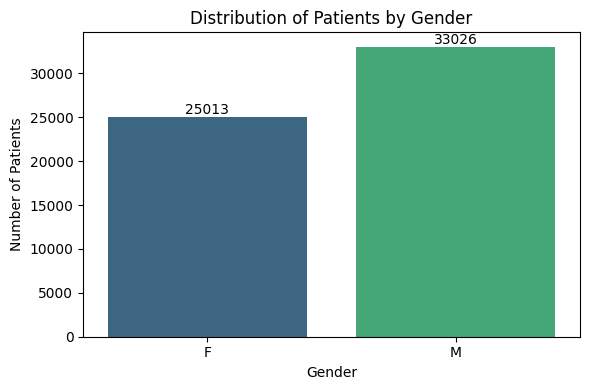


Gender Distribution Data:
  GENDER  count
0      F  25013
1      M  33026
Query Execution Time: 2.12 seconds


In [ ]:
start_time = time.time()

# 1. Define the BigQuery SQL query to get gender counts
query = """
SELECT
    GENDER,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
GROUP BY
    GENDER
ORDER BY
    GENDER;
"""

# 2. Execute the query and load results into a Pandas DataFrame
gender_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not gender_distribution_df.empty:
    plt.figure(figsize=(6, 4))
    sns.barplot(x='GENDER', y='count', data=gender_distribution_df, palette='viridis') # Use Seaborn for nicer plotting

    # Add labels and title
    plt.xlabel("Gender")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by Gender")

    # Add count labels on top of bars
    for index, row in gender_distribution_df.iterrows():
        plt.text(index, row['count'], row['count'], color='black', ha="center", va='bottom')

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned from the query to plot.")

# 4. Print the Dataframe
print("\nGender Distribution Data:")
print(gender_distribution_df)

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Gender & Length of ICU Stay**

<ipython-input-41-3e283b9877ca>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GENDER', y='ICU_LOS', data=gender_los_df, palette='viridis', showfliers=True)


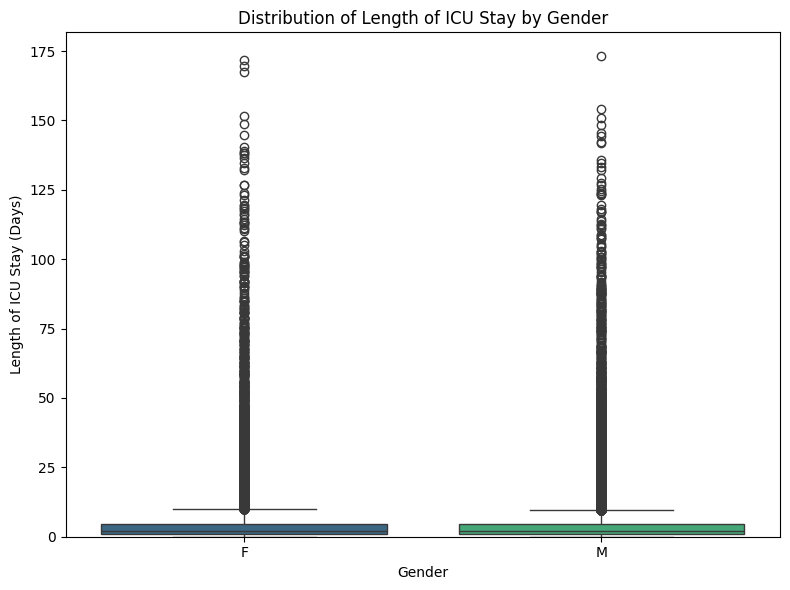


Summary Statistics for ICU LOS by Gender:
          count      mean        std     min       25%     50%     75%  \
GENDER                                                                   
F       25013.0  5.066738  10.104802  0.0001  1.090800  2.1168  4.6438   
M       33026.0  4.928852   9.606139  0.0002  1.111725  2.0739  4.4723   

             max  
GENDER            
F       171.6227  
M       173.0725  
Query Execution Time: 3.26 seconds


In [ ]:
start_time = time.time()

# 1. Define the BigQuery SQL query to get Gender and Length of ICU Stay
query = """
SELECT
    GENDER,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL -- Ensure LOS is not null
    AND GENDER IS NOT NULL -- Ensure Gender is not null
ORDER BY GENDER;
"""

# 2. Execute the query and load results into a Pandas DataFrame
gender_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not gender_los_df.empty:
    plt.figure(figsize=(8, 6))

    # Create the box plot
    sns.boxplot(x='GENDER', y='ICU_LOS', data=gender_los_df, palette='viridis', showfliers=True)
    # showfliers=True to includes outliers

    # Add labels and title
    plt.xlabel("Gender")
    plt.ylabel("Length of ICU Stay (Days)")
    plt.title("Distribution of Length of ICU Stay by Gender")
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Calculate and print summary statistics
    print("\nSummary Statistics for ICU LOS by Gender:")
    print(gender_los_df.groupby('GENDER')['ICU_LOS'].describe())

else:
    print("No data returned from the query to plot.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
The distributions of patients by gender is fairly simetric, with a slight imbalance for `MALE` (~56.0%).

There is no discernible connection between `Gender` and `Length of ICU Stay`.

### **Age Analysis**

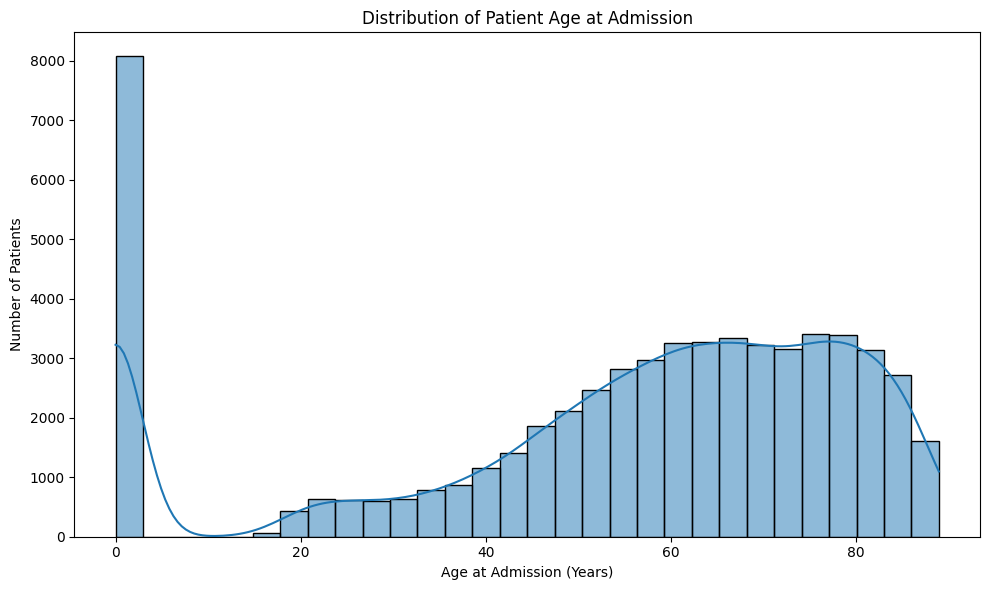


Age at Admission Statistics:
count      58039.0
mean     53.943693
std        26.5604
min            0.0
25%           43.0
50%           61.0
75%           74.0
max           89.0
Name: AGE_AT_ADMISSION, dtype: Float64


In [ ]:
# 1. Define the BigQuery SQL query to get the Age at Admission for each row
query = """
SELECT
    AGE_AT_ADMISSION
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    AGE_AT_ADMISSION IS NOT NULL; -- Ensure age is not null
"""

# 2. Execute the query and load results into a Pandas DataFrame
age_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not age_distribution_df.empty:
    plt.figure(figsize=(10, 6))

    # Create a histogram with a Kernel Density Estimate (KDE) overlay
    sns.histplot(data=age_distribution_df, x='AGE_AT_ADMISSION', kde=True, bins=30)
    # kde=True adds a smooth line representing the distribution shape

    # Add labels and title
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patient Age at Admission")

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned from the query to plot.")

# 4. Print descriptive statistics for Age
print("\nAge at Admission Statistics:")
print(age_distribution_df['AGE_AT_ADMISSION'].describe())


### **Eliminating rows with Age bigger then 120 years**
Given the histogram results, we decided to eliminate the rows with outliers that most definitely represent input errors, given that there are no people near 300 years old.

In [ ]:
query = """
CREATE OR REPLACE TABLE `reliable-jet-452114-s2.table.junction_table` AS
SELECT
  * -- Select all columns from the filtered rows
FROM
  `reliable-jet-452114-s2.table.junction_table`
WHERE
  AGE_AT_ADMISSION <= 120;
"""
query_job = client.query(query)
query_job.result()

In [ ]:
table_id = "reliable-jet-452114-s2.table.junction_table"

# Get the table metadata from BigQuery
table = client.get_table(table_id)

# Access the num_rows attribute from the metadata
num_rows = table.num_rows

print(f"The new number of rows in the table is: {num_rows}")

The new number of rows in the table is: 58039


After eliminating these input error mistakes, we ended up with a table containing 58039 rows (~95.5% of the previous table).

### **Age & Length of ICU Stay**

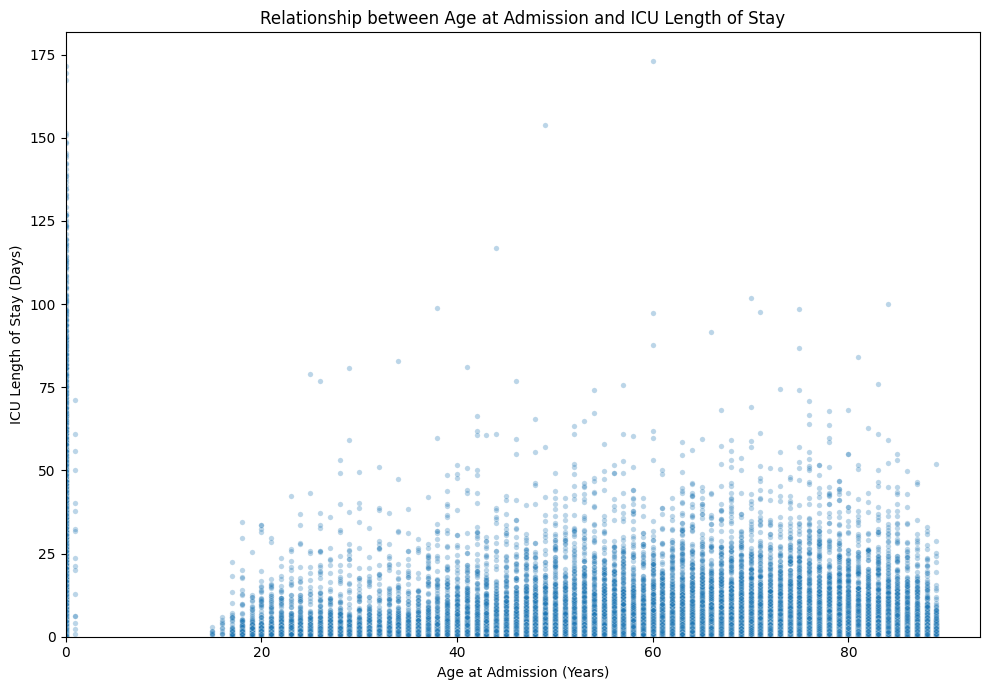


Correlation between Age at Admission and ICU LOS: -0.161


In [ ]:
# 1. Define the BigQuery SQL query to get Age and ICU Length of ICU Stay
query = """
SELECT
    AGE_AT_ADMISSION,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND AGE_AT_ADMISSION IS NOT NULL
"""

# 2. Execute the query and load results into a Pandas DataFrame
age_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not age_los_df.empty:
    plt.figure(figsize=(10, 7))

    # Create a scatter plot
    sns.scatterplot(x='AGE_AT_ADMISSION', y='ICU_LOS', data=age_los_df, alpha=0.3, s=15)

    # Add labels and title
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("ICU Length of ICU Stay (Days)")
    plt.title("Relationship between Age at Admission and ICU Length of ICU Stay")
    plt.ylim(bottom=0) # Ensure y-axis starts at 0
    plt.xlim(left=0)   # Ensure x-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Calculate correlation
    correlation = age_los_df['AGE_AT_ADMISSION'].corr(age_los_df['ICU_LOS'])
    print(f"\nCorrelation between Age at Admission and ICU LOS: {correlation:.3f}")

else:
    print("No data returned from the query to plot.")

### **Conclusion**
By analysing the histogram of `Age`, we can see that the most common age intervals in the dataset are `0` and `50-80`. The dataset proposely ommits data from minor patients with the excpetion of newborns.

Regarding the connection between `Age` and `Length of ICU Stay`, we can conclude that:
1. The vast majority of ICU stays are relatively short (concentrated roughly below 25 days) across all adult age groups.
2. While short stays are common for all ages, the spread of the values of `Length of ICU Stay` appears to widen slightly for older patients, which means that very long stays seem slightly more prevalent among older age groups.

### **Insurance Analysis**

<ipython-input-4-bde86873813b>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='INSURANCE', data=insurance_distribution_df, palette='magma', orient='h') # Horizontal bar chart


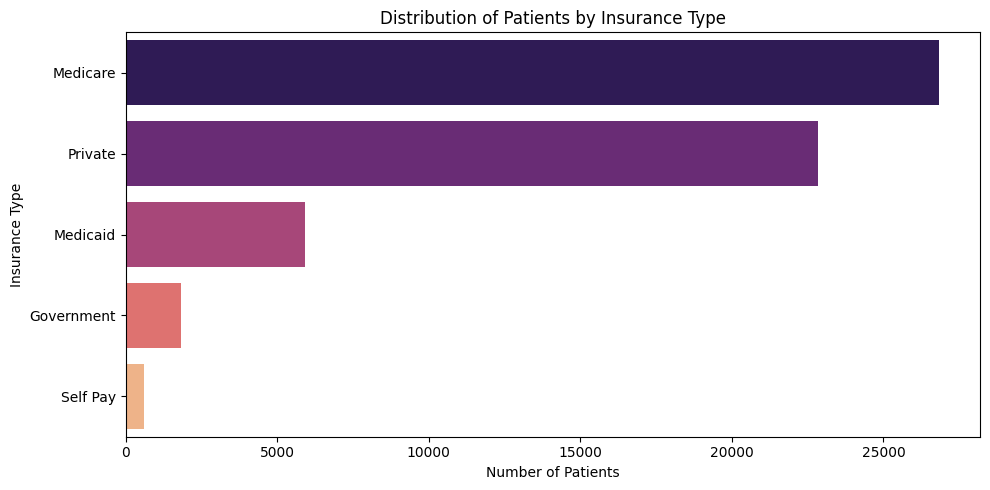

In [ ]:
# 1. Define the BigQuery SQL query to get the Insurance for each row
query = """
SELECT
    INSURANCE,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    INSURANCE IS NOT NULL
GROUP BY
    INSURANCE
ORDER BY
    count DESC; -- Order by count to see most common types first
"""

# 2. Execute the query and load results into a Pandas DataFrame
insurance_distribution_df = client.query(query).to_dataframe()

# 3. Create the distribution visualization using MatPlotLib and SeaBorn
if not insurance_distribution_df.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='INSURANCE', data=insurance_distribution_df, palette='magma', orient='h') # Horizontal bar chart

    # Add labels and title
    plt.xlabel("Number of Patients")
    plt.ylabel("Insurance Type")
    plt.title("Distribution of Patients by Insurance Type")

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for insurance distribution query.")


### **Insurance & Length of ICU Stay**

<ipython-input-5-d83a46a0aebb>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INSURANCE', y='ICU_LOS', data=insurance_los_df, palette='magma', showfliers=False) # Vertical, hide outliers for clarity


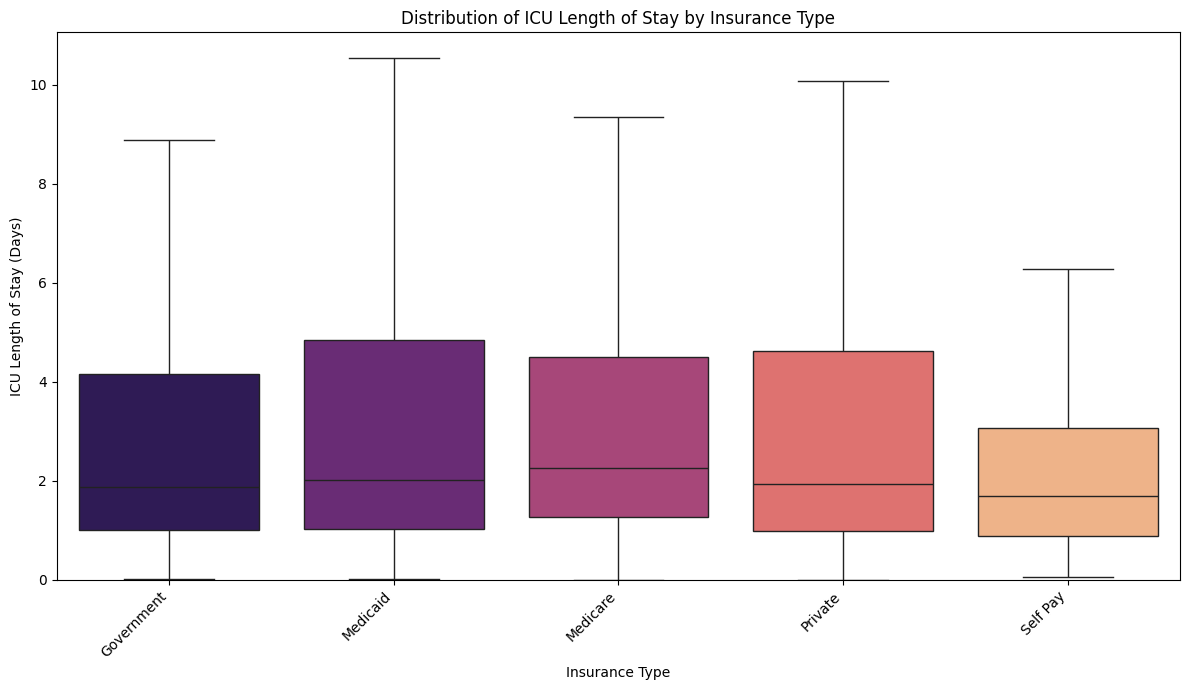


Summary Statistics for ICU LOS by Insurance Type:
              count      mean        std     min       25%      50%       75%  \
INSURANCE                                                                       
Government   1822.0  4.895602   9.793321  0.0057  0.998850  1.87805  4.167150   
Medicaid     5919.0  5.900825  12.800130  0.0036  1.025900  2.02050  4.835200   
Medicare    26843.0  4.306665   6.252719  0.0001  1.260800  2.26430  4.501300   
Private     22845.0  5.611555  12.140707  0.0002  0.982100  1.92950  4.625200   
Self Pay      610.0  3.062356   4.486948  0.0614  0.888425  1.68900  3.057675   

                 max  
INSURANCE             
Government  101.8397  
Medicaid    169.4202  
Medicare    173.0725  
Private     171.6227  
Self Pay     43.1465  


In [ ]:
# 1. Define the BigQuery SQL query to get Insurance and ICU Length of ICU Stay
query = """
SELECT
    INSURANCE,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND INSURANCE IS NOT NULL
ORDER BY INSURANCE;
"""

# 2. Execute the query and load results into a Pandas DataFrame
insurance_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not insurance_los_df.empty:
    plt.figure(figsize=(12, 7))

    # Create the box plot
    sns.boxplot(x='INSURANCE', y='ICU_LOS', data=insurance_los_df, palette='magma', showfliers=False)

    # Add labels and title
    plt.xlabel("Insurance Type")
    plt.ylabel("Length of ICU Stay (Days)")
    plt.title("Distribution of Length of ICU Stay by Insurance Type")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for ICU LOS by Insurance Type:")
    print(insurance_los_df.groupby('INSURANCE')['ICU_LOS'].describe())

else:
    print("No data returned for insurance vs. LOS query.")

### **Conclusion**
By analysing the bar chart of `Insurance`, we can see that the most common insurance systems are `Medicare` followed by `Private`, and that there is a significantly lower number of patients using other systems.

Regarding the connection between `Insurance` and `Length of ICU Stay`, we can conclude that all systems have a similar distribution and mean in the comparison of the two metrics, with the exception of `Self Pay`, whose average value for `Length of ICU Stay` is significantly lower.

### **Ethnicity Analysis**

<ipython-input-16-68e434b7d292>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ETHNICITY', data=ethnicity_distribution_df, palette='crest', orient='h') # Horizontal bar chart


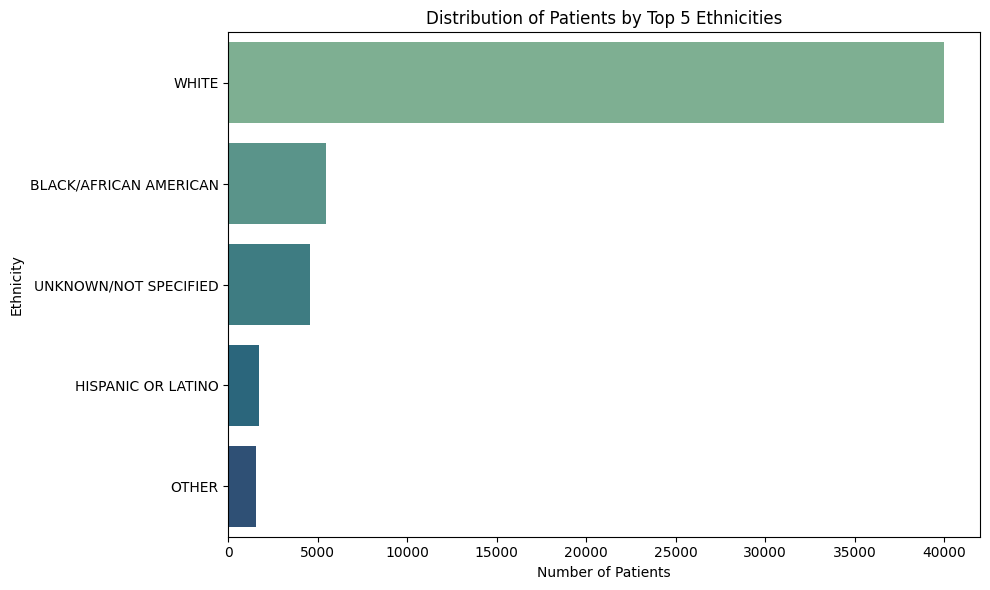

In [ ]:
# 1. Define the BigQuery SQL query to get the top 5 ethnicity counts
query = """
SELECT
    ETHNICITY,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ETHNICITY IS NOT NULL
GROUP BY
    ETHNICITY
ORDER BY
    count DESC -- Order by count to see most common groups first
LIMIT 5; -- Limit the results to the top 5
"""

# 2. Execute the query and load results into a Pandas DataFrame
ethnicity_distribution_df = client.query(query).to_dataframe()

# 3. Create the distribution visualization using Matplotlib and Seaborn
if not ethnicity_distribution_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ETHNICITY', data=ethnicity_distribution_df, palette='crest', orient='h') # Horizontal bar chart

    # Add labels and title
    plt.xlabel("Number of Patients")
    plt.ylabel("Ethnicity")
    plt.title("Distribution of Patients by Top 5 Ethnicities")

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for ethnicity distribution query.")


### **Ethnicity & Length of ICU Stay**

<ipython-input-18-0fa546c6be4d>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ETHNICITY', y='ICU_LOS', data=ethnicity_los_df, palette='crest', order=top_ethnicities_list, showfliers=False)


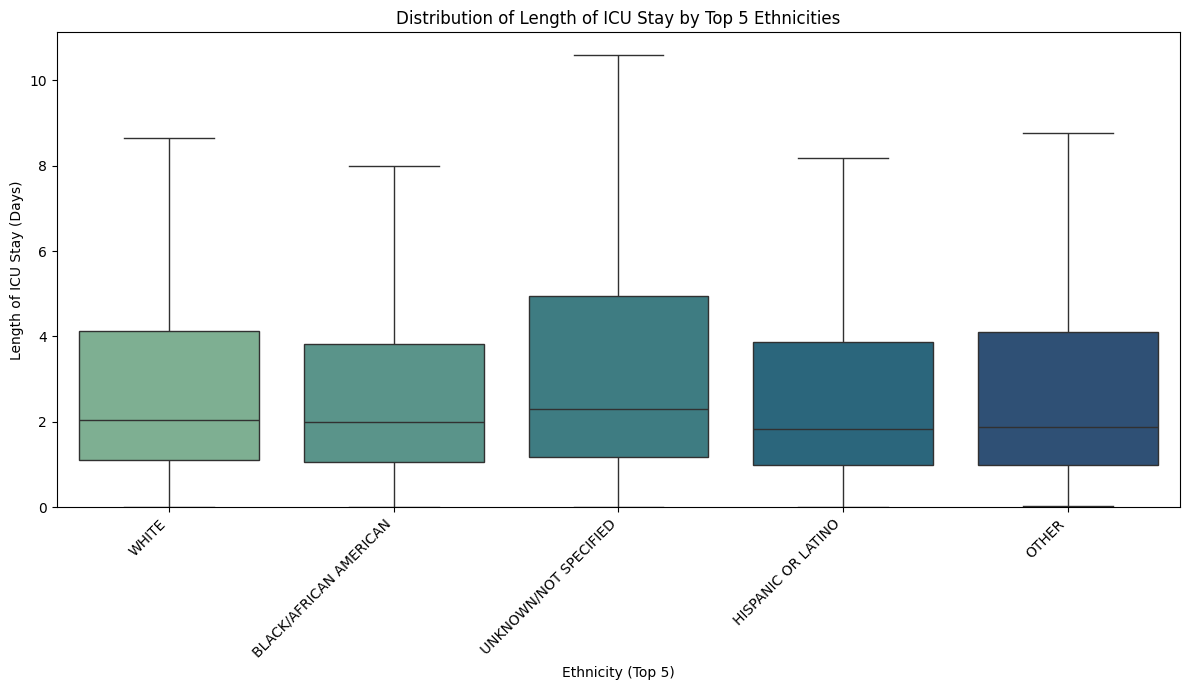


Summary Statistics for ICU LOS by Top 5 Ethnicities:
                          count      mean       std     min       25%  \
ETHNICITY                                                               
BLACK/AFRICAN AMERICAN   5247.0  3.315243  3.933401  0.0025  1.046900   
HISPANIC OR LATINO       1656.0  3.463486  4.396406  0.0019  0.980425   
OTHER                    1454.0  3.584422  4.574565  0.0209  0.983450   
UNKNOWN/NOT SPECIFIED    4364.0  4.075112  4.571024  0.0014  1.181575   
WHITE                   38802.0  3.594078  4.203717  0.0001  1.105100   

                            50%       75%      max  
ETHNICITY                                           
BLACK/AFRICAN AMERICAN  1.98800  3.829750  24.9090  
HISPANIC OR LATINO      1.84185  3.869450  24.4639  
OTHER                   1.87655  4.109275  24.8130  
UNKNOWN/NOT SPECIFIED   2.28950  4.951025  24.6889  
WHITE                   2.04480  4.122675  24.9968  


In [ ]:
# 1. Define the BigQuery SQL query to get the Top 5 Ethnicities first
query_top_ethnicities = """
SELECT
    ETHNICITY
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ETHNICITY IS NOT NULL
GROUP BY
    ETHNICITY
ORDER BY
    COUNT(*) DESC
LIMIT 5;
"""

# Execute the query to get the top 5 list
top_ethnicities_df = client.query(query_top_ethnicities).to_dataframe()
top_ethnicities_list = top_ethnicities_df['ETHNICITY'].tolist()

# Check if the list is not empty before proceeding
if top_ethnicities_list:
    # Format the list for the SQL IN clause
    formatted_top_ethnicities = ", ".join([f"'{eth}'" for eth in top_ethnicities_list])

    # 2. Define the BigQuery SQL query to get Ethnicity and ICU Length of Stay for the Top 5
    query = f"""
    SELECT
        ETHNICITY,
        ICU_LOS
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        ICU_LOS IS NOT NULL
        AND ETHNICITY IN ({formatted_top_ethnicities}) -- Filter for top 5 ethnicities
        AND ICU_LOS < 25 -- Filter for patients with 25 or less days in ICU
    ORDER BY ETHNICITY;
    """

    # 3. Execute the query and load results into a Pandas DataFrame
    ethnicity_los_df = client.query(query).to_dataframe()

    # 4. Create the visualization using Matplotlib and Seaborn
    if not ethnicity_los_df.empty:
        plt.figure(figsize=(12, 7))

        # Create the box plot, explicitly using the top_ethnicities_list for order
        sns.boxplot(x='ETHNICITY', y='ICU_LOS', data=ethnicity_los_df, palette='crest', order=top_ethnicities_list, showfliers=False)

        # Add labels and title
        plt.xlabel("Ethnicity (Top 5)")
        plt.ylabel("Length of ICU Stay (Days)")
        plt.title("Distribution of Length of ICU Stay by Top 5 Ethnicities")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(bottom=0)

        # Display the plot
        plt.tight_layout()
        plt.show()

        # Print summary statistics for the Top 5
        print("\nSummary Statistics for ICU LOS by Top 5 Ethnicities:")
        print(ethnicity_los_df.groupby('ETHNICITY')['ICU_LOS'].describe())

    else:
        print("No data returned for ethnicity vs. LOS query for top 5.")
else:
    print("Could not determine the top 5 ethnicities.")

### **Conclusion**
There is a clear imbalance in the `Ethnicity` distribution, with most of the patients being `WHITE`.

There isn’t a clear connection between `Ethnicity` and `ICU Length of Stay`, with the mean values for the `ICU Length of Stay` of each `Ethnicity` being similar.


## **Medical Data**
We will continue the dataset analysis with an in-depth analysis of the features regarding patients medical records while they were hositalized, which include:

- `Type of Admission`
- `Hour of Admission`
- `Difference between Hour of Admission and Hour of Icu Admission`
- `Diagnostic Code`
- `First Care Unit`
- `Death`
- `Length of ICU Stay (Target)`

### **Type of Admission Analysis**

<ipython-input-4-7d33f20a73c8>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ADMISSION_TYPE', y='count', data=adm_type_distribution_df, palette='cubehelix')


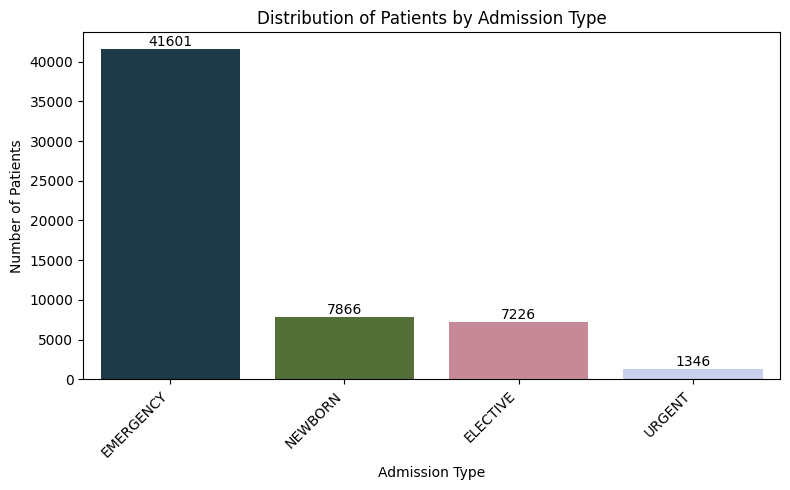

In [ ]:
# 1. Define the BigQuery SQL query to get admission type counts
query = """
SELECT
    ADMISSION_TYPE,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ADMISSION_TYPE IS NOT NULL
GROUP BY
    ADMISSION_TYPE
ORDER BY
    count DESC; -- Order by count to see most common types first
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_type_distribution_df = client.query(query).to_dataframe()

# 3. Create the distribution visualization using MatplotLib and Seaborn
if not adm_type_distribution_df.empty:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='ADMISSION_TYPE', y='count', data=adm_type_distribution_df, palette='cubehelix')

    # Add labels and title
    plt.xlabel("Admission Type")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by Admission Type")
    plt.xticks(rotation=45, ha='right')

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for admission type distribution query.")

### **Type of Admission & Length of ICU Stay**

<ipython-input-5-168f0654216f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADMISSION_TYPE', y='ICU_LOS', data=adm_type_los_df, palette='cubehelix', showfliers=False) # Vertical, hide outliers


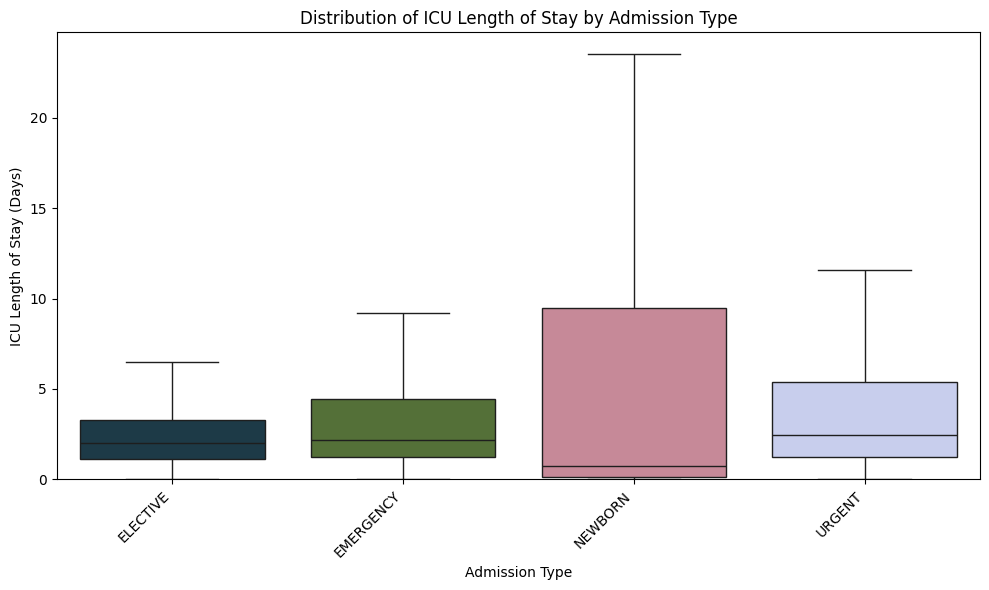


Summary Statistics for ICU LOS by Admission Type:
                  count      mean        std     min       25%     50%  \
ADMISSION_TYPE                                                           
ELECTIVE         7226.0  3.503513   6.008552  0.0004  1.140675  1.9895   
EMERGENCY       41601.0  4.309662   6.436865  0.0001  1.229700  2.1897   
NEWBORN          7866.0  9.878190  20.483139  0.0008  0.137675  0.7253   
URGENT           1346.0  5.356694   8.359788  0.0025  1.241075  2.4351   

                     75%       max  
ADMISSION_TYPE                      
ELECTIVE        3.283750  173.0725  
EMERGENCY       4.420000  169.4202  
NEWBORN         9.500975  171.6227  
URGENT          5.380250   97.4897  


In [ ]:
# 1. Define the BigQuery SQL query to get Admission Type and Length of ICU Stay
query = """
SELECT
    ADMISSION_TYPE,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND ADMISSION_TYPE IS NOT NULL
ORDER BY ADMISSION_TYPE;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_type_los_df = client.query(query).to_dataframe()

# 3. Create the relationship visualization using MatplotLib and Seaborn
if not adm_type_los_df.empty:
    plt.figure(figsize=(10, 6))

    # Create the box plot
    sns.boxplot(x='ADMISSION_TYPE', y='ICU_LOS', data=adm_type_los_df, palette='cubehelix', showfliers=False) # Vertical, hide outliers

    # Add labels and title
    plt.xlabel("Admission Type")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by Admission Type")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for ICU LOS by Admission Type:")
    print(adm_type_los_df.groupby('ADMISSION_TYPE')['ICU_LOS'].describe())

else:
    print("No data returned for admission type vs. LOS query.")

### **Conclusion**
The distributions of patients by `Type of Admission` is uneven, with most admissions being classified as `EMERGENCY`. The least recurrent type of admissions is `Urgent`.

There is an evident connection between `Type of Admission` and `Length of ICU Stay`, with `NEWBORN` having the highest mean values (close to 10 days) while the other types of admission have mean values between 3 to 5 days.

### **Hour of Admission Analysis**

<ipython-input-48-beb0f04ab633>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ADMISSION_HOUR', y='count', data=adm_hour_distribution_df, palette='rocket')


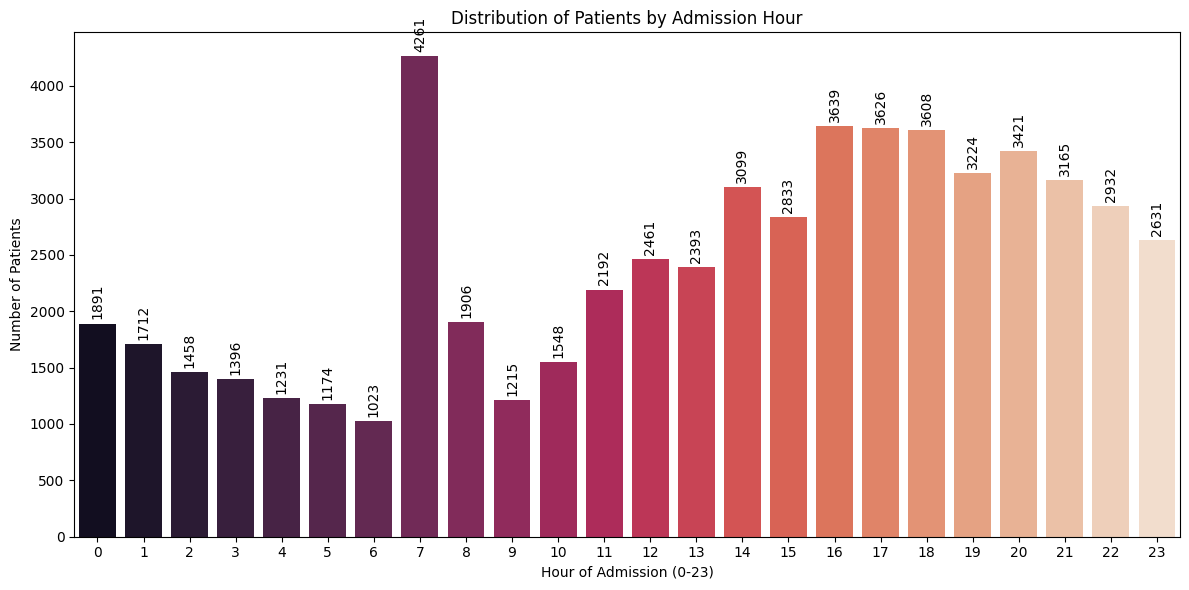

Query Execution Time: 2.33 seconds


In [ ]:
start_time = time.time()

# 1. Define the BigQuery SQL query to get admission hour counts
query = """
SELECT
    ADMISSION_HOUR,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ADMISSION_HOUR IS NOT NULL
GROUP BY
    ADMISSION_HOUR
ORDER BY
    ADMISSION_HOUR; -- Order by hour (0-23)
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_hour_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not adm_hour_distribution_df.empty:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='ADMISSION_HOUR', y='count', data=adm_hour_distribution_df, palette='rocket')

    # Add labels and title
    plt.xlabel("Hour of Admission (0-23)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by Admission Hour")
    plt.xticks(range(0, 24))

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', rotation=90, padding=3)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for admission hour distribution query.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Hour of Admission & Length of ICU Stay**

<ipython-input-49-277b40886152>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADMISSION_HOUR', y='ICU_LOS', data=adm_hour_los_df, palette='rocket', showfliers=False)


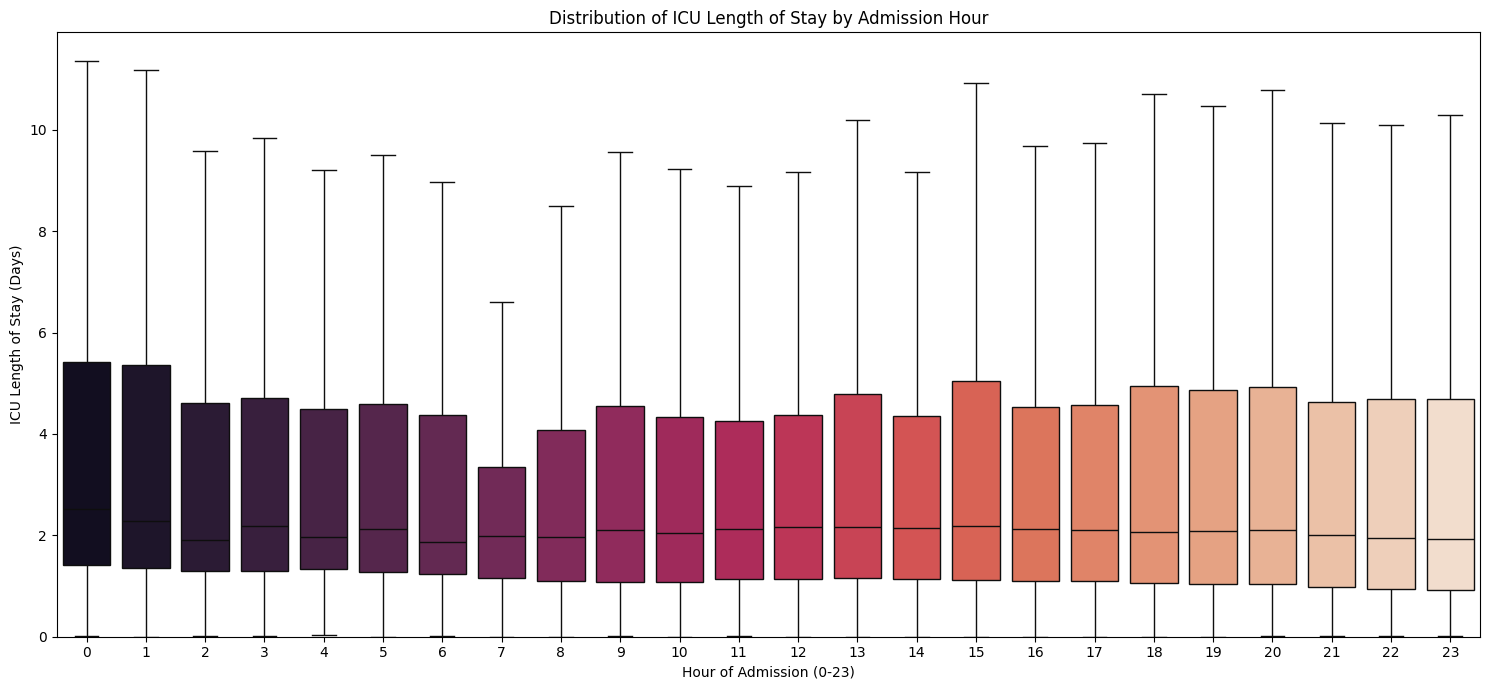


Summary Statistics for ICU LOS by Admission Hour:
                 count      mean        std     min       25%      50%  \
ADMISSION_HOUR                                                           
0               1891.0  5.395593   9.814776  0.0160  1.420350  2.52960   
1               1712.0  5.512634  10.433807  0.0003  1.346150  2.28265   
2               1458.0  4.813653   9.620965  0.0206  1.298175  1.91085   
3               1396.0  5.047518  10.259017  0.0047  1.290625  2.19230   
4               1231.0  5.023875  10.586523  0.0245  1.328450  1.97100   
5               1174.0  5.256344  10.591170  0.0002  1.275700  2.12510   
6               1023.0  5.368494  12.690322  0.0203  1.244300  1.87670   
7               4261.0  3.832038   7.981137  0.0036  1.162000  1.99170   
8               1906.0  5.067366  12.268948  0.0014  1.096200  1.97030   
9               1215.0  5.884291  11.624294  0.0218  1.084150  2.09620   
10              1548.0  5.094745   9.783121  0.0006  1.073025

In [ ]:
start_time = time.time()

# 1. Define the BigQuery SQL query to get Admission Hour and ICU Length of Stay
query = """
SELECT
    ADMISSION_HOUR,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND ADMISSION_HOUR IS NOT NULL
ORDER BY ADMISSION_HOUR;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_hour_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not adm_hour_los_df.empty:
    plt.figure(figsize=(15, 7))

    # Create the box plot
    sns.boxplot(x='ADMISSION_HOUR', y='ICU_LOS', data=adm_hour_los_df, palette='rocket', showfliers=False)

    # Add labels and title
    plt.xlabel("Hour of Admission (0-23)")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by Admission Hour")
    plt.xticks(range(0, 24)) # Ensure all hours are labeled
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for ICU LOS by Admission Hour:")
    print(adm_hour_los_df.groupby('ADMISSION_HOUR')['ICU_LOS'].describe())

else:
    print("No data returned for admission hour vs. LOS query.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
There is clearly an outlier (`7 AM`) in the distribution of patients by `Hour of Admission`. Besides that, this distribution follows an increasing trend during the day [8-18] and a decreasing trend during the night [8-6].

There isn’t an apparent connection between `Hour of Admission` and `ICU Length of Stay`, with the distribution of the mean values for the correlation being uniform.



### **Difference between Hour of Admission and ICU Hour of Admission Analysis**

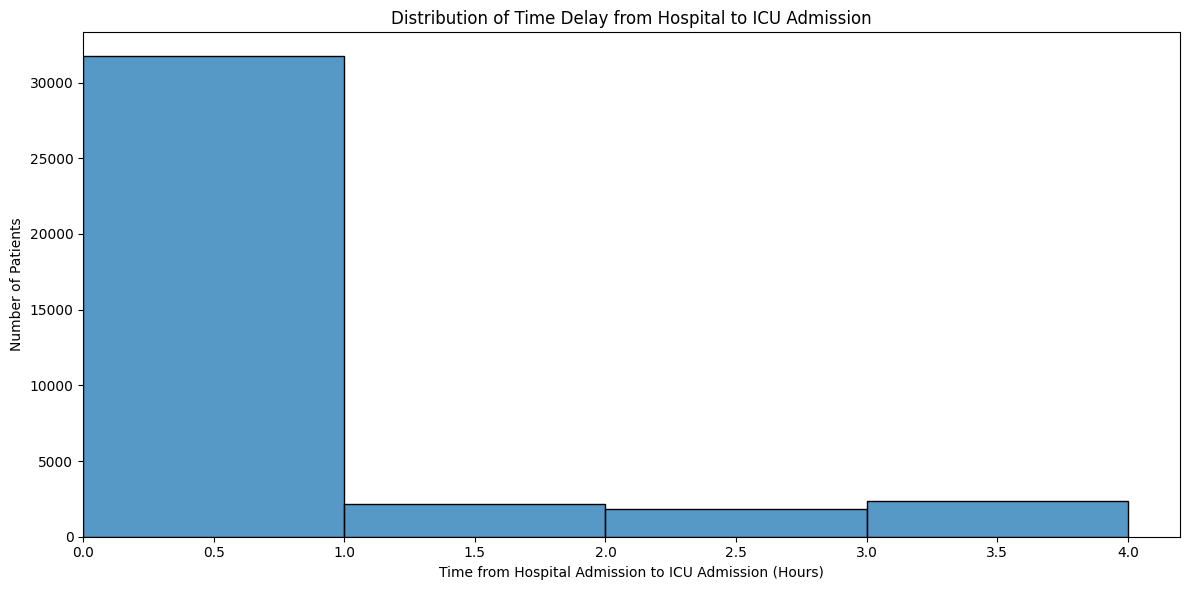


Hospital to ICU Admission Time Difference Statistics (Hours):
count     38117.0
mean     0.364352
std      0.919322
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           4.0
Name: HOSP_TO_ICU_HOURS, dtype: Float64


In [ ]:
# 1. Define the BigQuery SQL query to calculate and get the time difference
query = """
SELECT
    TIMESTAMP_DIFF(ICU_INTIME, ADMITTIME, HOUR) AS HOSP_TO_ICU_HOURS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ADMITTIME IS NOT NULL
    AND ICU_INTIME IS NOT NULL
    AND TIMESTAMP_DIFF(ICU_INTIME, ADMITTIME, HOUR) >= 0 -- Exclude cases where ICU time is before admission time
    -- Add upper limit for visualization
    AND TIMESTAMP_DIFF(ICU_INTIME, ADMITTIME, HOUR) < 5
"""

# 2. Execute the query and load results into a Pandas DataFrame
hosp_to_icu_dist_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not hosp_to_icu_dist_df.empty:
    plt.figure(figsize=(12, 6))

    # Create a histogram
    sns.histplot(data=hosp_to_icu_dist_df, x='HOSP_TO_ICU_HOURS', kde=False, bins=4)

    # Add labels and title
    plt.xlabel("Time from Hospital Admission to ICU Admission (Hours)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Time Delay from Hospital to ICU Admission")
    plt.xlim(left=0) # Start x-axis at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics for the time difference
    print("\nHospital to ICU Admission Time Difference Statistics (Hours):")
    print(hosp_to_icu_dist_df['HOSP_TO_ICU_HOURS'].describe())

else:
    print("No data returned for Hospital to ICU admission time difference distribution query.")

### **Conclusion**
 Most of the Admissions in ICU Stay occur within the first hour in the hospital, with the mean time for the difference between `Hour of Admission` and `ICU Hour of Admission` being ~22 minutes.

### **Diagnosis Analysis**

<ipython-input-14-f3c32900dad3>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='CODE_TITLE', data=icd9_distribution_df, palette='viridis', orient='h')


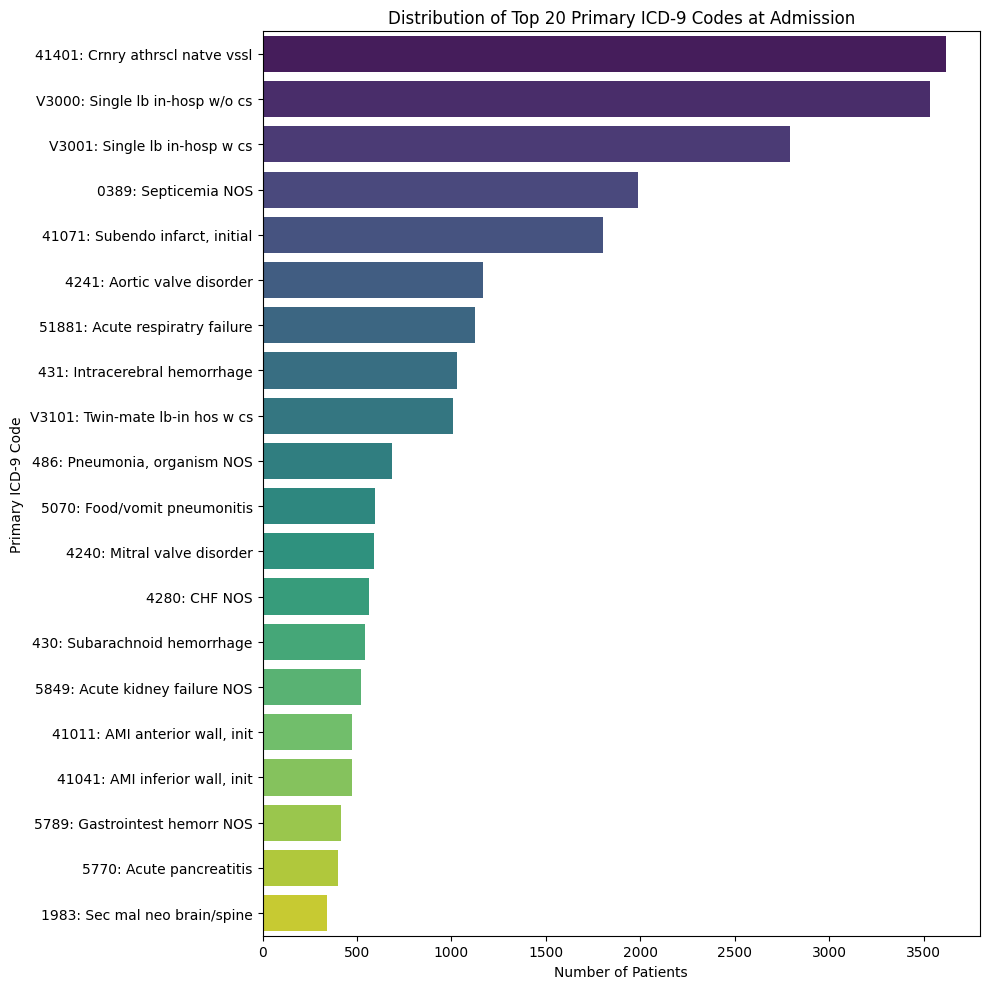

In [ ]:
# 1. Define the BigQuery SQL query to get the counts of the top 20 primary ICD-9 codes
query = """
WITH TopCodes AS (
    SELECT
        PRIMARY_ICD9_CODE,
        COUNT(*) AS count
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        PRIMARY_ICD9_CODE IS NOT NULL
    GROUP BY
        PRIMARY_ICD9_CODE
    ORDER BY
        count DESC
    LIMIT 20 -- Limit to the top 20 most frequent codes
)
SELECT
    jt.PRIMARY_ICD9_CODE,
    tc.count,
    ANY_VALUE(jt.PRIMARY_ICD9_TITLE) AS PRIMARY_ICD9_TITLE -- Get a representative title
FROM
    `reliable-jet-452114-s2.table.junction_table` jt
JOIN
    TopCodes tc ON jt.PRIMARY_ICD9_CODE = tc.PRIMARY_ICD9_CODE
GROUP BY
    jt.PRIMARY_ICD9_CODE, tc.count
ORDER BY
    tc.count DESC;
"""

# 2. Execute the query and load results into a Pandas DataFrame
icd9_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not icd9_distribution_df.empty:
    plt.figure(figsize=(10, 10))
    # Combine code and title for better y-axis labels
    icd9_distribution_df['CODE_TITLE'] = icd9_distribution_df['PRIMARY_ICD9_CODE'] + ': ' + icd9_distribution_df['PRIMARY_ICD9_TITLE'].fillna('N/A')
    sns.barplot(x='count', y='CODE_TITLE', data=icd9_distribution_df, palette='viridis', orient='h')

    # Add labels and title
    plt.xlabel("Number of Patients")
    plt.ylabel("Primary ICD-9 Code")
    plt.title("Distribution of Top 20 Primary ICD-9 Codes at Admission")

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for primary ICD-9 code distribution query.")

### **Diagnosis & Length of ICU Stay**

<ipython-input-15-24c6b6b5d6e2>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PRIMARY_ICD9_CODE', y='ICU_LOS', data=icd9_los_df, palette='viridis', order=top_codes_list, showfliers=False) # Vertical, hide outliers


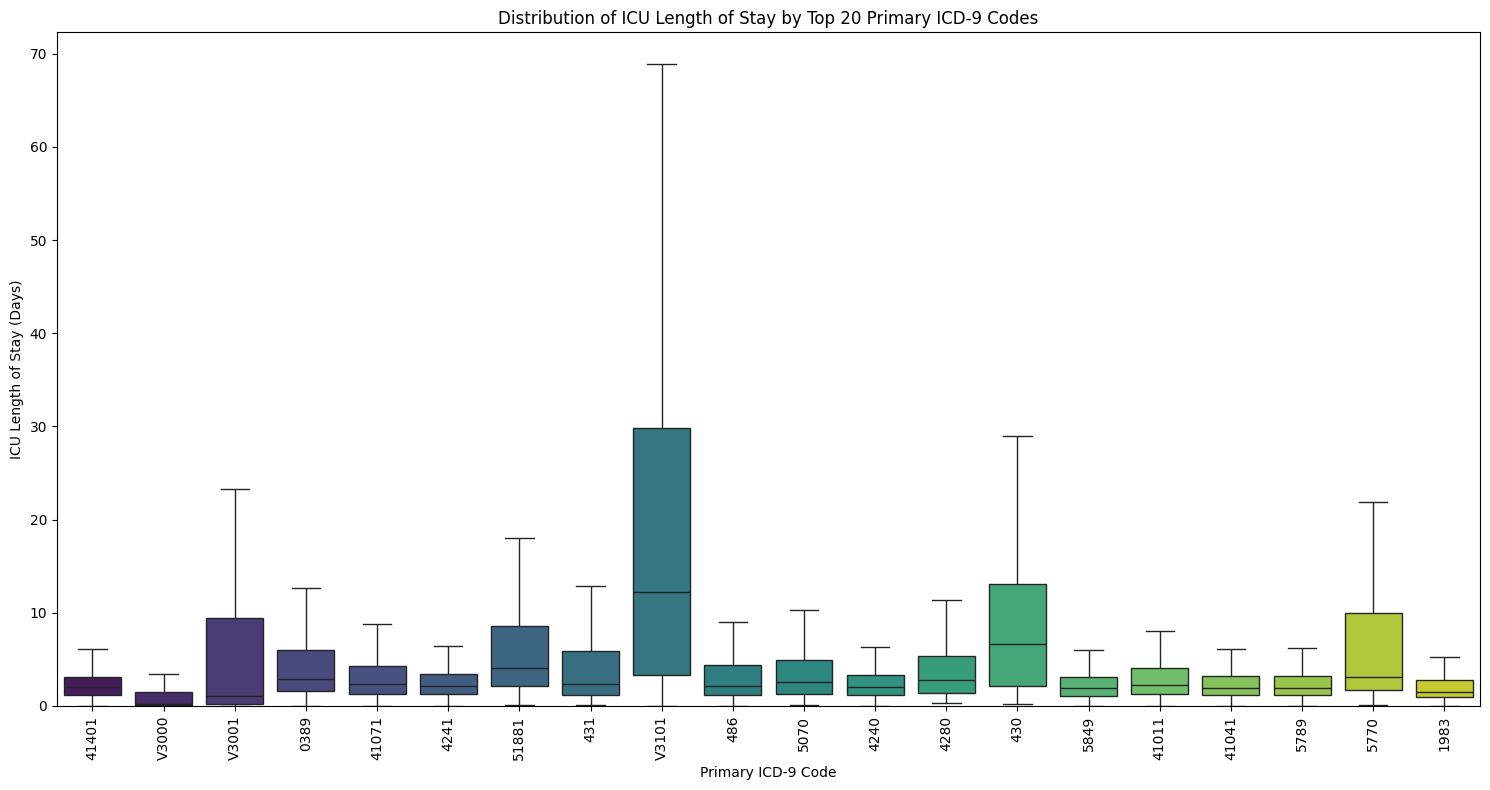


Summary Statistics for ICU LOS by Top 20 Primary ICD-9 Codes:
                    count       mean        std     min       25%       50%  \
PRIMARY_ICD9_CODE                                                             
0389               1988.0   5.329782   7.084884  0.0079  1.614200   2.87470   
1983                343.0   2.509505   3.203271  0.0079  1.005550   1.51880   
41011               473.0   3.895759   5.718157  0.0435  1.314000   2.20950   
41041               471.0   3.449264   4.951962  0.0033  1.230300   1.94030   
41071              1803.0   4.026161   5.369919  0.0016  1.288900   2.35840   
41401              3617.0   2.876750   3.885769  0.0048  1.154600   1.99070   
4240                592.0   3.466497   5.780785  0.0077  1.159450   2.02135   
4241               1168.0   3.624113   5.788327  0.0014  1.233175   2.14675   
4280                562.0   4.949970   6.628354  0.3021  1.387300   2.73745   
430                 542.0   9.060081   8.904613  0.1733  2.170775   

In [ ]:
# 1. Define the BigQuery SQL query to get ICU Length of Stay for the top 20 ICD-9 Codes
#    We reuse the list of top codes identified above.
top_codes_list = icd9_distribution_df['PRIMARY_ICD9_CODE'].tolist()

# Check if the list is not empty before the query
if top_codes_list:
    # Format the list of codes for the SQL IN clause
    formatted_top_codes = ", ".join([f"'{code}'" for code in top_codes_list])

    query = f"""
    SELECT
        PRIMARY_ICD9_CODE,
        ICU_LOS
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        ICU_LOS IS NOT NULL
        AND PRIMARY_ICD9_CODE IN ({formatted_top_codes}) -- Filter for top 20 codes
    ORDER BY PRIMARY_ICD9_CODE;
    """

    # 2. Execute the query and load results into a Pandas DataFrame
    icd9_los_df = client.query(query).to_dataframe()

    # 3. Create the visualization using Matplotlib and Seaborn
    if not icd9_los_df.empty:
        plt.figure(figsize=(15, 8))

        # Create the box plot, ordering by the frequency from the first query
        sns.boxplot(x='PRIMARY_ICD9_CODE', y='ICU_LOS', data=icd9_los_df, palette='viridis', order=top_codes_list, showfliers=False) # Vertical, hide outliers

        # Add labels and title
        plt.xlabel("Primary ICD-9 Code")
        plt.ylabel("ICU Length of Stay (Days)")
        plt.title("Distribution of ICU Length of Stay by Top 20 Primary ICD-9 Codes")
        plt.xticks(rotation=90)
        plt.ylim(bottom=0) # Ensure y-axis starts at 0

        # Display the plot
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary Statistics for ICU LOS by Top 20 Primary ICD-9 Codes:")
        print(icd9_los_df.groupby('PRIMARY_ICD9_CODE')['ICU_LOS'].describe())

    else:
        print("No data returned for top ICD-9 codes vs. LOS query.")
else:
    print("Cannot proceed with LOS analysis as no top ICD-9 codes were identified.")

### **Conclusion**
There is a very unsymmetric distribution of Diagnosis. In the top-20 most common diagnosis, with the most common being `41401 (Coronary atherosclerosis of native vessel)`.
The correlation between some `Diagnosis` and `ICU Length of Stay` is evident, with `V3101 (Twin mate, liveborn, delivered in hospital, with cesarean section)` having a mean value very high compared to other types of Diagnosis. There are also diagnosis who have an average of `ICU Length of Stay` very low in comparison, like `V3000 (Single liveborn, delivered in hospital, without cesarean section)`.



### **First Care Unit Analysis**

<ipython-input-16-2e951009bbdf>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='FIRST_CAREUNIT', y='count', data=careunit_distribution_df, palette='Spectral')


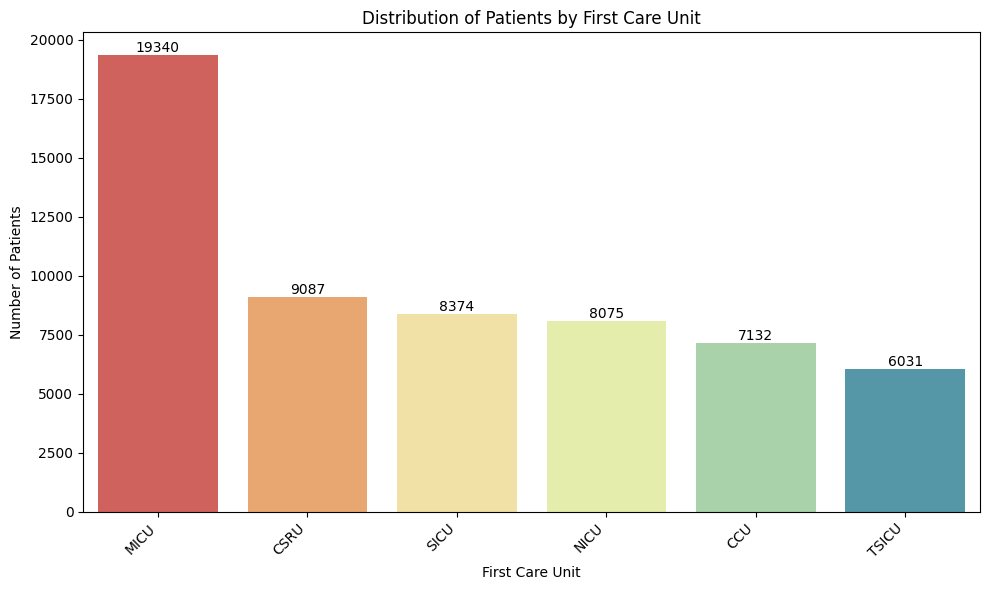

In [ ]:
# 1. Define the BigQuery SQL query to get first care unit counts
query = """
SELECT
    FIRST_CAREUNIT,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    FIRST_CAREUNIT IS NOT NULL
GROUP BY
    FIRST_CAREUNIT
ORDER BY
    count DESC; -- Order by count to see most common units first
"""

# 2. Execute the query and load results into a Pandas DataFrame
careunit_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not careunit_distribution_df.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='FIRST_CAREUNIT', y='count', data=careunit_distribution_df, palette='Spectral')

    # Add labels and title
    plt.xlabel("First Care Unit")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by First Care Unit")
    plt.xticks(rotation=45, ha='right')

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for first care unit distribution query.")

### **First Care of Unit & Length of ICU Stay**

<ipython-input-17-c08169d1c5ed>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FIRST_CAREUNIT', y='ICU_LOS', data=careunit_los_df, palette='Spectral', showfliers=False) # Vertical, hide outliers


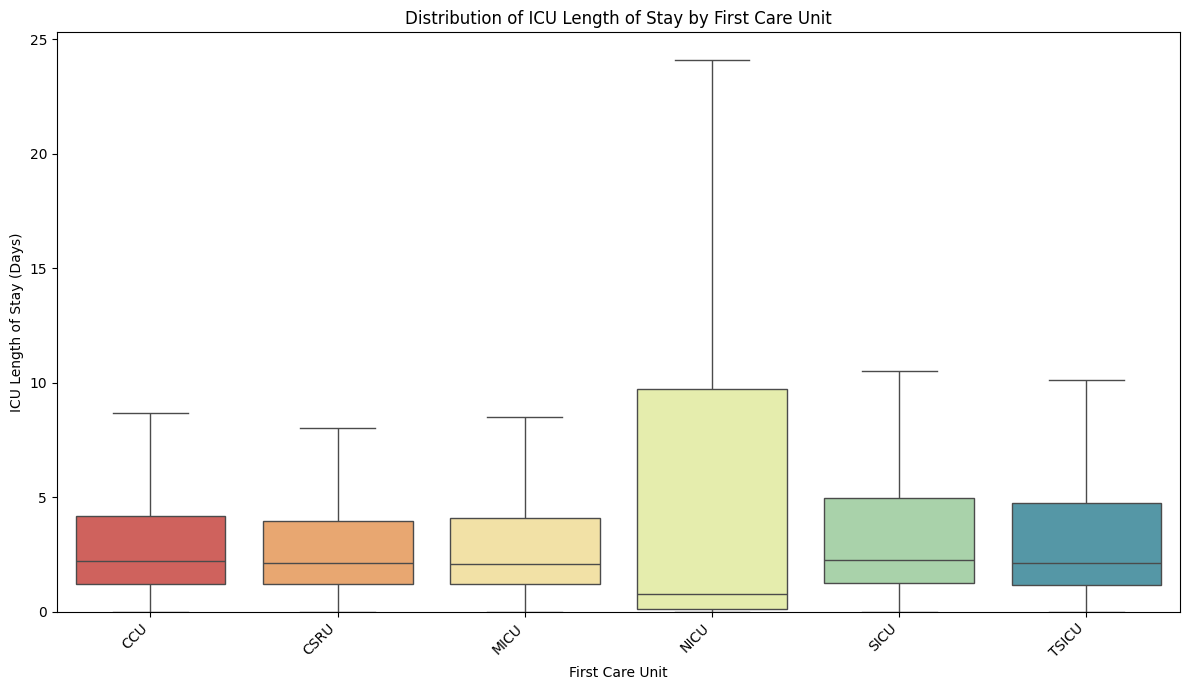


Summary Statistics for ICU LOS by First Care Unit:
                  count       mean        std     min       25%      50%  \
FIRST_CAREUNIT                                                             
CCU              7132.0   3.953257   5.619626  0.0012  1.213125  2.19915   
CSRU             9087.0   3.888229   6.097731  0.0001  1.213850  2.14770   
MICU            19340.0   4.042175   5.890149  0.0004  1.189600  2.09700   
NICU             8075.0  10.004395  20.644582  0.0008  0.140500  0.78470   
SICU             8374.0   4.749462   6.997957  0.0003  1.258775  2.26470   
TSICU            6031.0   4.519062   6.760158  0.0016  1.174100  2.12800   

                     75%       max  
FIRST_CAREUNIT                      
CCU             4.200700  100.1225  
CSRU            3.943200  153.9280  
MICU            4.109775  116.8327  
NICU            9.723350  171.6227  
SICU            4.964775  101.7390  
TSICU           4.755900  173.0725  


In [ ]:
# 1. Define the BigQuery SQL query to get First Care Unit and ICU Length of Stay
query = """
SELECT
    FIRST_CAREUNIT,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND FIRST_CAREUNIT IS NOT NULL
ORDER BY FIRST_CAREUNIT;
"""

# 2. Execute the query and load results into a Pandas DataFrame
careunit_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not careunit_los_df.empty:
    plt.figure(figsize=(12, 7))

    # Create the box plot
    sns.boxplot(x='FIRST_CAREUNIT', y='ICU_LOS', data=careunit_los_df, palette='Spectral', showfliers=False)

    # Add labels and title
    plt.xlabel("First Care Unit")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by First Care Unit")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for ICU LOS by First Care Unit:")
    print(careunit_los_df.groupby('FIRST_CAREUNIT')['ICU_LOS'].describe())

else:
    print("No data returned for first care unit vs. LOS query.")

### **Conclusion**
There is a relative uniform distribution in the number of patients by `First Care Unit` with the exception being `MICU (Medical Intensive Care Unit)`, that has a count of patients that is more than double of each other type of `First Care Unit`.

The correlation between `Type of Care Unit`and `ICU Length of Stay`is also relatively uniform with an exception, `NICU (Neonatal Intensive Care Unit)`.


### **Death Analysis**

<ipython-input-19-8827588862fa>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Outcome', y='count', data=expire_flag_distribution_df, palette='coolwarm')


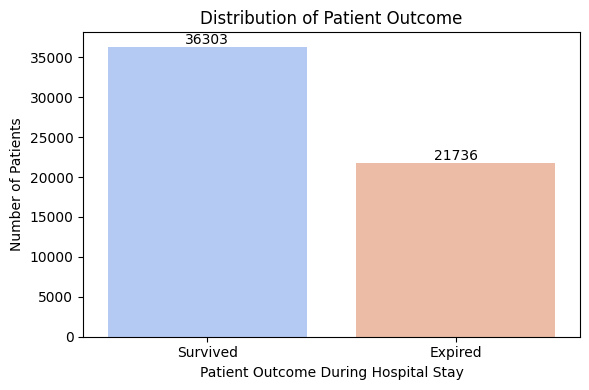

In [ ]:
# 1. Define the BigQuery SQL query to get expire flag counts
query = """
SELECT
    EXPIRE_FLAG,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    EXPIRE_FLAG IS NOT NULL
GROUP BY
    EXPIRE_FLAG
ORDER BY
    EXPIRE_FLAG; -- Order by flag value (0, 1)
"""

# 2. Execute the query and load results into a Pandas DataFrame
expire_flag_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not expire_flag_distribution_df.empty:
    plt.figure(figsize=(6, 4))
    # Map 0/1 to more descriptive labels for the plot
    expire_flag_distribution_df['Outcome'] = expire_flag_distribution_df['EXPIRE_FLAG'].map({0: 'Survived', 1: 'Expired'})
    ax = sns.barplot(x='Outcome', y='count', data=expire_flag_distribution_df, palette='coolwarm')

    # Add labels and title
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patient Outcome")

    # Add count labels on top of bars
    for container in ax.containers:
        ax.bar_label(container)

    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("No data returned for expire flag distribution query.")

### **Death & Length of ICU Stay**

<ipython-input-19-ae139f396912>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Outcome', y='ICU_LOS', data=expire_flag_los_df, palette='coolwarm', showfliers=True) # Show outliers might be relevant here


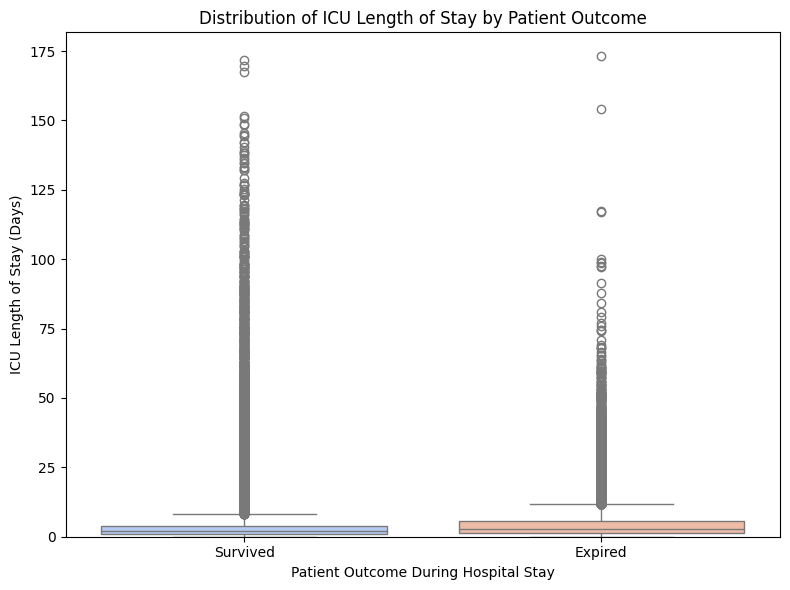


Summary Statistics for ICU LOS by Patient Outcome:
            count      mean        std     min       25%     50%       75%  \
Outcome                                                                      
Expired   21736.0  5.139688   7.542676  0.0001  1.375575  2.6904  5.521625   
Survived  36303.0  4.897620  10.964588  0.0003  1.021650  1.8874  3.945950   

               max  
Outcome             
Expired   173.0725  
Survived  171.6227  


In [ ]:
# 1. Define the BigQuery SQL query to get Expire Flag and ICU Length of Stay
query = """
SELECT
    EXPIRE_FLAG,
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
    AND EXPIRE_FLAG IS NOT NULL
ORDER BY EXPIRE_FLAG;
"""

# 2. Execute the query and load results into a Pandas DataFrame
expire_flag_los_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not expire_flag_los_df.empty:
    plt.figure(figsize=(8, 6))

    # Map 0/1 to more descriptive labels for the plot
    expire_flag_los_df['Outcome'] = expire_flag_los_df['EXPIRE_FLAG'].map({0: 'Survived', 1: 'Expired'})

    # Create the box plot
    sns.boxplot(x='Outcome', y='ICU_LOS', data=expire_flag_los_df, palette='coolwarm', showfliers=True)

    # Add labels and title
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by Patient Outcome")
    plt.ylim(bottom=0) # Ensure y-axis starts at 0

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics for ICU LOS by Patient Outcome:")
    print(expire_flag_los_df.groupby('Outcome')['ICU_LOS'].describe())

else:
    print("No data returned for expire flag vs. LOS query.")

### **Conclusion**
The number of patients that `Survived` is much higher than the number of patients that `Expired`.

The mean of the correlation between `Death` and `ICU Length of Stay` is similar for `Survived and `Expired` but the standard deviation of `Survived` is significantly higher.


### **Length of ICU Stay Analysis**

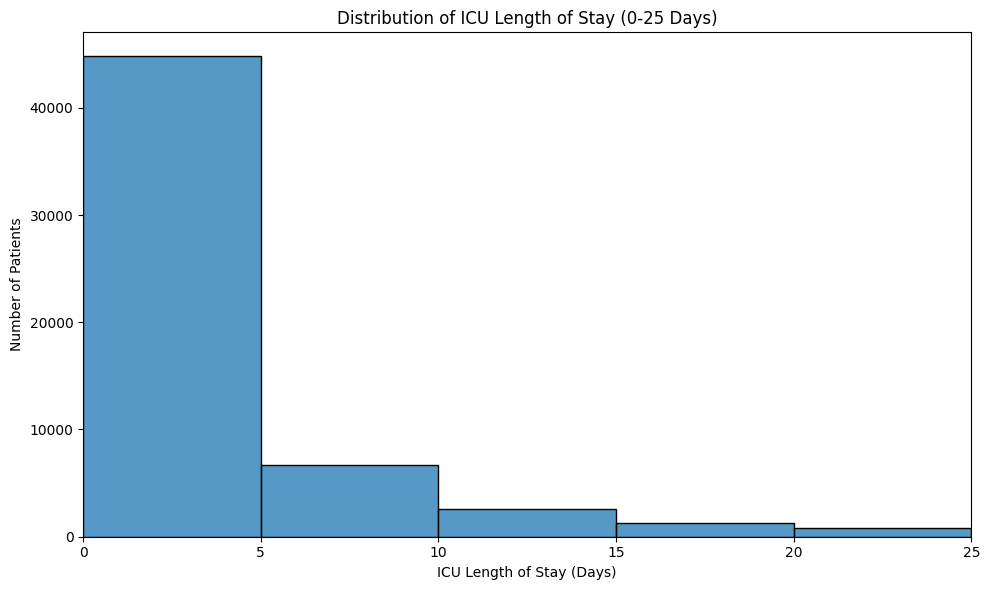


ICU Length of Stay Statistics:
count    58039.000000
mean         4.988276
std          9.824303
min          0.000100
25%          1.103350
50%          2.091800
75%          4.550800
max        173.072500
Name: ICU_LOS, dtype: float64


In [ ]:
# 1. Define the BigQuery SQL query to get ICU Length of Stay values
query = """
SELECT
    ICU_LOS
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ICU_LOS IS NOT NULL
"""

# 2. Execute the query and load results into a Pandas DataFrame
icu_los_distribution_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not icu_los_distribution_df.empty:
    plt.figure(figsize=(10, 6))

    # Filter data for plotting
    plot_data = icu_los_distribution_df[(icu_los_distribution_df['ICU_LOS'] >= 0) & (icu_los_distribution_df['ICU_LOS'] <= 25)]

    # Create a histogram
    sns.histplot(data=plot_data, x='ICU_LOS', kde=False, bins=5)

    # Add labels and title
    plt.xlabel("ICU Length of Stay (Days)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of ICU Length of Stay (0-25 Days)")
    plt.xlim(left=0, right=25) # Keep x-axis limit from 0 to 25

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics
    print("\nICU Length of Stay Statistics:")
    print(icu_los_distribution_df['ICU_LOS'].describe())

else:
    print("No data returned for ICU LOS distribution query.")

### **Conclusion**
By analysing the distribution of `ICU Length of Stay` we can see clearly that most of patients only stay for `5 days or less`, with a decreasing trend of the number of patients as the number of days increases.

## **Correlations**
To finish this analysis we will attemp to find connectios between the following set of features:

- `Type of Admission & Hour of Admission`
- `Type of Admission and Diagnosis`
- `Type of Admission and Death`
- `Hour of Admission & Diagnosis`
- `Diagnosis & First Care Unit`
- `Diagnosis and Death`
- `First Care Unit & Death`

### **Type of Admission & Hour of Admission**

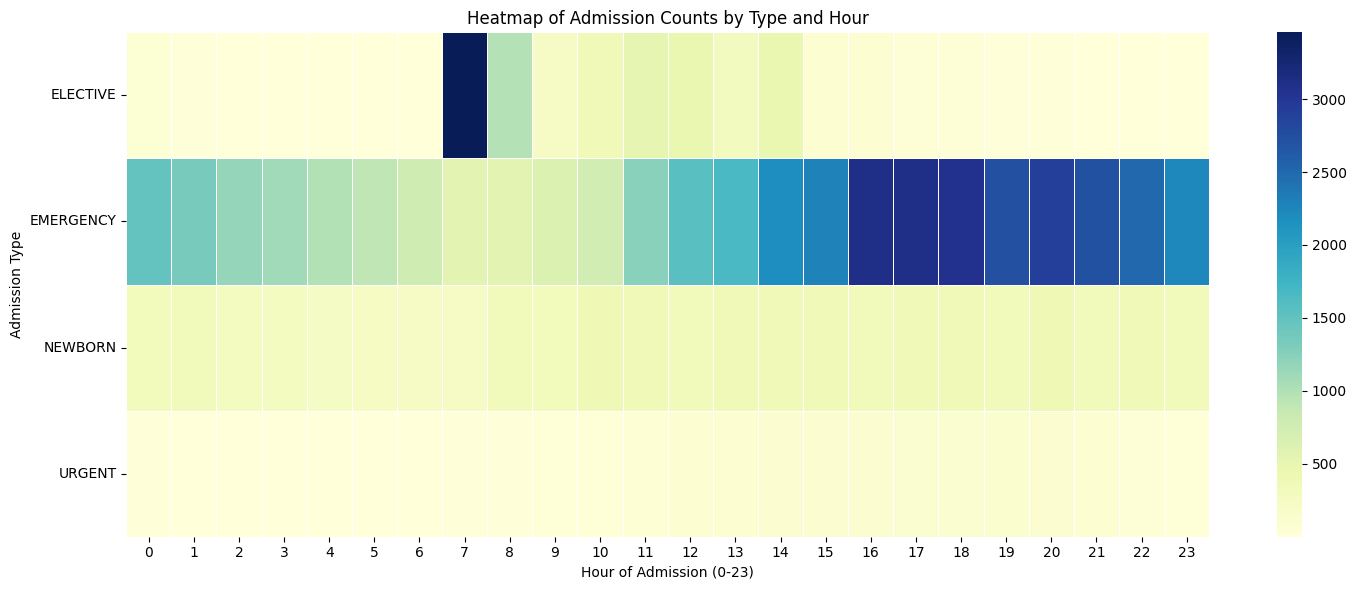


Pivoted Data for Heatmap:
ADMISSION_HOUR      0       1       2       3      4      5      6       7   \
ADMISSION_TYPE                                                                
ELECTIVE          70.0    20.0    12.0     9.0    2.0    4.0    6.0  3457.0   
EMERGENCY       1474.0  1348.0  1169.0  1095.0  989.0  917.0  778.0   552.0   
NEWBORN          324.0   330.0   265.0   282.0  236.0  245.0  226.0   229.0   
URGENT            23.0    14.0    12.0    10.0    4.0    8.0   13.0    23.0   

ADMISSION_HOUR     8      9   ...      14      15      16      17      18  \
ADMISSION_TYPE                ...                                           
ELECTIVE        986.0  222.0  ...   461.0    84.0    87.0    51.0    42.0   
EMERGENCY       554.0  643.0  ...  2184.0  2292.0  3111.0  3111.0  3077.0   
NEWBORN         347.0  320.0  ...   356.0   356.0   337.0   353.0   378.0   
URGENT           19.0   30.0  ...    98.0   101.0   104.0   111.0   111.0   

ADMISSION_HOUR      19      20     

In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
query = """
SELECT
    ADMISSION_TYPE,
    ADMISSION_HOUR,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ADMISSION_TYPE IS NOT NULL
    AND ADMISSION_HOUR IS NOT NULL
GROUP BY
    ADMISSION_TYPE,
    ADMISSION_HOUR
ORDER BY
    ADMISSION_TYPE,
    ADMISSION_HOUR;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_type_hour_df = client.query(query).to_dataframe()


adm_type_hour_df['count'] = pd.to_numeric(adm_type_hour_df['count'], errors='coerce')
# Ensure ADMISSION_HOUR is treated as a number
adm_type_hour_df['ADMISSION_HOUR'] = pd.to_numeric(adm_type_hour_df['ADMISSION_HOUR'], errors='coerce')
adm_type_hour_df.dropna(subset=['count', 'ADMISSION_HOUR'], inplace=True) # Drop rows where conversion failed



# 3. Create the visualization using Matplotlib and Seaborn
if not adm_type_hour_df.empty:
    try:
        # Pivot the data to create a matrix suitable for a heatmap
        heatmap_data = adm_type_hour_df.pivot(index='ADMISSION_TYPE', columns='ADMISSION_HOUR', values='count').fillna(0) # Fill missing combos with 0
        heatmap_data = heatmap_data.astype(float)

        plt.figure(figsize=(15, 6))

        # Create the heatmap
        sns.heatmap(heatmap_data, annot=False, fmt=".0f", linewidths=.5, cmap="YlGnBu")

        # Add labels and title
        plt.xlabel("Hour of Admission (0-23)")
        plt.ylabel("Admission Type")
        plt.title("Heatmap of Admission Counts by Type and Hour")
        plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

        # Display the plot
        plt.tight_layout()
        plt.show()

        # Display the pivoted data table
        print("\nPivoted Data for Heatmap:")
        print(heatmap_data)
        print("\nPivoted Data Types:")
        print(heatmap_data.dtypes)


    except Exception as e:
        print(f"An error occurred during plotting: {e}")
        print("\nOriginal DataFrame dtypes before pivot:")
        print(adm_type_hour_df.dtypes)
        if 'heatmap_data' in locals():
             print("\nPivoted DataFrame dtypes before plotting:")
             print(heatmap_data.dtypes)


else:
    print("No data returned from the query to plot.")

### **Conclusion**
By visualizing the heatmap, we can see that the `EMERGENCY` `Type of Admission` is very correlated with `Hour of Admission`, being much more common in the evening/night `16PM – 23PM`. The `Type of Admission` `ELECTIVE` is also correlated with `Hour of Admission`, being very common at `7AM`.

### **Type of Admission & Diagnosis**

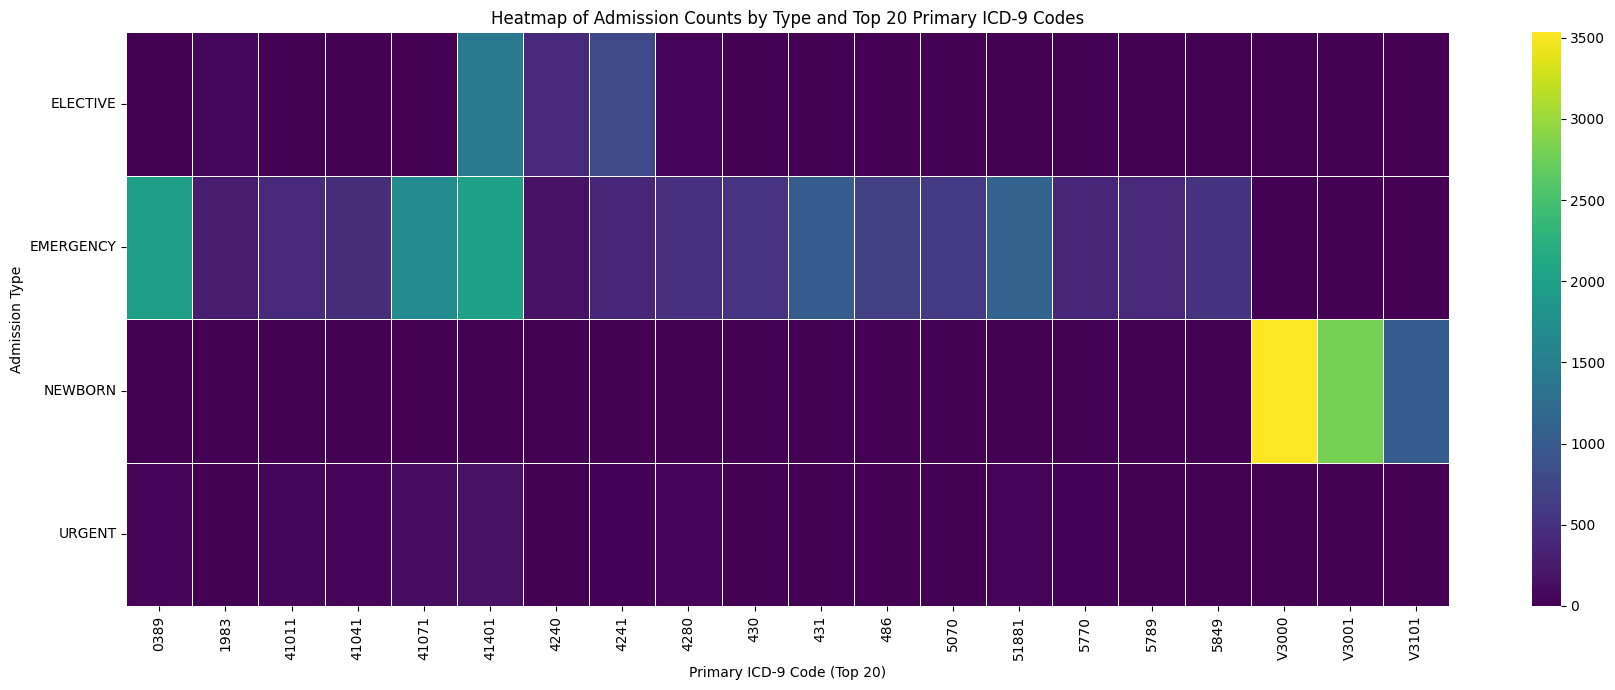

In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
#    First, find the top 20 most frequent ICD-9 codes, then get the counts
#    for combinations of ADMISSION_TYPE and those top codes.
query = """
WITH TopCodes AS (
    -- Subquery to find the top 20 most frequent primary ICD-9 codes
    SELECT
        PRIMARY_ICD9_CODE
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        PRIMARY_ICD9_CODE IS NOT NULL
    GROUP BY
        PRIMARY_ICD9_CODE
    ORDER BY
        COUNT(*) DESC
    LIMIT 20
)
-- Main query to count combinations for top codes and admission types
SELECT
    jt.ADMISSION_TYPE,
    jt.PRIMARY_ICD9_CODE,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table` jt
JOIN
    TopCodes tc ON jt.PRIMARY_ICD9_CODE = tc.PRIMARY_ICD9_CODE -- Join to filter for top codes
WHERE
    jt.ADMISSION_TYPE IS NOT NULL
GROUP BY
    jt.ADMISSION_TYPE,
    jt.PRIMARY_ICD9_CODE
ORDER BY
    jt.ADMISSION_TYPE,
    jt.PRIMARY_ICD9_CODE;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_type_icd9_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not adm_type_icd9_df.empty:
    heatmap_data = adm_type_icd9_df.pivot(index='ADMISSION_TYPE', columns='PRIMARY_ICD9_CODE', values='count').fillna(0) # Fill missing combos with 0

    plt.figure(figsize=(18, 7))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=False, fmt=".0f", linewidths=.5, cmap="viridis")

    plt.xlabel("Primary ICD-9 Code (Top 20)")
    plt.ylabel("Admission Type")
    plt.title("Heatmap of Admission Counts by Type and Top 20 Primary ICD-9 Codes")
    plt.xticks(rotation=90) # Rotate ICD codes for readability
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

    # Display the plot
    plt.tight_layout()
    plt.show()

else:
    print("No data returned from the query to plot.")

### **Conclusion**
There isn’t a clear connection between `Type of Admission` and `Diagnosis` with the exceptions being `V300 (Single liveborn, delivered in hospital, without cesarean section)` and `NEWBORN`, that have a higher correlation due to their obvious connection, and some diseases like `41071( Acute myocardial infarction, subendocardial infarction, initial episode of care)` with `EMERGENCY`, that have a low correlation.

### **Type of Admission & Death**

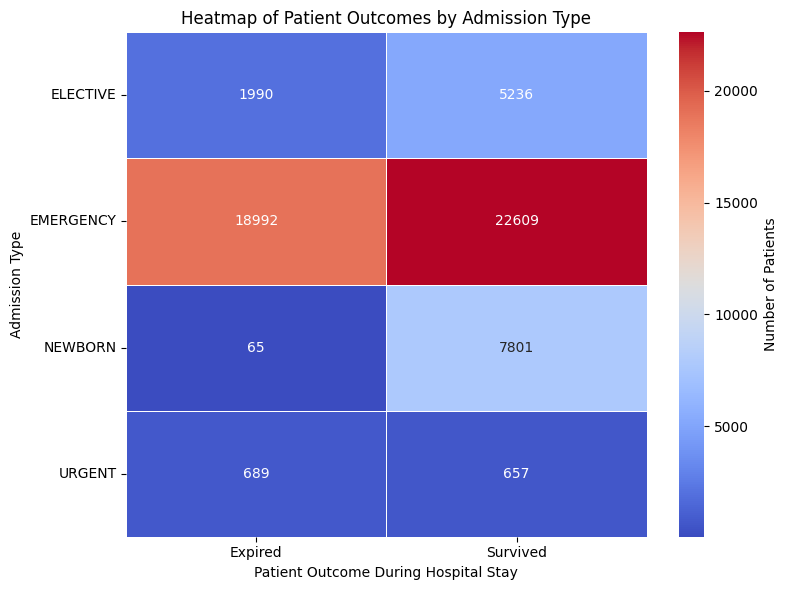


Pivoted Data for Heatmap:
Outcome         Expired  Survived
ADMISSION_TYPE                   
ELECTIVE         1990.0    5236.0
EMERGENCY       18992.0   22609.0
NEWBORN            65.0    7801.0
URGENT            689.0     657.0


In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
query = """
SELECT
    ADMISSION_TYPE,
    EXPIRE_FLAG,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    ADMISSION_TYPE IS NOT NULL
    AND EXPIRE_FLAG IS NOT NULL
GROUP BY
    ADMISSION_TYPE,
    EXPIRE_FLAG
ORDER BY
    ADMISSION_TYPE,
    EXPIRE_FLAG;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_type_expire_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not adm_type_expire_df.empty:
    # Map EXPIRE_FLAG to readable labels
    adm_type_expire_df['Outcome'] = adm_type_expire_df['EXPIRE_FLAG'].map({0: 'Survived', 1: 'Expired'})

    heatmap_data = adm_type_expire_df.pivot(index='ADMISSION_TYPE', columns='Outcome', values='count').fillna(0) # Fill missing combos with 0

    plt.figure(figsize=(8, 6))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", linewidths=.5, cmap="coolwarm", cbar_kws={'label': 'Number of Patients'})

    # Add labels and title
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("Admission Type")
    plt.title("Heatmap of Patient Outcomes by Admission Type")
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Display the pivoted data table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)

else:
    print("No data returned from the query to plot.")

### **Conclusion**
The clearest conclusion from this HeatMap is that patients who have `EMERGENCY` as their `Type of Admission` tend to `EXPIRE` much more frequently.

### **Admission Hour & Diagnosis**

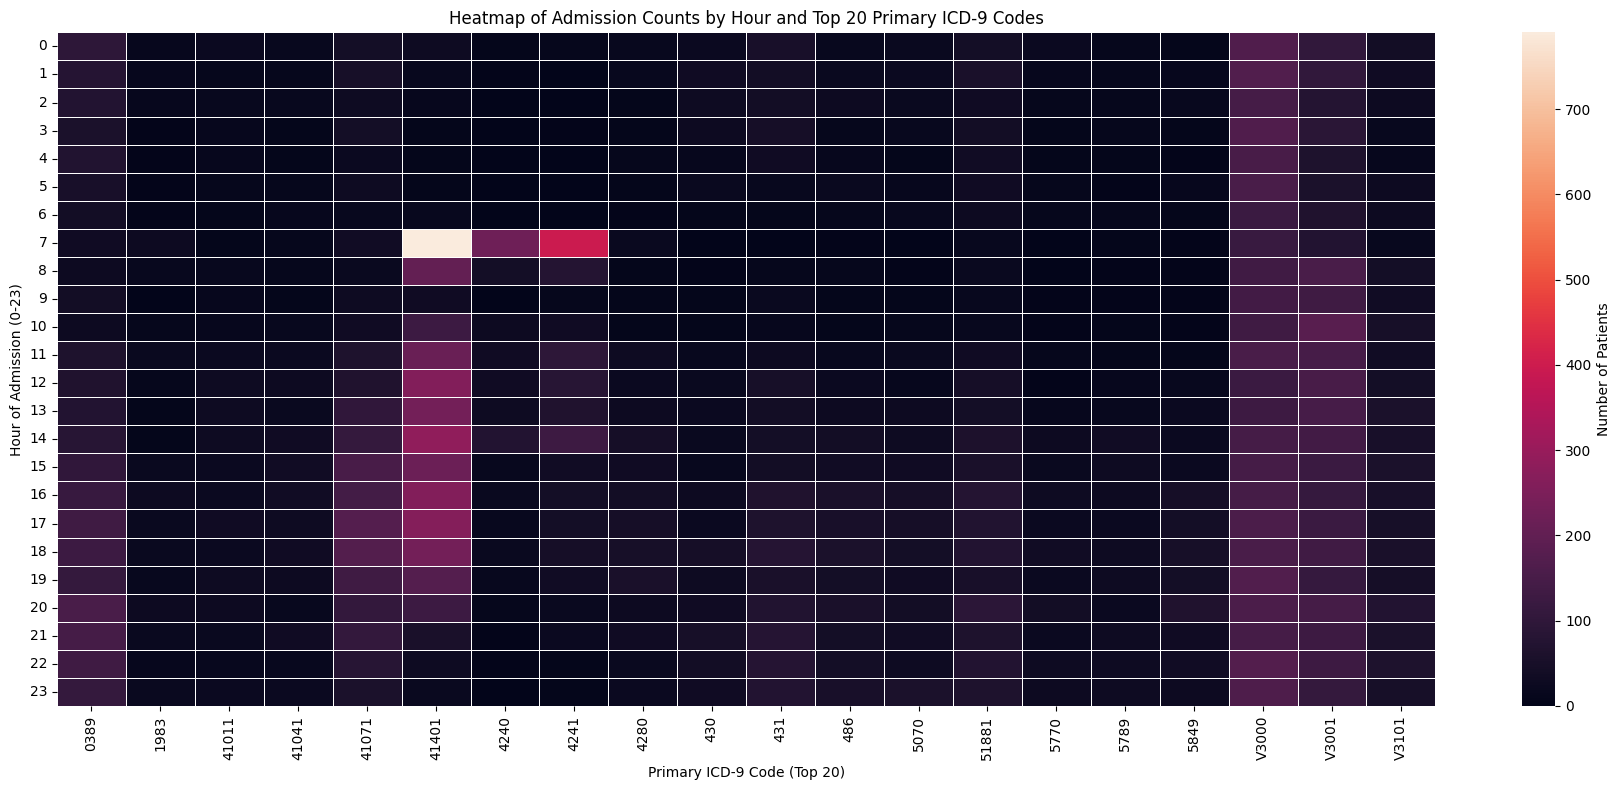


Pivoted Data for Heatmap:
PRIMARY_ICD9_CODE   0389  1983  41011  41041  41071  41401   4240   4241  \
ADMISSION_HOUR                                                             
0                   95.0  13.0   22.0   17.0   42.0   29.0    9.0   10.0   
1                   78.0  13.0   11.0   10.0   48.0   17.0    4.0    1.0   
2                   74.0  14.0   16.0   16.0   29.0   14.0    3.0    2.0   
3                   56.0   5.0   13.0    8.0   42.0    7.0    1.0    5.0   
4                   69.0   5.0   14.0    9.0   23.0    9.0    1.0    1.0   
5                   51.0   4.0   10.0   10.0   28.0    7.0    2.0    2.0   
6                   38.0   6.0    8.0   14.0   18.0   17.0    0.0    2.0   
7                   33.0  26.0    8.0   10.0   35.0  790.0  224.0  396.0   
8                   26.0  18.0   17.0   10.0   20.0  202.0   43.0   77.0   
9                   38.0   2.0   15.0    9.0   28.0   31.0    3.0   10.0   
10                  27.0  12.0   14.0   17.0   31.0  126.0   

In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
#    First, find the top 20 most frequent ICD-9 codes, then get the counts
#    for combinations of ADMISSION_HOUR and those top codes.
query = """
WITH TopCodes AS (
    -- Subquery to find the top 20 most frequent primary ICD-9 codes
    SELECT
        PRIMARY_ICD9_CODE
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        PRIMARY_ICD9_CODE IS NOT NULL
    GROUP BY
        PRIMARY_ICD9_CODE
    ORDER BY
        COUNT(*) DESC
    LIMIT 20
)
-- Main query to count combinations for top codes and admission hour
SELECT
    jt.ADMISSION_HOUR,
    jt.PRIMARY_ICD9_CODE,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table` jt
JOIN
    TopCodes tc ON jt.PRIMARY_ICD9_CODE = tc.PRIMARY_ICD9_CODE -- Join to filter for top codes
WHERE
    jt.ADMISSION_HOUR IS NOT NULL
GROUP BY
    jt.ADMISSION_HOUR,
    jt.PRIMARY_ICD9_CODE
ORDER BY
    jt.ADMISSION_HOUR,
    jt.PRIMARY_ICD9_CODE;
"""

# 2. Execute the query and load results into a Pandas DataFrame
adm_hour_icd9_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not adm_hour_icd9_df.empty:
    heatmap_data = adm_hour_icd9_df.pivot(index='ADMISSION_HOUR', columns='PRIMARY_ICD9_CODE', values='count').fillna(0) # Fill missing combos with 0

    plt.figure(figsize=(18, 8))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=False, fmt=".0f", linewidths=.5, cmap="rocket", cbar_kws={'label': 'Number of Patients'})

    # Add labels and title
    plt.xlabel("Primary ICD-9 Code (Top 20)")
    plt.ylabel("Hour of Admission (0-23)")
    plt.title("Heatmap of Admission Counts by Hour and Top 20 Primary ICD-9 Codes")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Display the pivoted data table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)

else:
    print("No data returned from the query to plot.")

### **Conclusion**
The distribution of the correlation between `Diagnosis` and `Hour of Admission` is very uniform. Some interesting outliers are `41401 (Coronary atherosclerosis of native coronary artery)`  and `4241 (Aortic valve disorders)` with `7 AM`.

### **First Care Unit & Diagnosis**

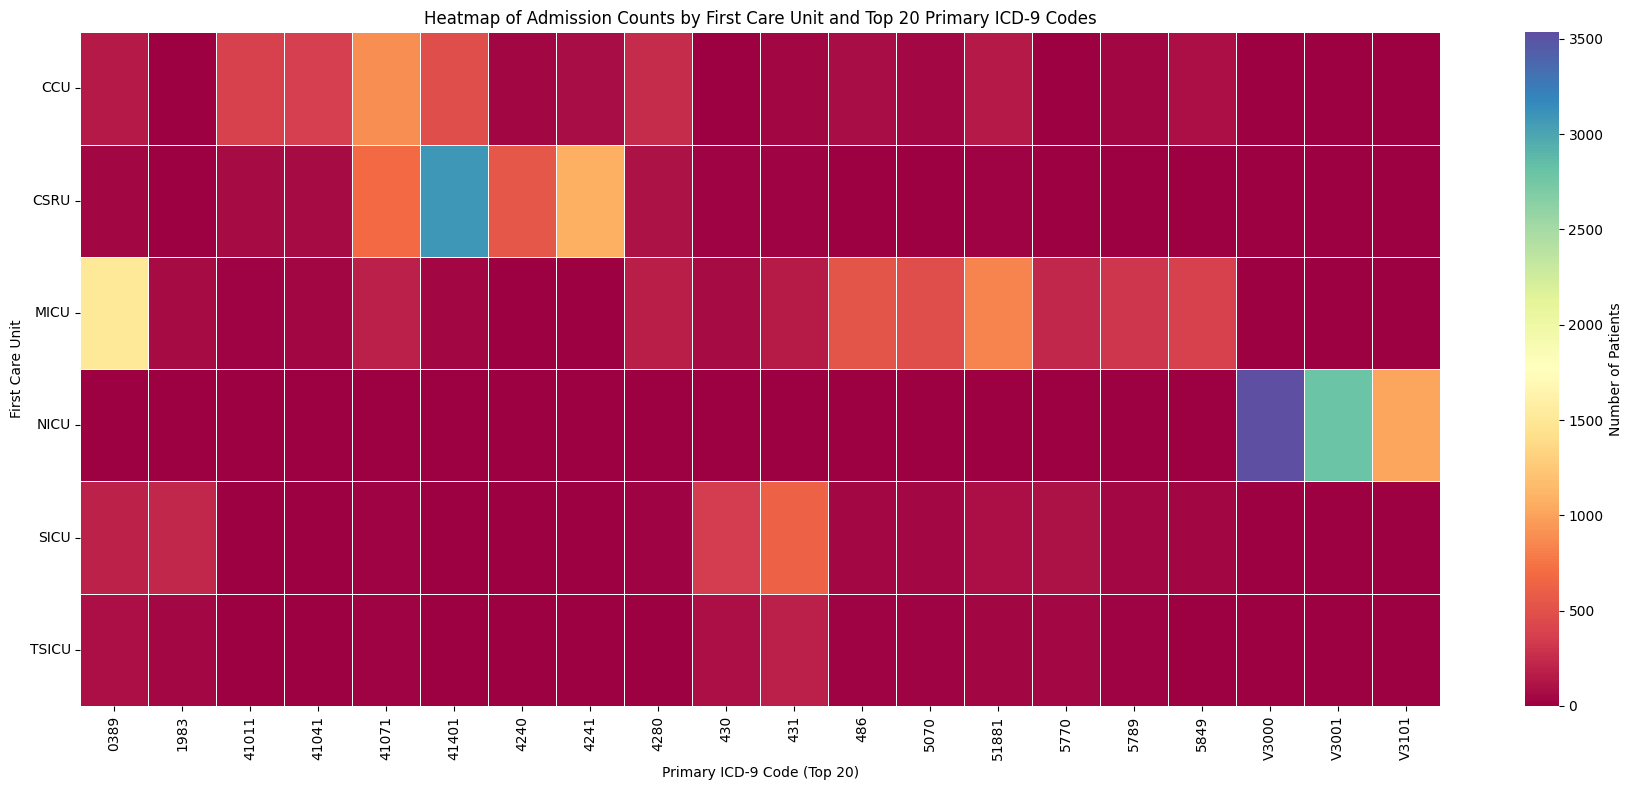


Pivoted Data for Heatmap:
PRIMARY_ICD9_CODE    0389   1983  41011  41041  41071   41401   4240    4241  \
FIRST_CAREUNIT                                                                 
CCU                 150.0    4.0  379.0  371.0  885.0   476.0   37.0    80.0   
CSRU                 31.0    4.0   62.0   67.0  684.0  3092.0  550.0  1075.0   
MICU               1509.0   59.0   27.0   28.0  187.0    38.0    4.0     9.0   
NICU                  0.0    0.0    0.0    0.0    0.0     0.0    0.0     0.0   
SICU                207.0  226.0    1.0    2.0   27.0     6.0    1.0     3.0   
TSICU                91.0   50.0    4.0    3.0   20.0     5.0    0.0     1.0   

PRIMARY_ICD9_CODE   4280    430    431    486   5070  51881   5770   5789  \
FIRST_CAREUNIT                                                              
CCU                251.0   13.0   39.0   74.0   45.0  141.0   13.0   29.0   
CSRU               107.0   18.0   14.0   11.0   12.0   22.0    7.0    9.0   
MICU               173.0

In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
#    First, find the top 20 most frequent ICD-9 codes, then get the counts
#    for combinations of FIRST_CAREUNIT and those top codes.
query = """
WITH TopCodes AS (
    -- Subquery to find the top 20 most frequent primary ICD-9 codes
    SELECT
        PRIMARY_ICD9_CODE
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        PRIMARY_ICD9_CODE IS NOT NULL
    GROUP BY
        PRIMARY_ICD9_CODE
    ORDER BY
        COUNT(*) DESC
    LIMIT 20
)
-- Main query to count combinations for top codes and first care unit
SELECT
    jt.FIRST_CAREUNIT,
    jt.PRIMARY_ICD9_CODE,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table` jt
JOIN
    TopCodes tc ON jt.PRIMARY_ICD9_CODE = tc.PRIMARY_ICD9_CODE -- Join to filter for top codes
WHERE
    jt.FIRST_CAREUNIT IS NOT NULL
GROUP BY
    jt.FIRST_CAREUNIT,
    jt.PRIMARY_ICD9_CODE
ORDER BY
    jt.FIRST_CAREUNIT,
    jt.PRIMARY_ICD9_CODE;
"""

# 2. Execute the query and load results into a Pandas DataFrame
careunit_icd9_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not careunit_icd9_df.empty:
    heatmap_data = careunit_icd9_df.pivot(index='FIRST_CAREUNIT', columns='PRIMARY_ICD9_CODE', values='count').fillna(0) # Fill missing combos with 0

    plt.figure(figsize=(18, 8))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=False, fmt=".0f", linewidths=.5, cmap="Spectral", cbar_kws={'label': 'Number of Patients'})

    # Add labels and title
    plt.xlabel("Primary ICD-9 Code (Top 20)")
    plt.ylabel("First Care Unit")
    plt.title("Heatmap of Admission Counts by First Care Unit and Top 20 Primary ICD-9 Codes")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Display the pivoted data table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)

else:
    print("No data returned from the query to plot.")

### **Conclusion**
The strongest connections between `First Care Unit` and `Diagnosis` are `V3000 (Single liveborn, delivered in hospital, without cesarean section)` and `NICU (Neonatal Intensive Care Unit)` and `41401 (Coronary atherosclerosis of native coronary artery)` and  `CSRU (Cardiac Surgery Recovery Unit)`.

### **First Care Unit & Death**

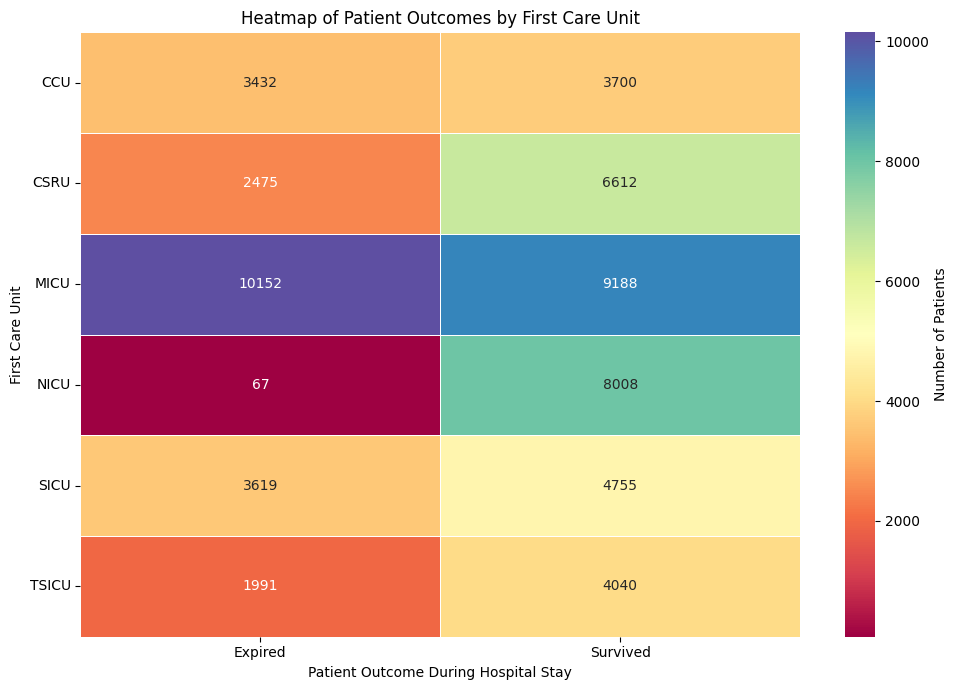


Pivoted Data for Heatmap:
Outcome         Expired  Survived
FIRST_CAREUNIT                   
CCU              3432.0    3700.0
CSRU             2475.0    6612.0
MICU            10152.0    9188.0
NICU               67.0    8008.0
SICU             3619.0    4755.0
TSICU            1991.0    4040.0
Query Execution Time: 2.20 seconds


In [ ]:
start_time = time.time()

# 1. Define the BigQuery SQL query to get counts for each combination
query = """
SELECT
    FIRST_CAREUNIT,
    EXPIRE_FLAG,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table`
WHERE
    FIRST_CAREUNIT IS NOT NULL
    AND EXPIRE_FLAG IS NOT NULL
GROUP BY
    FIRST_CAREUNIT,
    EXPIRE_FLAG
ORDER BY
    FIRST_CAREUNIT,
    EXPIRE_FLAG;
"""

# 2. Execute the query and load results into a Pandas DataFrame
careunit_expire_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not careunit_expire_df.empty:
    # Map EXPIRE_FLAG to readable labels
    careunit_expire_df['Outcome'] = careunit_expire_df['EXPIRE_FLAG'].map({0: 'Survived', 1: 'Expired'})

    heatmap_data = careunit_expire_df.pivot(index='FIRST_CAREUNIT', columns='Outcome', values='count').fillna(0) # Fill missing combos with 0

    plt.figure(figsize=(10, 7))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", linewidths=.5, cmap="Spectral", cbar_kws={'label': 'Number of Patients'})

    # Add labels and title
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("First Care Unit")
    plt.title("Heatmap of Patient Outcomes by First Care Unit")
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Display the pivoted data table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)

else:
    print("No data returned from the query to plot.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
The distributions of patients by gender is fairly simetric, with a slight imbalance for `MALE` (~56.0%).

There is no discernible connection between `Gender` and `Length of ICU Stay`.

### **Diagnosis & Death**

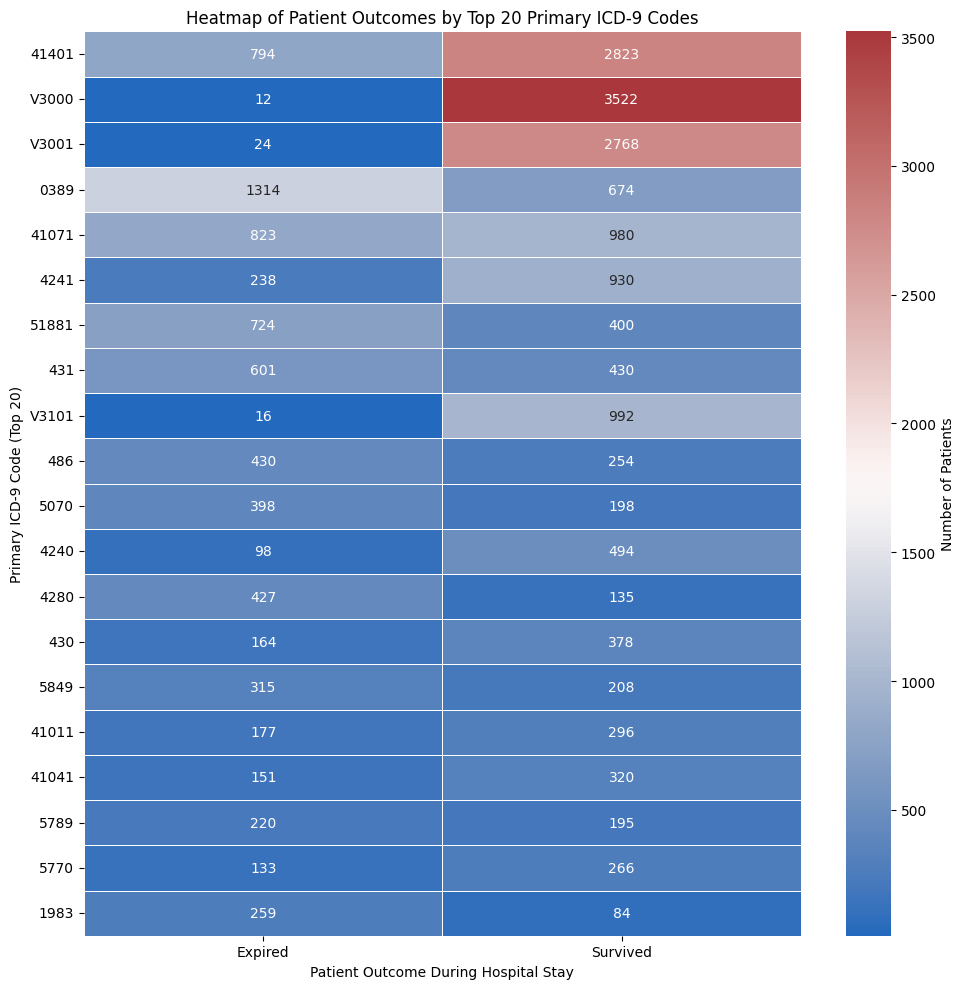


Pivoted Data for Heatmap:
Outcome            Expired  Survived
PRIMARY_ICD9_CODE                   
41401                794.0    2823.0
V3000                 12.0    3522.0
V3001                 24.0    2768.0
0389                1314.0     674.0
41071                823.0     980.0
4241                 238.0     930.0
51881                724.0     400.0
431                  601.0     430.0
V3101                 16.0     992.0
486                  430.0     254.0
5070                 398.0     198.0
4240                  98.0     494.0
4280                 427.0     135.0
430                  164.0     378.0
5849                 315.0     208.0
41011                177.0     296.0
41041                151.0     320.0
5789                 220.0     195.0
5770                 133.0     266.0
1983                 259.0      84.0


In [ ]:
# 1. Define the BigQuery SQL query to get counts for each combination
#    First, find the top 20 most frequent ICD-9 codes, then get the counts
#    for combinations of those top codes and EXPIRE_FLAG.
query = """
WITH TopCodes AS (
    -- Subquery to find the top 20 most frequent primary ICD-9 codes
    SELECT
        PRIMARY_ICD9_CODE
    FROM
        `reliable-jet-452114-s2.table.junction_table`
    WHERE
        PRIMARY_ICD9_CODE IS NOT NULL
    GROUP BY
        PRIMARY_ICD9_CODE
    ORDER BY
        COUNT(*) DESC
    LIMIT 20
)
-- Main query to count combinations for top codes and expire flag
SELECT
    jt.PRIMARY_ICD9_CODE,
    jt.EXPIRE_FLAG,
    COUNT(*) AS count
FROM
    `reliable-jet-452114-s2.table.junction_table` jt
JOIN
    TopCodes tc ON jt.PRIMARY_ICD9_CODE = tc.PRIMARY_ICD9_CODE -- Join to filter for top codes
WHERE
    jt.EXPIRE_FLAG IS NOT NULL
GROUP BY
    jt.PRIMARY_ICD9_CODE,
    jt.EXPIRE_FLAG
ORDER BY
    jt.PRIMARY_ICD9_CODE,
    jt.EXPIRE_FLAG;
"""

# 2. Execute the query and load results into a Pandas DataFrame
icd9_expire_df = client.query(query).to_dataframe()

# 3. Create the visualization using Matplotlib and Seaborn
if not icd9_expire_df.empty:
    # Map EXPIRE_FLAG to readable labels
    icd9_expire_df['Outcome'] = icd9_expire_df['EXPIRE_FLAG'].map({0: 'Survived', 1: 'Expired'})

    heatmap_data = icd9_expire_df.pivot(index='PRIMARY_ICD9_CODE', columns='Outcome', values='count').fillna(0) # Fill missing combos with 0

    # Reindex based on total frequency
    total_counts = icd9_expire_df.groupby('PRIMARY_ICD9_CODE')['count'].sum().sort_values(ascending=False)
    heatmap_data = heatmap_data.reindex(total_counts.index)

    plt.figure(figsize=(10, 10))

    # Create the heatmap
    heatmap_data = heatmap_data.astype(float)
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", linewidths=.5, cmap="vlag", cbar_kws={'label': 'Number of Patients'})

    # Add labels and title
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("Primary ICD-9 Code (Top 20)")
    plt.title("Heatmap of Patient Outcomes by Top 20 Primary ICD-9 Codes")
    plt.yticks(rotation=0) # Ensure y-axis labels are horizontal
    plt.xticks(rotation=0)

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Display the pivoted data table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)

else:
    print("No data returned from the query to plot.")

### **Conclusion**
The HeatMap that compares `Diagnosis` and `Death` is fairly uniform, with newborns counting the lowest deaths (as expected).

# **XGBoost Classifier Predictor Model**
In this section we use a `XGBoost Classifier` model to predict the `ICU Length of Stay`, that we divide in bins of two days ([1-3] days, [3-5] days, ...).
The `window size` we chose was `1 day` (24 hours), given that most data is collected in that window and most records have a value of `ICU Length of Stay` lower than 3 days, which means a bigger window size would exclude most of the data.
We divided this section of the work in 2 parts:
1. Dividing the dataset, Categorizing the Target and Implementing Custom Sample Weights
2. Pre-Processing the features
3. Applying the model
4. Visualizing the results

The discussion of results was done in the final conclusions.



## **Dividing the Dataset, Categorizing the Target and Implementing Custom Sample Weights**
Here we will divide the dataset in Train, Test and Validation.
We will do this by:
1. Eliminating the features that are only collected after the first 24 hours (our `window size`) or are not relevant
2. Removing the records whose value for `ICU Length of Stay` is lower than 24 hours
3. Using the library `scikit-learn` to perform the division
4. Converting the target feature from `continuous values` to `bins`
5. Calculating the custom sample weights to ensure a less biased prediction towards the majority class
6. Normalizing the sample weights

In [4]:
# --- Record Start Time ---
start_time = time.time()

# --- Configuration ---
TARGET_TABLE = "reliable-jet-452114-s2.table.junction_table"
TARGET_VARIABLE = 'ICU_LOS'
WINDOW_DAYS = 1.0      # Minimum ICU stay to be included
MAX_ICU_LOS_DAYS = 25.0 # Maximum ICU stay to be included
BIN_WIDTH = 2.0        # Width of each LOS category
TEST_SIZE = 0.10
VALIDATION_SIZE = 0.10
CUSTOM_WEIGHT_ALPHA = 0.8 # Tunable parameter for custom weighting

# --- 1. Load Data from BigQuery ---
print("--- Block 1: Dividing Dataset, Target Categorization & CUSTOM Sample Weights ---")
try:
    load_query = f"SELECT * FROM `{TARGET_TABLE}`"
    full_df = client.query(load_query).to_dataframe()
    print(f"Loaded {len(full_df)} rows from {TARGET_TABLE}.")
except Exception as e:
    print(f"Error loading data from BigQuery: {e}")
    full_df = pd.DataFrame()

if not full_df.empty:
    original_row_count = len(full_df)
    print(f"Original row count: {original_row_count}")

    df_min_filtered = full_df[full_df[TARGET_VARIABLE] >= WINDOW_DAYS].copy()
    rows_after_min_los_filter = len(df_min_filtered)
    print(f"Rows remaining after MIN LOS filter (>= {WINDOW_DAYS} days): {rows_after_min_los_filter}")

    filtered_df = df_min_filtered[df_min_filtered[TARGET_VARIABLE] <= MAX_ICU_LOS_DAYS].copy()
    rows_after_max_los_filter = len(filtered_df)
    print(f"Rows remaining after MAX LOS filter (<= {MAX_ICU_LOS_DAYS} days): {rows_after_max_los_filter}")

    if rows_after_max_los_filter > 0:
        features_to_exclude = [
            'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB',
            'ADMITTIME', 'DISCHTIME', 'ICU_INTIME', 'ICU_OUTTIME',
            'PRIMARY_ICD9_TITLE', 'EXPIRE_FLAG'
        ]
        features_for_training_initial = [
            col for col in filtered_df.columns
            if col not in features_to_exclude and col != TARGET_VARIABLE
        ]
        print(f"Initial features considered for training: {features_for_training_initial}")

        X = filtered_df[features_for_training_initial]
        y_continuous = filtered_df[TARGET_VARIABLE]

        if len(X) < 3:
             print("Not enough data to perform train-validation-test split after all filtering.")
             X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
             y_train_cat, y_val_cat, y_test_cat = pd.Series(dtype=int), pd.Series(dtype=int), pd.Series(dtype=int)
             train_sample_weights = np.array([])
             num_classes = 1
        else:
            train_val_size = 1.0 - TEST_SIZE
            X_train_val, X_test, y_train_val_continuous, y_test_continuous = train_test_split(
                X, y_continuous, test_size=TEST_SIZE, random_state=42, shuffle=True
            )
            validation_split_ratio_for_temp = VALIDATION_SIZE / train_val_size if train_val_size > 0 else 0

            if len(X_train_val) < 2 or validation_split_ratio_for_temp == 0:
                print("Not enough data in train_val set to split into train and validation or invalid ratio. Using train_val as train.")
                X_train, X_val, y_train_continuous, y_val_continuous = X_train_val, pd.DataFrame(), y_train_val_continuous, pd.Series(dtype=float)
            else:
                X_train, X_val, y_train_continuous, y_val_continuous = train_test_split(
                    X_train_val, y_train_val_continuous, test_size=validation_split_ratio_for_temp, random_state=42, shuffle=True
                )

            def convert_los_to_categories(los_series, bin_width, min_los):
                if los_series.empty:
                    return pd.Series([], dtype=int)
                adjusted_los = los_series - min_los
                categories = np.floor(adjusted_los / bin_width).astype(int)
                categories = np.maximum(0, categories)
                return categories

            y_train_cat = convert_los_to_categories(y_train_continuous, bin_width=BIN_WIDTH, min_los=WINDOW_DAYS)
            y_val_cat   = convert_los_to_categories(y_val_continuous, bin_width=BIN_WIDTH, min_los=WINDOW_DAYS)
            y_test_cat  = convert_los_to_categories(y_test_continuous, bin_width=BIN_WIDTH, min_los=WINDOW_DAYS)

            all_cats = pd.concat([y_train_cat, y_val_cat, y_test_cat]).dropna().astype(int)
            if all_cats.empty:
                print("Warning: No categories found in target variable after splitting and conversion. Defaulting num_classes to 1.")
                num_classes = 1
                max_cat_overall = 0
                train_sample_weights = np.array([])
            else:
                max_cat_overall = all_cats.max()
                num_classes = max_cat_overall + 1

                if not y_train_cat.empty:
                    print(f"\n--- Calculating CUSTOM Sample Weights (alpha={CUSTOM_WEIGHT_ALPHA}) ---")
                    class_counts = Counter(y_train_cat)
                    total_samples = len(y_train_cat)

                    # Calculate custom class weights
                    class_weights_map = {}
                    for class_label, count in class_counts.items():
                        if count > 0: # Ensure count is positive
                            # Using raw count in the denominator for simplicity
                            weight = 1.0 / (count ** CUSTOM_WEIGHT_ALPHA)
                            class_weights_map[class_label] = weight
                        else:
                            class_weights_map[class_label] = 1.0

                    print(f"Custom class weights map: {class_weights_map}")

                    # Generate sample weights for each training instance
                    train_sample_weights = np.array([class_weights_map.get(cls, 1.0) for cls in y_train_cat])

                    # Normalize sample weights so their sum equals the number of samples
                    train_sample_weights = (train_sample_weights / np.sum(train_sample_weights)) * total_samples

                    print(f"Computed CUSTOM sample weights for y_train_cat. Shape: {train_sample_weights.shape}")
                    unique_weights, counts = np.unique(train_sample_weights, return_counts=True)
                    print(f"Unique custom sample weights and their counts in training data: {dict(zip(unique_weights, counts))}")
                else:
                    train_sample_weights = np.array([])
                    print("y_train_cat is empty, no sample weights computed.")

            print(f"\nTarget variable converted to {num_classes} categories (0 to {max_cat_overall}).")
            if not y_train_cat.empty: print(f"Unique categories in y_train_cat: {sorted(y_train_cat.unique())}")
            if not y_val_cat.empty:   print(f"Unique categories in y_val_cat:   {sorted(y_val_cat.unique())}")
            if not y_test_cat.empty:  print(f"Unique categories in y_test_cat:  {sorted(y_test_cat.unique())}")

            print("\nDataset shapes:")
            print(f"X_train: {X_train.shape}, y_train_cat: {y_train_cat.shape}")
            if not X_val.empty: print(f"X_val:   {X_val.shape}, y_val_cat:   {y_val_cat.shape}")
            else: print("X_val is empty.")
            print(f"X_test:  {X_test.shape}, y_test_cat:  {y_test_cat.shape}")

            if original_row_count > 0:
                percentage_kept_overall = (rows_after_max_los_filter / original_row_count) * 100
                print(f"\nPercentage of original records kept after ALL filtering: {percentage_kept_overall:.2f}%")
    else:
        print("No data remaining after all filtering. Cannot proceed.")
        X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        y_train_cat, y_val_cat, y_test_cat = pd.Series(dtype=int), pd.Series(dtype=int), pd.Series(dtype=int)
        features_for_training_initial = []
        train_sample_weights = np.array([])
        num_classes = 1
else:
    print("Data loading failed or table was empty. Cannot proceed.")
    X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_cat, y_val_cat, y_test_cat = pd.Series(dtype=int), pd.Series(dtype=int), pd.Series(dtype=int)
    features_for_training_initial = []
    train_sample_weights = np.array([])
    num_classes = 1

# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")

--- Block 1: Dividing Dataset, Target Categorization & CUSTOM Sample Weights ---
Loaded 58039 rows from reliable-jet-452114-s2.table.junction_table.
Original row count: 58039
Rows remaining after MIN LOS filter (>= 1.0 days): 46321
Rows remaining after MAX LOS filter (<= 25.0 days): 44439
Initial features considered for training: ['GENDER', 'AGE_AT_ADMISSION', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'ETHNICITY', 'ADMISSION_DIAGNOSIS_TEXT', 'ADMISSION_HOUR', 'FIRST_CAREUNIT', 'PRIMARY_ICD9_CODE']

--- Calculating CUSTOM Sample Weights (alpha=0.8) ---
Custom class weights map: {1: 0.0008837269036497867, 0: 0.0003628979779803216, 2: 0.0016682574871599298, 7: 0.007055908051730422, 5: 0.004504175899347122, 11: 0.012811784118365512, 4: 0.003562410621944747, 3: 0.0025666245599461337, 6: 0.0054845393635214, 8: 0.008543413297975137, 9: 0.010266510574570422, 10: 0.012552737133001474}
Computed CUSTOM sample weights for y_train_cat. Shape: (35551,)
Unique custom sample weights and the

## **Pre-Processing the Features**
Here we will pre-process the features before applying the predictor model.
We will do this by:
1. Defining the features to be used in training and their respective category
2. Feature enginner the features based on their category:
  - `Scale` for `Continuous Numerical` features
  - `Encode using sin and cos` for `Cyclical Numerical` features
  - `One-hot Encode` for `Low/Medium Cardinality Categorical` Features
  - `Dictifier Transformation` followed by a `FeatureHasher Transformation` for `High Cardinality Categorical` features

In [5]:
# --- Record Start Time ---
start_time = time.time()
print("\n--- Block 2: Pre-Processing the Features ---")

# If X_train is empty, skip preprocessing
if 'X_train' in globals() and not X_train.empty:

    # --- 1. Define Feature Lists (based on X_train columns) ---

    _features_for_training = [
        'AGE_AT_ADMISSION',     # Numerical continuous
        'ADMISSION_TYPE',       # Categorical low cardinality
        'INSURANCE',            # Categorical low cardinality
        'PRIMARY_ICD9_CODE',    # Categorical high cardinality
        'FIRST_CAREUNIT',       # Categorical low cardinality
        'ADMISSION_HOUR'        # Numerical cyclical
    ]
    # Filter features to only those present in the training data from Block 1
    features_for_training_final = [f for f in _features_for_training if f in X_train.columns]
    print(f"Features selected for preprocessing: {features_for_training_final}")


    numerical_cont_features = [f for f in ['AGE_AT_ADMISSION'] if f in features_for_training_final]
    numerical_cycl_features = [f for f in ['ADMISSION_HOUR'] if f in features_for_training_final] # e.g., 0-23
    categorical_low_card_features = [f for f in ['ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT'] if f in features_for_training_final]
    categorical_high_card_features = [f for f in ['PRIMARY_ICD9_CODE'] if f in features_for_training_final]

    print(f"Continuous numerical features: {numerical_cont_features}")
    print(f"Cyclical numerical features: {numerical_cycl_features}")
    print(f"Low/Medium cardinality categorical features: {categorical_low_card_features}")
    print(f"High cardinality categorical features: {categorical_high_card_features}")

    # --- 2. Feature Engineering & Preprocessing Pipeline Components ---

    # a) Continuous Numerical Features: Scale
    numerical_cont_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # b) Cyclical Numerical Features: Encode hour using sine and cosine
    def sin_transformer(X_in):
        # Ensure input is 2D for FunctionTransformer
        X_proc = X_in.copy()
        if isinstance(X_proc, pd.Series): X_proc = X_proc.to_frame()
        elif X_proc.ndim == 1: X_proc = X_proc.reshape(-1, 1)
        return np.sin(2 * np.pi * X_proc / 24.0)

    def cos_transformer(X_in):
        X_proc = X_in.copy()
        if isinstance(X_proc, pd.Series): X_proc = X_proc.to_frame()
        elif X_proc.ndim == 1: X_proc = X_proc.reshape(-1, 1)
        return np.cos(2 * np.pi * X_proc / 24.0)

    # c) Low/Medium Cardinality Categorical Features: One-hot encode
    categorical_low_card_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # d) High Cardinality Categorical Features: Feature Hashing
    # Custom Transformer for FeatureHasher Input
    class Dictifier(BaseEstimator, TransformerMixin):
        def __init__(self, col_name):
            self.col_name = col_name
        def fit(self, X, y=None):
            return self
        def transform(self, X_in):
            # X_in is expected to be a DataFrame/Series for the specific column
            if isinstance(X_in, pd.DataFrame): series = X_in.iloc[:, 0]
            elif isinstance(X_in, pd.Series): series = X_in
            else: series = pd.Series(X_in.flatten()) # Fallback for numpy array
            return [{self.col_name: str(val)} for val in series]

    # --- Create the list of transformers for ColumnTransformer ---
    transformers_list = []

    if numerical_cont_features:
        transformers_list.append(('num_cont', numerical_cont_transformer, numerical_cont_features))
    if numerical_cycl_features: # Assuming only one cyclical feature 'ADMISSION_HOUR' for this example
        transformers_list.append(('hour_sin', FunctionTransformer(sin_transformer, validate=False), numerical_cycl_features))
        transformers_list.append(('hour_cos', FunctionTransformer(cos_transformer, validate=False), numerical_cycl_features))
    if categorical_low_card_features:
        transformers_list.append(('cat_low', categorical_low_card_transformer, categorical_low_card_features))

    if categorical_high_card_features:
        n_hash_features = 50 # Number of features for the hasher, adjust as needed
        for i, col_name in enumerate(categorical_high_card_features):
            print(f"  - Adding hasher for high-cardinality feature: {col_name}")
            transformer_name = f'cat_high_{col_name.replace(" ", "_").lower()}' # Unique name
            high_card_pipeline = Pipeline(steps=[
                ('dictifier', Dictifier(col_name=col_name)),
                ('hasher', FeatureHasher(n_features=n_hash_features, input_type='dict'))
            ])
            transformers_list.append((transformer_name, high_card_pipeline, [col_name])) # Pass as list
    else:
        print("No high cardinality features specified or found for hashing.")

    # --- Define the main ColumnTransformer ---
    if transformers_list:
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop', # Drop any columns not specified in features_for_training_final
            n_jobs=-1
        )
        print("Preprocessor defined.")
    else:
        print("No features to preprocess. Preprocessor not created.")
        preprocessor = 'passthrough' # Or handle as an error/empty pipeline

else:
    print("X_train is empty or not defined. Skipping feature preprocessing.")
    features_for_training_final = []
    preprocessor = 'passthrough' # To avoid error in next block

# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")


--- Block 2: Pre-Processing the Features ---
Features selected for preprocessing: ['AGE_AT_ADMISSION', 'ADMISSION_TYPE', 'INSURANCE', 'PRIMARY_ICD9_CODE', 'FIRST_CAREUNIT', 'ADMISSION_HOUR']
Continuous numerical features: ['AGE_AT_ADMISSION']
Cyclical numerical features: ['ADMISSION_HOUR']
Low/Medium cardinality categorical features: ['ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT']
High cardinality categorical features: ['PRIMARY_ICD9_CODE']
  - Adding hasher for high-cardinality feature: PRIMARY_ICD9_CODE
Preprocessor defined.

Execution time: 0.00 seconds


## **Applying the XGBoost Classifier Model**
Here we will apply the `XGBoost` model to the dataset.
We will do this by:

1. Defining the model pipeline
2. Training the model
3. Making predictions using the trained model
4. Post-Process predictions

In [7]:
# --- Record Start Time ---
start_time_block3_weighted = time.time()
print("\n--- Block 3: Applying the XGBoost Model (Classification) - MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS ---")

# Ensure necessary variables are available
if ('X_train' not in globals() or X_train.empty or
    'y_train_cat' not in globals() or y_train_cat.empty or
    'preprocessor' not in globals() or
    'features_for_training_final' not in globals() or
    'num_classes' not in globals() or
    'train_sample_weights' not in globals()):
    print("Necessary data (X_train, y_train_cat, preprocessor, features, num_classes, train_sample_weights) not available or y_train_cat is empty. Skipping model training.")
    y_pred_val_final = pd.Series(dtype=int)
    y_pred_test_final = pd.Series(dtype=int)
    xgb_model_pipeline = None
    fitted_pipeline_preprocessor = None
    fitted_pipeline_classifier = None
else:
    if y_train_cat.empty:
        print("  y_train_cat is EMPTY. Cannot proceed with model training.")
        xgb_model_pipeline = None
        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
    elif train_sample_weights is None or train_sample_weights.size == 0:
        print("  train_sample_weights is None or empty. Cannot proceed with weighted training.")
        xgb_model_pipeline = None
        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
    else:
        print(f"  y_train_cat.shape: {y_train_cat.shape}, dtype: {y_train_cat.dtype}")
        if y_train_cat.isnull().any():
            print(f"  WARNING: y_train_cat contains NaNs! Count: {y_train_cat.isnull().sum()}")
        y_train_cat = y_train_cat.astype(int) # Ensure it's int
        print(f"  Type of target (y_train_cat): {type_of_target(y_train_cat)}")
        print(f"  y_train_cat.min(): {y_train_cat.min()}, y_train_cat.max(): {y_train_cat.max()}")

        current_X_train_cols = X_train.columns.tolist()
        valid_features_for_model = [f for f in features_for_training_final if f in current_X_train_cols]
        if not valid_features_for_model:
            print("WARNING: No valid features for model found in X_train. Preprocessing might be incorrect or use no features.")

        X_train_processed_standalone = None
        try:
            if preprocessor == 'passthrough':
                X_train_processed_standalone = X_train[valid_features_for_model].copy() if valid_features_for_model else X_train.copy()
            elif hasattr(preprocessor, 'fit_transform'):
                temp_preprocessor_standalone = clone(preprocessor)
                print("  Fitting and transforming X_train with a cloned preprocessor for standalone test...")
                X_train_processed_standalone = temp_preprocessor_standalone.fit_transform(X_train[valid_features_for_model])
                print(f"  X_train_processed_standalone shape: {X_train_processed_standalone.shape}")
            else:
                 print("  Preprocessor is not 'passthrough' and does not have 'fit_transform'. Cannot preprocess for standalone test.")
        except Exception as e_preprocess_standalone:
            print(f"  ERROR during X_train preprocessing for standalone test: {e_preprocess_standalone}")

        if X_train_processed_standalone is not None:
            standalone_xgb = XGBClassifier(objective='multi:softmax', num_class=num_classes, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1, eval_metric='mlogloss')
            try:
                # Pass sample_weight to standalone fit
                standalone_xgb.fit(X_train_processed_standalone, y_train_cat, sample_weight=train_sample_weights)
                print("  Standalone XGBClassifier fitted successfully with sample_weight!")
            except Exception as e_standalone:
                print(f"  ERROR fitting standalone XGBClassifier with sample_weight: {e_standalone}")
        else:
            print("  Skipping Standalone XGBClassifier test as X_train could not be processed for it.")

        # preprocessor is the definition from Block 2. Pipeline will fit it.
        xgb_model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(objective='multi:softmax', num_class=num_classes, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, eval_metric='mlogloss'))
        ])

        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
        pipeline_fit_successful = False

        try:
            print(f"  Attempting to fit the pipeline on X_train[valid_features_for_model] (shape: {X_train[valid_features_for_model].shape if valid_features_for_model else X_train.shape}) and y_train_cat...")
            fit_params = {'classifier__sample_weight': train_sample_weights}
            xgb_model_pipeline.fit(X_train, y_train_cat, **fit_params)
            print("  Pipeline fitted successfully with sample_weight!")
            pipeline_fit_successful = True
            fitted_pipeline_preprocessor = xgb_model_pipeline.named_steps['preprocessor']
            fitted_pipeline_classifier = xgb_model_pipeline.named_steps['classifier']

        except Exception as e_pipeline_fit:
            print(f"  ERROR during pipeline.fit() with sample_weight: {e_pipeline_fit}")
            xgb_model_pipeline = None # Ensure pipeline is None if fit fails

        # Initialize prediction variables
        y_pred_val_final = pd.Series(dtype=int)
        y_pred_test_final = pd.Series(dtype=int)

        if pipeline_fit_successful and fitted_pipeline_preprocessor and fitted_pipeline_classifier:
            # Validation set predictions
            if 'X_val' in globals() and not X_val.empty:
                if 'y_val_cat' in globals() and not y_val_cat.empty: # Check if there's a target to compare
                    try:
                        # Use the same features for transform as were used for training the preprocessor
                        X_val_to_transform = X_val # Pass the X_val with all original features
                        X_val_processed = fitted_pipeline_preprocessor.transform(X_val_to_transform)
                        print(f"    X_val_processed shape: {X_val_processed.shape}")
                        y_pred_val_cat_manual = fitted_pipeline_classifier.predict(X_val_processed)
                        y_pred_val_final = pd.Series(y_pred_val_cat_manual, index=X_val.index)
                        print(f"    Manual predictions on validation set successful. Shape: {y_pred_val_final.shape}")
                    except Exception as e_manual_pred_val:
                        print(f"    ERROR during manual prediction on validation set: {e_manual_pred_val}")
                else:
                    print("  Validation set target (y_val_cat) is empty. Skipping manual validation predictions.")
            else:
                print("  Validation set (X_val) is empty or not available. Skipping manual validation predictions.")

            # Test set predictions
            if 'X_test' in globals() and not X_test.empty:
                if 'y_test_cat' in globals() and not y_test_cat.empty: # Check if there's a target to compare
                    try:
                        X_test_to_transform = X_test # Pass the X_test with all original features
                        X_test_processed = fitted_pipeline_preprocessor.transform(X_test_to_transform)
                        print(f"    X_test_processed shape: {X_test_processed.shape}")
                        y_pred_test_cat_manual = fitted_pipeline_classifier.predict(X_test_processed)
                        y_pred_test_final = pd.Series(y_pred_test_cat_manual, index=X_test.index)
                        print(f"    Manual predictions on test set successful. Shape: {y_pred_test_final.shape}")
                    except Exception as e_manual_pred_test:
                        print(f"    ERROR during manual prediction on test set: {e_manual_pred_test}")
                else:
                    print("  Test set target (y_test_cat) is empty. Skipping manual test predictions.")
            else:
                print("  Test set (X_test) is empty or not available. Skipping manual test predictions.")

        elif xgb_model_pipeline is not None:
            try:
                if 'X_val' in globals() and not X_val.empty and 'y_val_cat' in globals() and not y_val_cat.empty:
                    y_pred_val_cat_pipeline = xgb_model_pipeline.predict(X_val) # Use full X_val
                    y_pred_val_final = pd.Series(y_pred_val_cat_pipeline, index=X_val.index)
                    print(f"  Pipeline predictions on validation set successful. Shape: {y_pred_val_final.shape}")
                if 'X_test' in globals() and not X_test.empty and 'y_test_cat' in globals() and not y_test_cat.empty:
                    y_pred_test_cat_pipeline = xgb_model_pipeline.predict(X_test) # Use full X_test
                    y_pred_test_final = pd.Series(y_pred_test_cat_pipeline, index=X_test.index)
                    print(f"  Pipeline predictions on test set successful. Shape: {y_pred_test_final.shape}")
            except Exception as e_pipeline_predict:
                 print(f"  ERROR during pipeline.predict() fallback: {e_pipeline_predict}")
        else:
            print("\nPipeline did not fit successfully. No predictions will be made.")

# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nXGBoost training & prediction execution time (MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS block): {execution_time:.2f} seconds")



--- Block 3: Applying the XGBoost Model (Classification) - MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS ---
  y_train_cat.shape: (35551,), dtype: int64
  Type of target (y_train_cat): multiclass
  y_train_cat.min(): 0, y_train_cat.max(): 11
  Fitting and transforming X_train with a cloned preprocessor for standalone test...
  X_train_processed_standalone shape: (35551, 68)
  Standalone XGBClassifier fitted successfully with sample_weight!
  Attempting to fit the pipeline on X_train[valid_features_for_model] (shape: (35551, 6)) and y_train_cat...
  Pipeline fitted successfully with sample_weight!
    X_val_processed shape: (4444, 68)
    Manual predictions on validation set successful. Shape: (4444,)
    X_test_processed shape: (4444, 68)
    Manual predictions on test set successful. Shape: (4444,)

XGBoost training & prediction execution time (MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS block): 31.53 seconds


## **Vizualizating the Results**
To end we use statistical measures and adequate plots to visualize the prediction results.


--- Block 4: Evaluating and Visualizing Results ---
Using bin labels for plots: ['[1.0-3.0)', '[3.0-5.0)', '[5.0-7.0)', '[7.0-9.0)', '[9.0-11.0)', '[11.0-13.0)', '[13.0-15.0)', '[15.0-17.0)', '[17.0-19.0)', '[19.0-21.0)', '[21.0-23.0)', '[23.0-25.0)']

--- Validation Set Metrics (XGBoost - Categorical) ---
Accuracy: 0.429
Cohen's Kappa: 0.071
Classification Report (Validation):
               precision    recall  f1-score   support

   [1.0-3.0)       0.62      0.71      0.66      2473
   [3.0-5.0)       0.21      0.13      0.16       828
   [5.0-7.0)       0.07      0.03      0.04       387
   [7.0-9.0)       0.05      0.03      0.04       216
  [9.0-11.0)       0.04      0.03      0.03       148
 [11.0-13.0)       0.04      0.03      0.03       105
 [13.0-15.0)       0.05      0.09      0.06        70
 [15.0-17.0)       0.06      0.07      0.06        75
 [17.0-19.0)       0.03      0.07      0.04        44
 [19.0-21.0)       0.02      0.08      0.03        38
 [21.0-23.0)       0.0

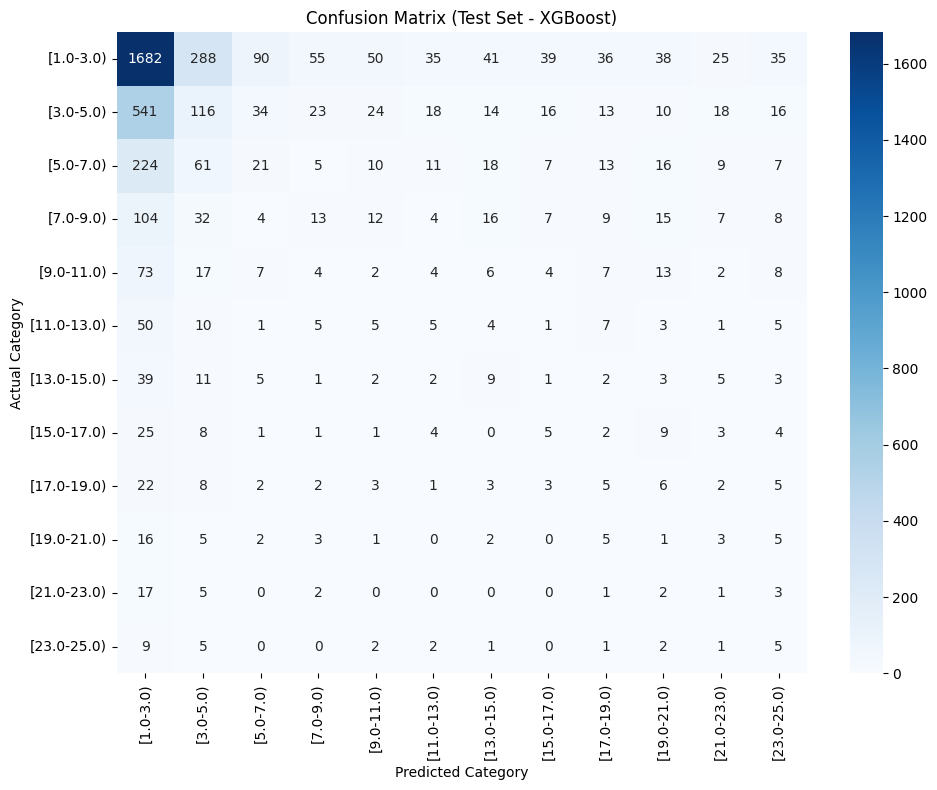

<Figure size 960x600 with 0 Axes>

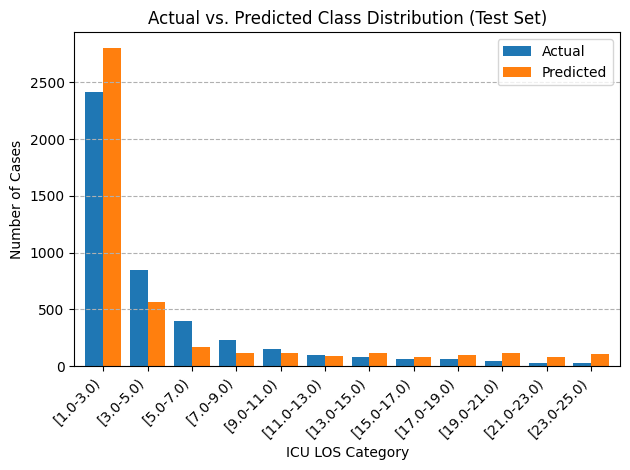


Execution time: 0.74 seconds


In [8]:
# --- Record Start Time ---
start_time = time.time()
print("\n--- Block 4: Evaluating and Visualizing Results ---")

# Check if necessary data for evaluation is available
if ('y_val_cat' not in globals() or
    'y_test_cat' not in globals() or
    'y_pred_val_final' not in globals() or
    'y_pred_test_final' not in globals() or
    'num_classes' not in globals()):
    print("Necessary data for evaluation/visualization is missing. Skipping.")
else:
    # Define descriptive labels for your bins for plotting
    bin_labels_for_plots = []
    if 'WINDOW_DAYS' in globals() and 'BIN_WIDTH' in globals() and num_classes > 0 :
         for i in range(num_classes):
            lower_bound = WINDOW_DAYS + i * BIN_WIDTH
            upper_bound = WINDOW_DAYS + (i + 1) * BIN_WIDTH
            bin_labels_for_plots.append(f"[{lower_bound:.1f}-{upper_bound:.1f})")
    else: # Fallback labels
        bin_labels_for_plots = [f"Cat {i}" for i in range(num_classes)]

    print(f"Using bin labels for plots: {bin_labels_for_plots}")


    # --- 1. Evaluate the Model ---
    # Validation Set Metrics (if y_val_cat and y_pred_val_final are not empty)
    if not y_val_cat.empty and not y_pred_val_final.empty:
        # Ensure labels in classification report and confusion matrix cover all possible classes
        unique_labels_present_val = np.union1d(y_val_cat.unique(), y_pred_val_final.unique())
        # Ensure all labels from 0 to num_classes-1 are considered for consistency if some classes have 0 instances
        report_labels_val = list(range(num_classes))

        accuracy_val = accuracy_score(y_val_cat, y_pred_val_final)
        kappa_val = cohen_kappa_score(y_val_cat, y_pred_val_final, labels=report_labels_val if report_labels_val else None)
        report_val = classification_report(y_val_cat, y_pred_val_final, labels=report_labels_val, target_names=bin_labels_for_plots, zero_division=0)

        print("\n--- Validation Set Metrics (XGBoost - Categorical) ---")
        print(f"Accuracy: {accuracy_val:.3f}")
        print(f"Cohen's Kappa: {kappa_val:.3f}")
        print("Classification Report (Validation):\n", report_val)
    else:
        print("\nValidation data (actual or predicted) is empty. Skipping validation metrics.")

    # Test Set Metrics (if y_test_cat and y_pred_test_final are not empty)
    if not y_test_cat.empty and not y_pred_test_final.empty:
        unique_labels_present_test = np.union1d(y_test_cat.unique(), y_pred_test_final.unique())
        report_labels_test = list(range(num_classes))

        accuracy_test = accuracy_score(y_test_cat, y_pred_test_final)
        kappa_test = cohen_kappa_score(y_test_cat, y_pred_test_final, labels=report_labels_test if report_labels_test else None)
        report_test = classification_report(y_test_cat, y_pred_test_final, labels=report_labels_test, target_names=bin_labels_for_plots, zero_division=0)
        cm_test = confusion_matrix(y_test_cat, y_pred_test_final, labels=report_labels_test)

        print("\n--- Test Set Metrics (XGBoost - Categorical) ---")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Cohen's Kappa: {kappa_test:.3f}")
        print("Classification Report (Test):\n", report_test)
        # print("Confusion Matrix (Test):\n", cm_test)

        # --- 2. Visualize Results (Test Set) ---
        # a) Confusion Matrix Heatmap
        if num_classes > 0:
            plt.figure(figsize=(min(10, num_classes + 2), min(8, num_classes + 1)))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                        xticklabels=bin_labels_for_plots,
                        yticklabels=bin_labels_for_plots)
            plt.xlabel("Predicted Category")
            plt.ylabel("Actual Category")
            plt.title("Confusion Matrix (Test Set - XGBoost)")
            plt.tight_layout()
            plt.show()

            # b) Actual vs. Predicted Class Distribution
            plt.figure(figsize=(max(8, num_classes * 0.8), 6))
            actual_counts = y_test_cat.value_counts().reindex(range(num_classes), fill_value=0).sort_index()
            predicted_counts = y_pred_test_final.value_counts().reindex(range(num_classes), fill_value=0).sort_index()

            df_counts = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})
            if not df_counts.empty:
                # Use the generated bin_labels_for_plots for the x-axis ticks
                df_counts.index = [bin_labels_for_plots[i] for i in df_counts.index if i < len(bin_labels_for_plots)]

                df_counts.plot(kind='bar', width=0.8)
                plt.title("Actual vs. Predicted Class Distribution (Test Set)")
                plt.xlabel("ICU LOS Category")
                plt.ylabel("Number of Cases")
                plt.xticks(rotation=45, ha="right")
                plt.legend()
                plt.grid(axis='y', linestyle='--')
                plt.tight_layout()
                plt.show()
            else:
                print("Cannot plot class distribution: Counts data is empty.")
        else:
            print("Number of classes is 0, cannot generate plots.")
    else:
        print("\nTest data (actual or predicted) is empty. Skipping test metrics and visualization.")


# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")


# **Final Conclusions**

### **Features Distribution**
We were able to get some interesting conclusions from the distribution analysis for each feature, namely:
- Most of the Admissions in ICU Stay occur within the first hour in the hospital
- Most of patients only stay in ICU for `5 days or less`, with a decreasing trend of the number of patients as the number of days increases.
- There is clearly an outlier (`7 AM`) in the distribution of patients by `Hour of Admission`

### **Features Correlation**
We were also able to draw interesting conclusions from the correlation between different features, namely:
- The correlation between `Diagnosis` and `ICU Length of Stay` is evident, with `Twin mate, liveborn, delivered in hospital, with cesarean section` having a much higher mean value compared to other types of Diagnosis
- Regarding the connection between `Age` and `Length of ICU Stay`, we can conclude that the vast majority of ICU stays are relatively short across all adult age groups, although the spread of the values of `Length of ICU Stay` appears to widen slightly for older patients
- All `Insurance` systems have a similar distribution and mean for `ICU Length of Stay`, with a clear exception of `Self Pay`, whose average value is significantly lower.
-	The `EMERGENCY` `Type of Admission` is very correlated with `Hour of Admission`, being much more common in the evening/night `16PM – 23PM`. The `Type of Admission` `Elective` is also correlated with `Hour of Admission`, being very common at `7AM`.
-	Patients who have `EMERGENCY` as their `Type of Admission` tend to `EXPIRE`(die) much more frequently.
-	Some interesting outliers in the distribution of the correlation between `Diagnosis` and `Hour of Admission are `41401 (Coronary atherosclerosis of native coronary artery)`  and `4241 (Aortic valve disorders)` with `7 AM`.
-	`NICU (Neonatal Intensive Care Unit)` has the lowest number of deaths and `MICU (Medical Intensive Care Unit)` has the highest number of deaths.

### **Predictor Model**
- The `accuracy` value in the `Validation` and in `Testing` set are similar and have medium-low values, which mean the model wasn't very sucessful at predicting the patients `ICU Length of Stay` during the validation phase
- The `Cohen's Kappa` value for both `Validation` and `Testing` is very low, which indicates the model is not much better than a random chance model at predicting the correct classes
- The `heatmap` shows that the model is very good at predicting correctly the majority class [1-3] days, but mostly fails at predicting other classes correctly
- The `bar plot` shows that the model predictions distribution is pretty similar to the actual data distribution, which is a good sign for possible future improvements
- In summary, the predictions for the majority class are accurate but for minority classes are not, which is a very common problem in Machine Learning prediction models.
- In future works, we could try to improve these bad results by performing better `feature engineering`, performing `fine-tuning` in the parameters of the predictor model, choose more wisely the features to use and possibly choose a more adequate model for the dataset.

### **GCP and Execution Time**
- The GCP proved to be a reliable and intuitive platform to perform `Machine Learning` projects
- The queries that were timed (not all were because all the results would very similar) executed almost instantly (range from < 1 second to ~3/4 seconds)
- All the steps for executing the `XGBoost Classifier` model were also (and surprisingly!) very fast, with all executions running almost instantly
